# Machine Learning Engineer Nanodegree
## Capstone Project
Felipe Santos  
October 23th, 2018

## I. Definition

### Project Overview

Optical character recognition (OCR) is the process to transform text images to text in a computer format, giving us information in an unstructured way, so is necessary to classify this data to gain knowledge about them and to have better document retrieval. The Tradeshift company make on that foundation a machine learning based product to classify the text blocks in a document to dates, address, and names to enrich the data of the OCR process. This organization resolves to host a competition on Kaggle, a data science platform, opening their data for community try to beat their machine learning model to this classification problem. The competition and the dataset can be access through this [link](https://www.kaggle.com/c/tradeshift-text-classification) and is available to the Kaggle community who intends to beat their benchmark like me.

### Problem Statement

In this competition, we have to create a supervised machine learning algorithm to predict the possibility for a block of text being from a particular label, however, the block can have multiple labels. For all the documents, words are detected and combined to form text blocks that may overlap to each other. Each text block is enclosed within a spatial box, which is depicted by a red line in the sketch below. The text blocks from all documents are aggregated in a data set where each text block corresponds to one sample (row). The text is inputted by the OCR and the host organization gives us some features like the hashed content of the text, position, and size of the box, if the text can be parsed as a date, as a number and include information about the surrounds text blocks in the original document. The final classifier is intended to beat the benchmark of the Tradeshift organization, some tasks involved to reach that goal are:

- Download and preprocess the Tradeshift dataset;
- Do some feature engineering;
- Train different classifiers;
- Tuning the hyperparameters of the algorithm;
- Beat the benchmark.

### Metrics

The evaluation metric chosen by the organizers for this competition was the negative logarithm of the likelihood function averaged over Nt test samples and K labels. As shown by the following equation a + b =c.
On the equation:

$$\textrm{LogLoss} = \frac{1}{N_{t} \cdot K} \sum_{idx=1}^{N_{t} \cdot K} \textrm{LogLoss}_{idx}$$
$$= \frac{1}{N_{t} \cdot K} \sum_{idx=1}^{N_{t} \cdot K} \left[ - y_{idx} \log(\hat{y}_{idx}) - (1 - y_{idx}) \log(1 - \hat{y}_{idx})\right]$$
$$= \frac{1}{N_{t} \cdot K} \sum_{i=1}^{N_{t}} \sum_{j=1}^K \left[ - y_{ij} \log(\hat{y}_{ij}) - (1 - y_{ij}) \log(1 - \hat{y}_{ij})\right]$$

- $f$ is the prediction model
- $\theta$ is the parameter of the model
- $\hat{y}_{ij}$ is the predicted probability of the jth-label is true for the ith-sample
- $log$ represents the natural logarithm
- $idx = (i - 1) * K + j$

This function penalizes probabilities that are confident and wrong, in the worst case, prediction of true(1) for a false label (0) add infinity to the LogLoss function as $-log(0) = \infty$, which makes a total score infinity regardless of the others scores.

This metric is also symmetric in the sense than predicting 0.1 for a false (0) sample has the same penalty as predicting 0.9 for a positive sample (1). The value is bounded between zero and infinity, i.e. $\textrm{LogLoss} \in [0, \infty)$. The competition corresponds to a minimization problem where smaller metric values, $\textrm{LogLoss} \sim 0$, implies better prediction models. To avoid complication with infinity values the predictions are bounded to within the range $[10^{-15},1-10^{-15}]$

#### Example
This is an example from the competition
If the 'answer' file is:
``` csv
id_label,pred
1_y1,1.0000
1_y2,0.0000
1_y3,0.0000
1_y4,0.0000
2_y1,0.0000
2_y2,1.0000
2_y3,0.0000
2_y4,1.0000
3_y1,0.0000
3_y2,0.0000
3_y3,1.0000
3_y4,0.0000

```

And the submission file is:
``` csv
id_label,pred
1_y1,0.9000
1_y2,0.1000
1_y3,0.0000
1_y4,0.3000
2_y1,0.0300
2_y2,0.7000
2_y3,0.2000
2_y4,0.8500
3_y1,0.1900
3_y2,0.0000
3_y3,1.0000
3_y4,0.2700

``` 
the score is 0.1555 as shown by:

$$L = - \frac{1}{12} \left [ log(0.9) + log(1-0.1) + log(1-0.0) +log(1-0.3) + log(1-0.03) + log(0.7) + log(1-0.2) + log(0.85) + log(1-0.19)  + log(1-0.0) + log(1.0) +log(1-0.27) \right ] = 0.1555$$

## II. Analysis

### Data Exploration

1. [Loading Data](#loading_data)
2. [First Look](#first_look)
3. [Metadata](#metadata)
4. [Descriptive statistics](#descriptive)
5. [Data Quality Checks](#quality_check)

In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_



#### Loading Data <a class="anchor" id="loading_data"></a>

In [1]:
%load_ext autoreload
%autoreload 2

import src.describe as d
import src.pre_processing as pre
import src.plots as pl
import pandas as pd
import gc
import pickle
import os.path
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

#### First look <a class="anchor" id="first_look"></a>

In [3]:
train_features = d.read_train_features()
train_labels = d.read_train_labels()

train_features.shape

(1700000, 146)

In [3]:
train_features.head()

,id,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112,x113,x114,x115,x116,x117,x118,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136,x137,x138,x139,x140,x141,x142,x143,x144,x145
0,1,NO,NO,dqOiM6yBYgnVSezBRiQXs9bvOFnRqrtIoXRIElxD7g8=,GNjrXXA3SxbgD0dTRblAPO9jFJ7AIaZnu/f48g5XSUk=,0.576561,0.073139,0.481394,0.115697,0.472474,YES,NO,NO,NO,NO,42,0.396065,3,6,0.991018,0.0,0.82,3306,4676,YES,NO,YES,0,0.405047,0.464610,NO,NO,NO,NO,mimucPmJSF6NI6KM6cPIaaVxWaQyIQzSgtwTTb9bKlc=,s7mTY62CCkWUFc36AW2TlYAy5CIcniD2Vz+lHzyYCLg=,0.576561,0.073139,0.481394,0.115697,0.458560,YES,NO,YES,NO,NO,9,0.368263,2,10,0.992729,0.0,0.94,3306,4676,YES,NO,YES,1,0.375535,0.451301,+2TNtXRI6r9owdGCS80Ia9VVv8ZpuOpVaHEvxRGGu78=,NO,NO,Op+X3asn5H7EQJErI7PR0NkUs3YB+Ld/8OfWuiOC8tU=,GeerC2BbPUcQfQO86NmvOsKrfTvmW7HF+Iru9y+7DPA=,0.576561,0.073139,0.481394,0.115697,0.487598,YES,NO,NO,NO,NO,42,0.363131,6,10,0.987596,0.0,0.71,3306,4676,YES,NO,YES,0,0.375535,0.479734,bxU52teuxC05EZyzFihSiKHczE2ZAIVCXekVLG7j3C0=,NO,NO,+dia7tCOijlRGbABX0YKG5L85x/hXLyJwwplN5Qab04=,f4Uu1R9nnf/h03aqiRQT0Fw3WItzNToLCyRlW1Pn8Z8=,0.576561,0.073139,0.481394,0.115697,0.473079,YES,NO,NO,NO,NO,37,0.333618,4,6,0.987169,0.0,0.89,3306,4676,YES,NO,YES,1,0.346450,0.464610,0.576561,0.073139,0.481394,0.115697,0.473079,YES,NO,NO,NO,NO,42,0.363131,5,6,0.987596,0.0,0.810,3306,4676,YES,NO,YES,2,0.375535,0.464610
1,2,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0,0.000000,0,0,0.000000,0.0,0.00,0,0,NaN,NaN,NaN,0,0.000000,0.000000,NO,NO,NO,NO,l0G2rvmLGE6mpPtAibFsoW/0SiNnAuyAc4k35TrHvoQ=,lblNNeOLanWhqgISofUngPYP0Ne1yQv3QeNHqCAoh48=,1.058379,0.125832,0.932547,0.663037,0.569047,YES,NO,NO,NO,NO,9,0.709921,5,6,0.968240,0.0,0.81,4678,3306,YES,NO,YES,3,0.741682,0.560282,MZZbXga8gvaCBqWpzrh2iKdOkcsz/bG/z4BVjUnqWT0=,NO,NO,TqL9cs8ZFzALzVpZv6wYBDi+6zwhrdarQE/3FH+XAlA=,aZTF/lredyP4cukeN8bh6kpBjYmS1QFNpPOg2LVm3Lg=,1.058379,0.125832,0.932547,0.663037,0.628474,YES,NO,NO,NO,NO,2,0.679371,8,7,0.937387,0.0,0.84,4678,3306,YES,NO,YES,1,0.741984,0.619282,YvZUuCDjLu9VvkCdBWgARWQrvm+FSXgxp0zIrMjcLBc=,NO,NO,dsyhxXKNNJy4WVGD/v4+UGyW3jHWkx2xTdg3STsf34A=,X6dDAI/DZOWvu0Dg6gCgRoNr2vTUz/mc4SdHTNUPS38=,1.058379,0.125832,0.932547,0.663037,0.602394,NO,NO,NO,NO,NO,11,0.581367,3,6,0.966122,0.0,0.87,4678,3306,NO,NO,NO,3,0.615245,0.593630,1.058379,0.125832,0.932547,0.663037,0.602394,YES,NO,NO,NO,NO,9,0.709921,4,6,0.968240,0.0,0.510,4678,3306,YES,NO,YES,4,0.741682,0.593630
2,3,NO,NO,ib4VpsEsqJHzDiyL0dZLQ+xQzDPrkxE+9T3mx5fv2wI=,X6dDAI/DZOWvu0Dg6gCgRoNr2vTUz/mc4SdHTNUPS38=,1.341803,0.051422,0.935572,0.041440,0.501710,NO,NO,YES,NO,NO,2,0.838475,3,5,0.966122,0.0,0.74,4678,3306,NO,NO,NO,2,0.872353,0.493159,NO,NO,YES,YES,9TRXThP/ifDpJRGFX1LQseibUA1NJ3XM53gy+1eZ46k=,XSJ6E8aAoZC7/KAu3eETpfMg3mCq7HVBFIVIsoMKh9E=,1.341803,0.051422,0.935572,0.041440,0.447627,YES,NO,NO,NO,YES,2,0.752269,5,7,0.954930,0.0,0.82,4678,3306,YES,NO,YES,2,0.797338,0.438435,cr+kkNnNFV9YL0vz029hk3ohIDmGuABRVNhFe0ePZyo=,NO,NO,oFsUwSLCWcj8UA1cqILh5afKVcvwlFA+ohJ147Wkz5I=,WV5vAHFyqkeuyFB5KVNGFOBuwjkUGKYc8wh9QfpVzAA=,1.341803,0.051422,0.935572,0.041440,0.522873,YES,NO,NO,NO,NO,1,0.732305,6,6,0.954930,0.0,0.80,4678,3306,YES,NO,YES,0,0.777374,0.513681,X6dDAI/DZOWvu0Dg6gCgRoNr2vTUz/mc4SdHTNUPS38=,NO,NO,mRPnGiKVOWTk/vzZaqlLXZRtdrkcQ/sX0hqBCqOuKq0=,oo9tGpHvTredpg9JkHgYbZAuxcwtSpQxU5mA/zUbxY8=,1.341803,0.051422,0.935572,0.041440,0.501710,NO,NO,NO,NO,NO,2,0.657290,6,5,0.936479,0.0,0.79,4678,3306,NO,NO,NO,0,0.720811,0.493159,1.341803,0.051422,0.935572,0.041440,0.501710,NO,NO,YES,NO,NO,5,0.742589,3,5,0.966122,0.0,0.850,4678,3306,NO,NO,NO

In [4]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700000 entries, 0 to 1699999
Columns: 146 entries, id to x145
dtypes: float64(55), int64(31), object(60)
memory usage: 1.8+ GB


In [5]:
train_labels.shape

(1700000, 34)

In [6]:
train_labels.head()

,id,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25,y26,y27,y28,y29,y30,y31,y32,y33
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [7]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700000 entries, 0 to 1699999
Data columns (total 34 columns):
id     int64
y1     int64
y2     int64
y3     int64
y4     int64
y5     int64
y6     int64
y7     int64
y8     int64
y9     int64
y10    int64
y11    int64
y12    int64
y13    int64
y14    int64
y15    int64
y16    int64
y17    int64
y18    int64
y19    int64
y20    int64
y21    int64
y22    int64
y23    int64
y24    int64
y25    int64
y26    int64
y27    int64
y28    int64
y29    int64
y30    int64
y31    int64
y32    int64
y33    int64
dtypes: int64(34)
memory usage: 441.0 MB


#### Metadata <a class="anchor" id="metadata"></a>

In this section, we will categorize the collumns to try to facilitate the manipulation. We'll store:
* **dtype**: int, float, str
* **category**: content, numerical, boolean

In [2]:
meta = d.create_features_meta(train_features)
meta.head(10)

,role,category,dtype
varname,,,
id,id,numerical,int64
x1,input,boolean,object
x2,input,boolean,object
x3,input,content,object
x4,input,content,object
x5,input,numerical,float64
x6,input,numerical,float64
x7,input,numerical,float64
x8,input,numerical,float64


Extract all boolean features:

In [9]:
meta[meta.category == 'boolean'].index

Index(['x1', 'x2', 'x10', 'x11', 'x12', 'x13', 'x14', 'x24', 'x25', 'x26',
       'x30', 'x31', 'x32', 'x33', 'x41', 'x42', 'x43', 'x44', 'x45', 'x55',
       'x56', 'x57', 'x62', 'x63', 'x71', 'x72', 'x73', 'x74', 'x75', 'x85',
       'x86', 'x87', 'x92', 'x93', 'x101', 'x102', 'x103', 'x104', 'x105',
       'x115', 'x116', 'x117', 'x126', 'x127', 'x128', 'x129', 'x130', 'x140',
       'x141', 'x142'],
      dtype='object', name='varname')

See the quantity of feature per category:

In [10]:
pd.DataFrame({'count' : meta.groupby(['category', 'dtype'])['dtype'].size()}).reset_index()

,category,dtype,count
0,boolean,object,50
1,content,object,10
2,numerical,int64,31
3,numerical,float64,55


#### Descriptive Statistics <a class="anchor" id="descriptive"></a>

In this section we will apply the _describe_ method on the features splited by category and dtype to calculate the mean, standart deviation, max, min... 

**_Numerical float variables_**

In [3]:
float_features = meta[(meta.category == 'numerical') & (meta.dtype == 'float64')].index
float_train_features = train_features[float_features]
float_train_features_describe = float_train_features.describe()
float_train_features_describe

,x5,x6,x7,x8,x9,x16,x19,x20,x21,x28,x29,x36,x37,x38,x39,x40,x47,x50,x51,x52,x59,x60,x66,x67,x68,x69,x70,x77,x80,x81,x82,x89,x90,x96,x97,x98,x99,x100,x107,x110,x111,x112,x119,x120,x121,x122,x123,x124,x125,x132,x135,x136,x137,x144,x145
count,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06
mean,9.551493e-01,5.531406e-02,7.906443e-01,1.731225e-01,4.462953e-01,4.196774e-01,8.185989e-01,-6.392546e-02,7.858669e-01,4.523190e-01,4.378473e-01,1.082852e+00,6.117782e-02,8.954949e-01,1.830648e-01,4.846973e-01,4.348303e-01,9.112922e-01,-8.473989e-02,8.910999e-01,4.898810e-01,4.749733e-01,1.082232e+00,6.106558e-02,8.841590e-01,1.989396e-01,5.124087e-01,4.270050e-01,8.953298e-01,-8.269609e-02,8.798031e-01,4.870141e-01,5.029204e-01,1.027301e+00,5.602975e-02,8.466713e-01,1.833974e-01,4.780893e-01,3.693654e-01,8.783841e-01,-6.801648e-02,8.460217e-01,4.053633e-01,4.689895e-01,1.121410e+00,6.366866e-02,9.229534e-01,1.967985e-01,5.163925e-01,4.397928e-01,9.336593e-01,7.678663e-02,9.231219e-01,5.238243e-01,5.053399e-01
std,5.278641e-01,1.318832e-01,3.549407e-01,3.326885e-01,3.026847e-01,2.945485e-01,3.422650e-01,4.972203e-01,3.457971e-01,3.019166e-01,3.010004e-01,4.222894e-01,1.369235e-01,2.233018e-01,3.280037e-01,2.633006e-01,2.817998e-01,1.892331e-01,6.268609e-01,2.024930e-01,2.823276e-01,2.633976e-01,4.265242e-01,1.365560e-01,2.422241e-01,3.513484e-01,2.731636e-01,2.850214e-01,2.214036e-01,6.064530e-01,2.234765e-01,2.869244e-01,2.727644e-01,4.761280e-01,1.275268e-01,2.958083e-01,3.368791e-01,2.857023e-01,2.660854e-01,2.688927e-01,5.270641e-01,2.804542e-01,2.673060e-01,2.848163e-01,3.789949e-01,1.397335e-01,1.604844e-01,3.432269e-01,2.577492e-01,2.781111e-01,7.191982e-02,1.538817e+00,1.215640e-01,2.703335e-01,2.582544e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.042755e+00,-5.919283e-01,-3.520179e-01,-4.600000e+01,0.000000e+00,-5.762332e-01,-1.051465e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.839272e+00,-6.244395e-01,-4.652466e-01,-4.800000e+01,0.000000e+00,-5.997758e-01,-1.847189e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.839272e+00,-6.244395e-01,-4.652466e-01,-4.800000e+01,0.000000e+00,-5.997758e-01,-1.847189e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.042755e+00,-6.244395e-01,-3.520179e-01,-4.800000e+01,0.000000e+00,-5.997758e-01,-1.051465e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.584323e+00,-6.793722e-01,-3.520179e-01,-4.800000e+01,0.000000e+00,-5.762332e-01,-2.592241e+00
25%,6.367211e-01,0.000000e+00,8.438324e-01,0.000000e+00,1.961279e-01,1.670404e-01,9.292196e-01,0.000000e+00,7.900000e-01,2.062780e-01,1.854545e-01,7.068146e-01,0.000000e+00,9.231700e-01,0.000000e+00,2.782293e-01,1.717569e-01,9.327354e-01,0.000000e+00,8.600000e-01,2.331839e-01,2.686212e-01,7.068146e-01,0.000000e+00,9.204477e-01,0.000000e+00,3.056215e-01,1.636771e-01,9.310954e-01,0.000000e+00,8.600000e-01,2.302266e-01,2.955626e-01,6.539119e-01,0.000000e+00,9.056261e-01,0.000000e+00,2.541568e-01,1.267636e-01,9.383872e-01,0.000000e+00,8.500000e-01,1.729664e-01,2.435905e-01,7.879613e-01,0.000000e+00,9.277072e-01,0.000000e+00,3.151227e-01,1.785164e-01,9.162930e-01,0.000000e+00,8.800000e-01,2.756953e-01,3.041061e-01
50%,1.270115e+00,0.000000e+00,9.588627e-01,0.000000e+00,4.393339e-01,4.002242e-01,9.630045e-01,0.000000e+00,9.500000e-01,4.433551e-01,

In [12]:
float_train_features_describe.loc()[['min','max']]

,x5,x6,x7,x8,x9,x16,x19,x20,x21,x28,x29,x36,x37,x38,x39,x40,x47,x50,x51,x52,x59,x60,x66,x67,x68,x69,x70,x77,x80,x81,x82,x89,x90,x96,x97,x98,x99,x100,x107,x110,x111,x112,x119,x120,x121,x122,x123,x124,x125,x132,x135,x136,x137,x144,x145
min,0.000000,0.00000,0.0,0.000000,-1.042755,-0.591928,-0.352018,-46.0,0.0,-0.576233,-1.051465,0.000000,0.000000,0.0,0.000000,-1.839272,-0.624439,-0.465247,-48.0,0.0,-0.599776,-1.847189,0.000000,0.000000,0.0,0.000000,-1.839272,-0.624439,-0.465247,-48.000000,0.0,-0.599776,-1.847189,0.000000,0.000000,0.0,0.000000,-1.042755,-0.624439,-0.352018,-48.0,0.0,-0.599776,-1.051465,0.000000,0.000000,0.0,0.000000,-2.584323,-0.679372,-0.352018,-48.0,0.0,-0.576233,-2.592241
max,2.732124,0.99879,1.0,1.753333,1.942155,7.929372,0.999786,14.0,1.0,7.968610,1.932647,2.732124,0.998242,1.0,1.753333,1.942155,3.884529,0.999786,14.0,1.0,3.923767,1.932647,2.732124,0.998242,1.0,1.793262,1.942155,3.884529,0.999786,9.333333,1.0,3.923767,1.932647,2.732124,0.995312,1.0,1.753333,1.942155,7.929372,0.999786,14.0,1.0,7.968610,1.932647,2.732124,0.998242,1.0,1.753333,1.942155,7.974215,0.999998,147.0,1.0,8.002242,1.932647


In [13]:
float_train_features.isnull().any().any()

False

The features that are scaled between [0,1] are: x6, x7, x21, x37, x38, x52, x67, x68, x82, x97, x98, x112, x122, x123, x137.

So we could apply scaling on the other features depends on the classifier.

And we don't have any NaN values on this features.


**_Numerical int variables_**

In [4]:
int_features = meta[(meta.category == 'numerical') & (meta.dtype == 'int64') & (meta.role != 'id')].index
int_train_features = train_features[int_features]
int_train_features_describe = int_train_features.describe()
int_train_features_describe

,x15,x17,x18,x22,x23,x27,x46,x48,x49,x53,x54,x58,x76,x78,x79,x83,x84,x88,x106,x108,x109,x113,x114,x118,x131,x133,x134,x138,x139,x143
count,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06,1.700000e+06
mean,6.154404e+00,4.487084e+00,8.096322e+00,2.301595e+03,1.874765e+03,2.814097e+00,8.151020e+00,6.973005e+00,8.363310e+00,2.605915e+03,2.098133e+03,2.640614e+00,8.259205e+00,7.502141e+00,8.401614e+00,2.581685e+03,2.079391e+03,2.685396e+00,7.851039e+00,4.854556e+00,8.419647e+00,2.469781e+03,1.998761e+03,2.314082e+00,4.809295e+00,9.301809e+00,8.842868e+00,2.688457e+03,2.163423e+03,3.632134e+00
std,8.957511e+00,4.623426e+00,7.123864e+00,1.745120e+03,1.517991e+03,4.409801e+00,1.036050e+01,9.311837e+00,6.656968e+00,1.632477e+03,1.421664e+03,3.823310e+00,1.055778e+01,1.129549e+01,6.834330e+00,1.648193e+03,1.433160e+03,3.921535e+00,1.001937e+01,4.483374e+00,6.886586e+00,1.691323e+03,1.470973e+03,3.914509e+00,8.966942e+00,7.725215e+00,6.665332e+00,1.591809e+03,1.392787e+03,9.424120e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00
25%,1.000000e+00,2.000000e+00,3.000000e+00,1.261000e+03,8.920000e+02,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.262000e+03,8.920000e+02,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.262000e+03,8.920000e+02,0.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.261000e+03,8.920000e+02,0.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,1.262000e+03,8.920000e+02,1.000000e+00
50%,3.000000e+00,4.000000e+00,7.000000e+00,1.263000e+03,8.920000e+02,1.000000e+00,4.000000e+00,5.000000e+00,7.000000e+00,1.263000e+03,9.180000e+02,1.000000e+00,4.000000e+00,5.000000e+00,7.000000e+00,1.263000e+03,9.180000e+02,1.000000e+00,4.000000e+00,4.000000e+00,7.000000e+00,1.263000e+03,9.180000e+02,1.000000e+00,1.000000e+00,7.000000e+00,7.000000e+00,1.263000e+03,9.180000e+02,2.000000e+00
75%,7.000000e+00,6.000000e+00,1.100000e+01,4.400000e+03,3.307000e+03,4.000000e+00,9.000000e+00,8.000000e+00,1.100000e+01,4.659000e+03,3.307000e+03,4.000000e+00,9.000000e+00,8.000000e+00,1.200000e+01,4.643000e+03,3.307000e+03,4.000000e+00,9.000000e+00,7.000000e+00,1.200000e+01,4.400000e+03,3.307000e+03,3.000000e+00,5.000000e+00,1.300000e+01,1.200000e+01,4.672000e+03,3.308000e+03,5.000000e+00
max,1.530000e+02,2.370000e+02,2.190000e+02,1.950000e+04,1.416700e+04,6.720000e+02,1.530000e+02,3.710000e+02,2.190000e+02,1.950000e+04,1.416700e+04,3.370000e+02,1.530000e+02,2.710000e+02,2.190000e+02,1.950000e+04,1.416700e+04,2.840000e+02,1.530000e+02,2.430000e+02,2.190000e+02,1.950000e+04,1.416700e+04,4.100000e+02,1.530000e+02,3.010000e+02,2.190000e+02,1.950000e+04,1.416700e+04,1.219000e+03


In [ ]:
int_train_features_describe.loc()[['min','max']]

In [16]:
int_train_features_describe.isnull().any().any()

False

All the int numerical features are not scaled, so depending on the algorithm we have to scale the feature, we don't have any missing value. The problem here is we don't know when the feature is a categorical feature or a quantitative. 

**_Content variables_**

In [8]:
content_features = meta[(meta.category == 'content')].index
content_train_features = train_features[content_features]
content_train_features_describe = content_train_features.describe()
content_train_features_describe

,x3,x4,x34,x35,x61,x64,x65,x91,x94,x95
count,1451737,1451737,1649154,1649154,1699968,1628939,1628939,1699968,1559381,1559381
unique,201881,26428,241245,35700,461141,245418,36814,134998,184925,26791
top,MZZbXga8gvaCBqWpzrh2iKdOkcsz/bG/z4BVjUnqWT0=,hCXwO/JldK5zcd9ejOD1FwmEgCf96eTdEVy7OtY2Y2g=,MZZbXga8gvaCBqWpzrh2iKdOkcsz/bG/z4BVjUnqWT0=,YvZUuCDjLu9VvkCdBWgARWQrvm+FSXgxp0zIrMjcLBc=,X/hdUOVR5KuExVGLzjhLcM2CyIqym9t0Nh+ZX05M+1w=,MZZbXga8gvaCBqWpzrh2iKdOkcsz/bG/z4BVjUnqWT0=,YvZUuCDjLu9VvkCdBWgARWQrvm+FSXgxp0zIrMjcLBc=,+yhSY//Hpg7u0bSA7NYmcmRFgv3bF4Tw3BMHrBqaTtA=,MZZbXga8gvaCBqWpzrh2iKdOkcsz/bG/z4BVjUnqWT0=,hCXwO/JldK5zcd9ejOD1FwmEgCf96eTdEVy7OtY2Y2g=
freq,51212,86750,57978,84162,60369,65666,93540,89494,47700,105073


In [16]:
uniques = pre.extract_uniques_words(train_features, content_features)
print('total uniques words={}'.format(len(uniques)))

# flattening all the words to count them
all_words = pd.Series(content_train_features.values.flatten('F'))
all_words = all_words.to_frame().reset_index()
print('total words={}'.format(all_words.shape[0]))
all_words = all_words.rename(columns= {0: 'words'})
all_words = pd.DataFrame({'count' : all_words.groupby(['words'])['words'].size()}).reset_index()
all_words.sort_values('count', ascending=False).head(10)

total uniques words=979749
total words=17000000


,words,count
565834,YvZUuCDjLu9VvkCdBWgARWQrvm+FSXgxp0zIrMjcLBc=,392698
538278,X6dDAI/DZOWvu0Dg6gCgRoNr2vTUz/mc4SdHTNUPS38=,356811
692301,hCXwO/JldK5zcd9ejOD1FwmEgCf96eTdEVy7OtY2Y2g=,317031
376725,MZZbXga8gvaCBqWpzrh2iKdOkcsz/bG/z4BVjUnqWT0=,273502
199214,B+EJpnEbkYtLnwDQYN1dP1rcfnoCnxAjKLYwQZE07Ew=,260233
15027,+yhSY//Hpg7u0bSA7NYmcmRFgv3bF4Tw3BMHrBqaTtA=,260166
528829,WV5vAHFyqkeuyFB5KVNGFOBuwjkUGKYc8wh9QfpVzAA=,237367
264280,FExKgjj6CsbToTubdZ+kGsOmUx3gCvZVJCdZPcdPNF4=,208934
808722,oo9tGpHvTredpg9JkHgYbZAuxcwtSpQxU5mA/zUbxY8=,182455
49401,1CiKJR7D66tRwH6l6wwv0p+D/tAuoW+NdSNqPTbvDoQ=,176907


In [19]:
content_train_features.isnull().sum()

x3     248263
x4     248263
x34    50846 
x35    50846 
x61    32    
x64    71061 
x65    71061 
x91    32    
x94    140619
x95    140619
dtype: int64

On the hashed words we have 979_749 unique words on 17_000_000 (1.7kk rows x 10 collumns) words giving 5.76% of uniques words on the total words. This show us that word can have a huge impact on the classifier because we have some words multiples times. But we have to take care of the NaN values and treat them.

**_Boolean variables_**

In [5]:
bool_vars = meta[(meta.category == 'boolean')].index
train_features[bool_vars].describe()
train_features[bool_vars].isnull().sum()

x1      248190
x2      248190
x10     248263
x11     248263
x12     248263
x13     248263
x14     248263
x24     248263
x25     248263
x26     248263
x30     0     
x31     0     
x32     50772 
x33     50772 
x41     50846 
x42     50846 
x43     50846 
x44     50846 
x45     50846 
x55     50846 
x56     50846 
x57     50846 
x62     70978 
x63     70978 
x71     71061 
x72     71061 
x73     71061 
x74     71061 
x75     71061 
x85     71061 
x86     71061 
x87     71061 
x92     140526
x93     140526
x101    140619
x102    140619
x103    140619
x104    140619
x105    140619
x115    140619
x116    140619
x117    140619
x126    32    
x127    32    
x128    32    
x129    32    
x130    32    
x140    32    
x141    32    
x142    32    
dtype: int64

On the boolean values, only on 2 features we have no missing values. So we have to treat all this missing values here.

**_Labels variables_**

In [21]:
total = train_labels.shape[0]
for col in train_labels.columns:
    if col != 'id':
        print(train_labels[col].value_counts(sort=True))
        print('')

0    1689631
1    10369  
Name: y1, dtype: int64

0    1698871
1    1129   
Name: y2, dtype: int64

0    1664400
1    35600  
Name: y3, dtype: int64

0    1677704
1    22296  
Name: y4, dtype: int64

0    1699855
1    145    
Name: y5, dtype: int64

0    1573102
1    126898 
Name: y6, dtype: int64

0    1635569
1    64431  
Name: y7, dtype: int64

0    1698519
1    1481   
Name: y8, dtype: int64

0    1567117
1    132883 
Name: y9, dtype: int64

0    1670709
1    29291  
Name: y10, dtype: int64

0    1698432
1    1568   
Name: y11, dtype: int64

0    1575878
1    124122 
Name: y12, dtype: int64

0    1675185
1    24815  
Name: y13, dtype: int64

0    1700000
Name: y14, dtype: int64

0    1695913
1    4087   
Name: y15, dtype: int64

0    1681200
1    18800  
Name: y16, dtype: int64

0    1699824
1    176    
Name: y17, dtype: int64

0    1699704
1    296    
Name: y18, dtype: int64

0    1698863
1    1137   
Name: y19, dtype: int64

0    1695057
1    4943   
Name: y20, dtype: int64

0 

We only have two types of response on labels 0 and 1, making a binary classification problem

In [22]:
for col in train_labels.columns:
    if col != 'id':
        total_1 = total - train_labels[col].value_counts(sort=True)[0]
        perc = total_1 / total
        print('Column {} has {} positive labels, {:.2%} of total'.format(col, total_1, perc))

Column y1 has 10369 positive labels, 0.61% of total
Column y2 has 1129 positive labels, 0.07% of total
Column y3 has 35600 positive labels, 2.09% of total
Column y4 has 22296 positive labels, 1.31% of total
Column y5 has 145 positive labels, 0.01% of total
Column y6 has 126898 positive labels, 7.46% of total
Column y7 has 64431 positive labels, 3.79% of total
Column y8 has 1481 positive labels, 0.09% of total
Column y9 has 132883 positive labels, 7.82% of total
Column y10 has 29291 positive labels, 1.72% of total
Column y11 has 1568 positive labels, 0.09% of total
Column y12 has 124122 positive labels, 7.30% of total
Column y13 has 24815 positive labels, 1.46% of total
Column y14 has 0 positive labels, 0.00% of total
Column y15 has 4087 positive labels, 0.24% of total
Column y16 has 18800 positive labels, 1.11% of total
Column y17 has 176 positive labels, 0.01% of total
Column y18 has 296 positive labels, 0.02% of total
Column y19 has 1137 positive labels, 0.07% of total
Column y20 has

As we see most of the labels have few positive values and the last label has 55.96% of the total rows in positive values.  

In [26]:
train_labels.loc[:, train_labels.columns != 'id'].sum(axis=1).value_counts()

1    1547755
2    110870 
3    31909  
4    9321   
5    145    
dtype: int64

91.04% of text blocks have only one label and the rest has more than one label.

#### Data Quality Checks <a class="anchor" id="quality_check"></a>

**_Checking Missings Values_**

In [23]:
vars_with_missing = []
for f in train_features.columns:
    missings = train_features[f].isnull().sum()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train_features.shape[0]
        category = meta.loc[f]['category']
        dtype = meta.loc[f]['dtype']
        
        print('Variable {} ({}, {}) has {} records ({:.2%}) with missing values'.format(f, category, dtype, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable x1 (boolean, object) has 248190 records (14.60%) with missing values
Variable x2 (boolean, object) has 248190 records (14.60%) with missing values
Variable x3 (content, object) has 248263 records (14.60%) with missing values
Variable x4 (content, object) has 248263 records (14.60%) with missing values
Variable x10 (boolean, object) has 248263 records (14.60%) with missing values
Variable x11 (boolean, object) has 248263 records (14.60%) with missing values
Variable x12 (boolean, object) has 248263 records (14.60%) with missing values
Variable x13 (boolean, object) has 248263 records (14.60%) with missing values
Variable x14 (boolean, object) has 248263 records (14.60%) with missing values
Variable x24 (boolean, object) has 248263 records (14.60%) with missing values
Variable x25 (boolean, object) has 248263 records (14.60%) with missing values
Variable x26 (boolean, object) has 248263 records (14.60%) with missing values
Variable x32 (boolean, object) has 50772 records (2.99%)

Some missing values variables repeat the quatity of missing values, this can be because of the relational text blocks, so if this text block is the leftmost block on the document, they will not have some block at the left. And this can go for other directions too.

**_Checking the cardinality of the int variables_**

Cardinality means the differents values of a variable, so we will see which feature will became dummy variables.

In [24]:
for f in int_train_features:
    dist_values = int_train_features[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable x15 has 97 distinct values
Variable x17 has 119 distinct values
Variable x18 has 108 distinct values
Variable x22 has 498 distinct values
Variable x23 has 419 distinct values
Variable x27 has 193 distinct values
Variable x46 has 122 distinct values
Variable x48 has 167 distinct values
Variable x49 has 110 distinct values
Variable x53 has 499 distinct values
Variable x54 has 419 distinct values
Variable x58 has 149 distinct values
Variable x76 has 127 distinct values
Variable x78 has 184 distinct values
Variable x79 has 109 distinct values
Variable x83 has 498 distinct values
Variable x84 has 417 distinct values
Variable x88 has 141 distinct values
Variable x106 has 109 distinct values
Variable x108 has 123 distinct values
Variable x109 has 109 distinct values
Variable x113 has 500 distinct values
Variable x114 has 419 distinct values
Variable x118 has 159 distinct values
Variable x131 has 125 distinct values
Variable x133 has 158 distinct values
Variable x134 has 110 distinct 

At this point i can't see if I will treat this variables as categorical and transform in dummy variables or treat them as quatitative variables.

### Exploratory Visualization

1. [Numerical Int variables](#int_variables)
2. [Numerical Float variables](#float_variables)
3. [Boolean variables](#boolean_variables) 

In this section, we will explore visually the dataset trying to summarizes and extracts relevants characteristics about the data.

#### Numerical int variables <a class="anchor" id="int_variables"></a> 

Variable x15 has 97 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

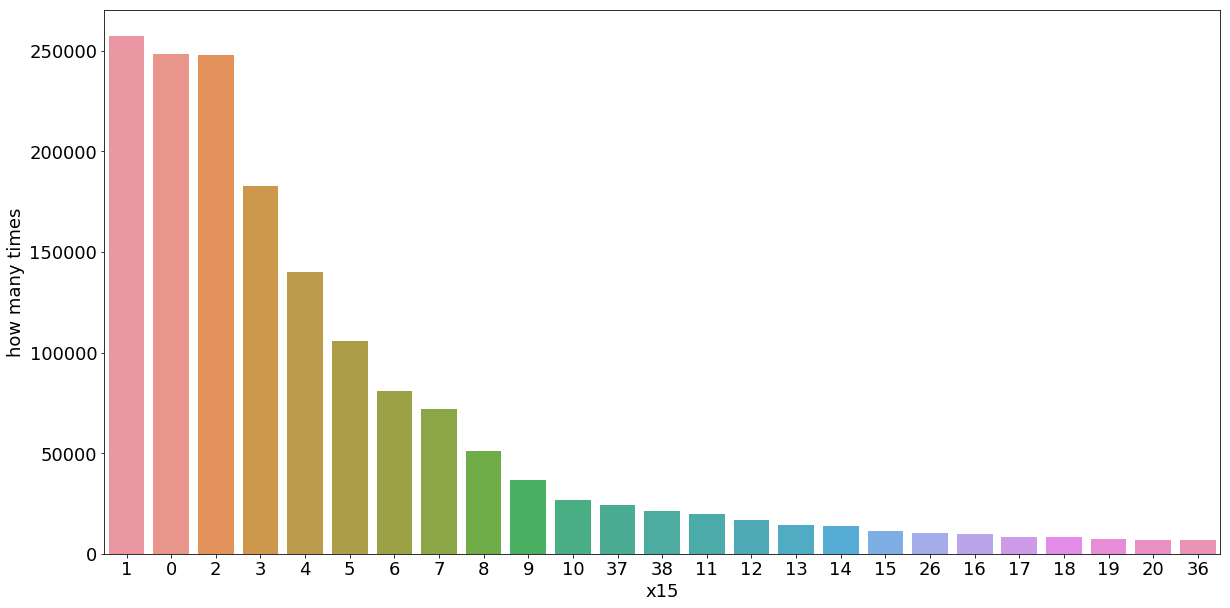

count    1700000.000000
mean     6.154404      
std      8.957511      
min      0.000000      
25%      1.000000      
50%      3.000000      
75%      7.000000      
max      153.000000    
Name: x15, dtype: object




Variable x17 has 119 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

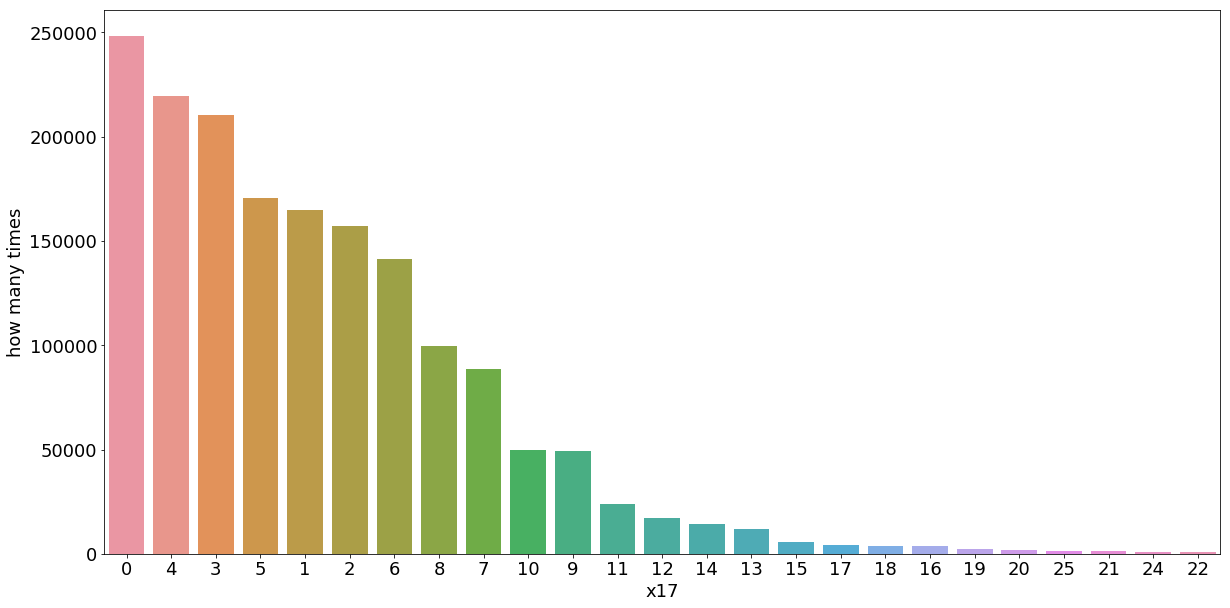

count    1700000.000000
mean     4.487084      
std      4.623426      
min      0.000000      
25%      2.000000      
50%      4.000000      
75%      6.000000      
max      237.000000    
Name: x17, dtype: object




Variable x18 has 108 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

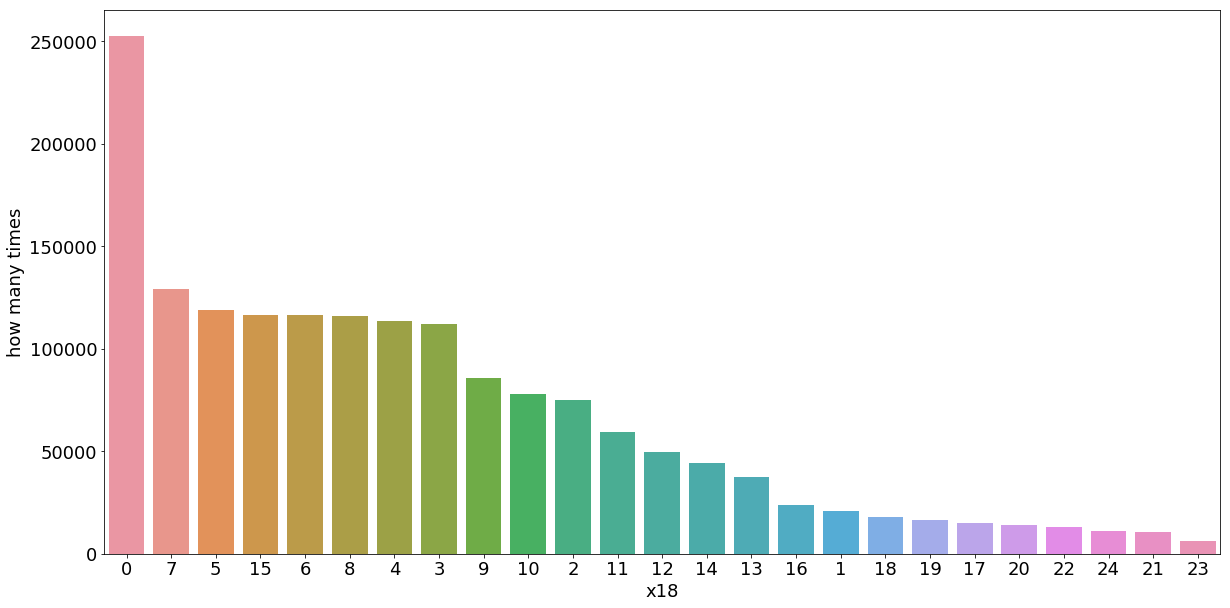

count    1700000.000000
mean     8.096322      
std      7.123864      
min      0.000000      
25%      3.000000      
50%      7.000000      
75%      11.000000     
max      219.000000    
Name: x18, dtype: object




Variable x22 has 498 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

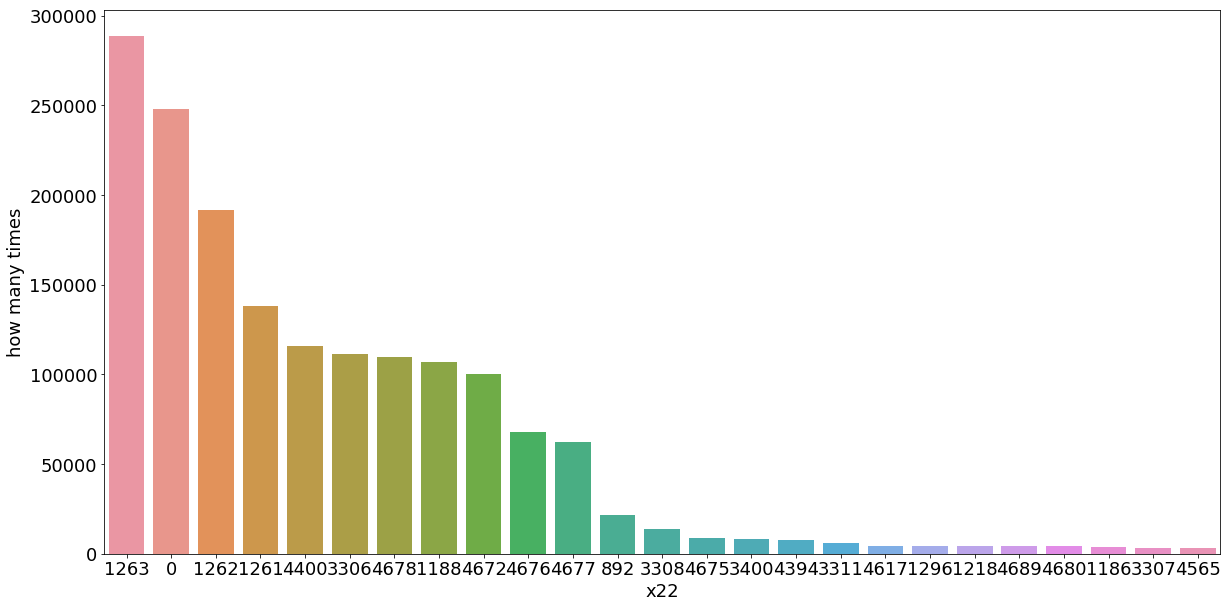

count    1700000.000000
mean     2301.595118   
std      1745.119509   
min      0.000000      
25%      1261.000000   
50%      1263.000000   
75%      4400.000000   
max      19500.000000  
Name: x22, dtype: object




Variable x23 has 419 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

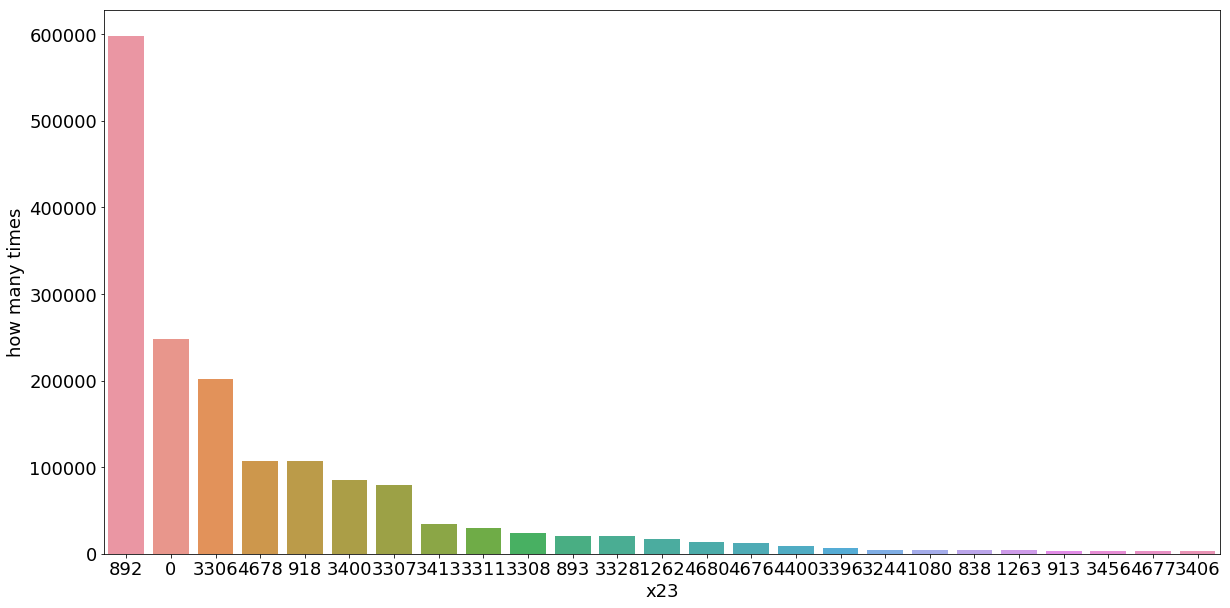

count    1700000.000000
mean     1874.765323   
std      1517.990813   
min      0.000000      
25%      892.000000    
50%      892.000000    
75%      3307.000000   
max      14167.000000  
Name: x23, dtype: object




Variable x27 has 193 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

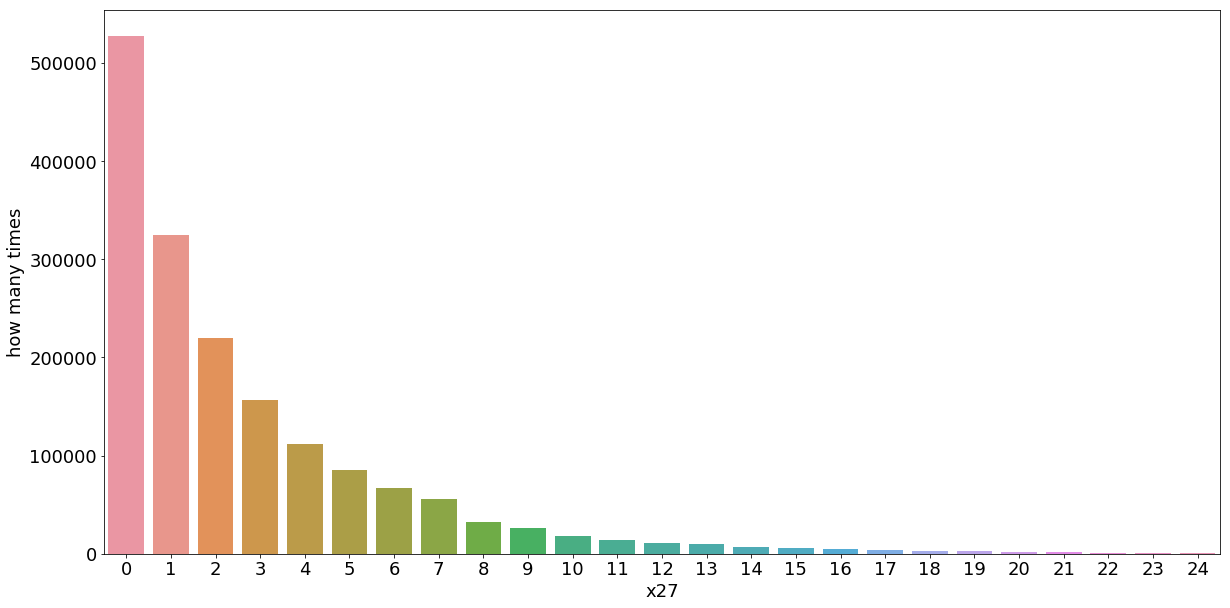

count    1700000.000000
mean     2.814097      
std      4.409801      
min      -1.000000     
25%      0.000000      
50%      1.000000      
75%      4.000000      
max      672.000000    
Name: x27, dtype: object




Variable x46 has 122 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

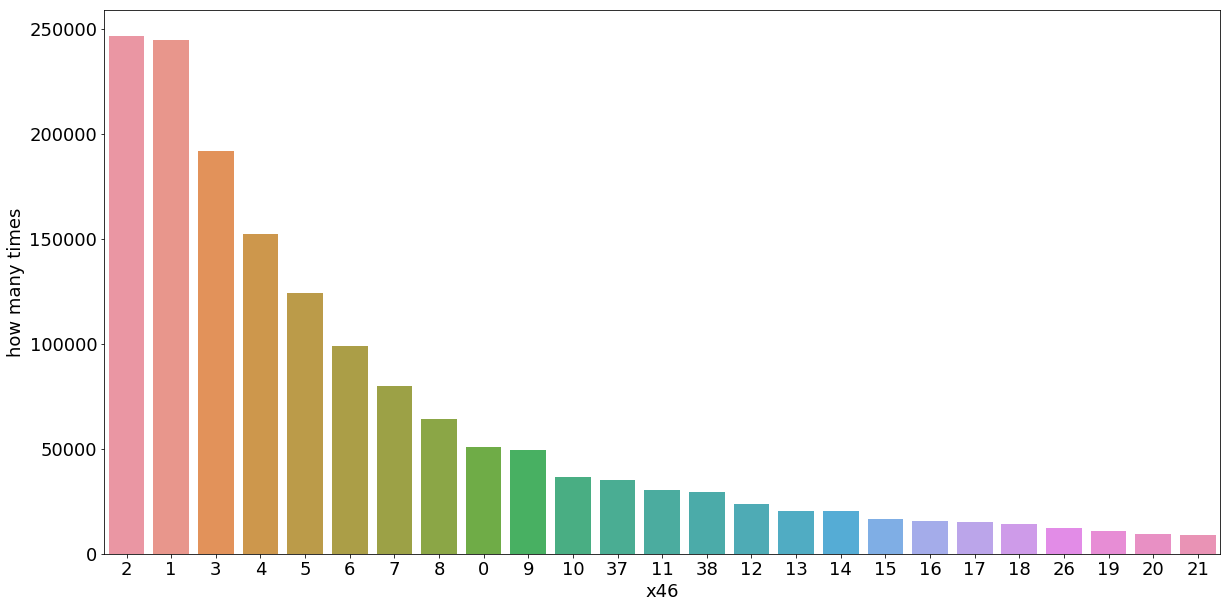

count    1700000.000000
mean     8.151020      
std      10.360501     
min      0.000000      
25%      2.000000      
50%      4.000000      
75%      9.000000      
max      153.000000    
Name: x46, dtype: object




Variable x48 has 167 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

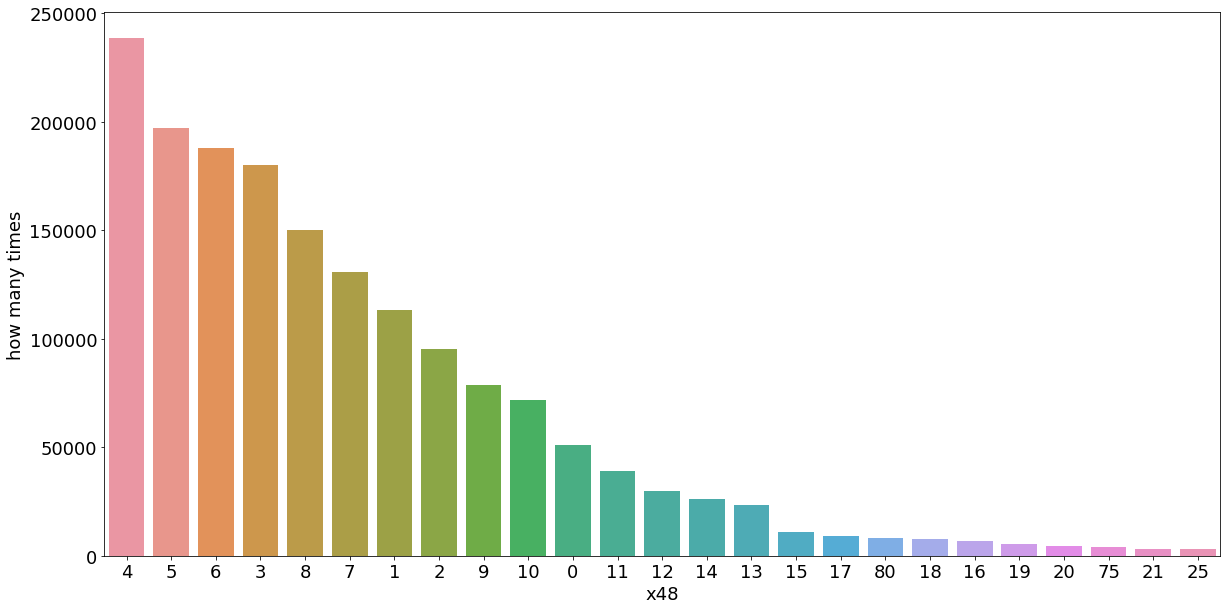

count    1700000.000000
mean     6.973005      
std      9.311837      
min      0.000000      
25%      3.000000      
50%      5.000000      
75%      8.000000      
max      371.000000    
Name: x48, dtype: object




Variable x49 has 110 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

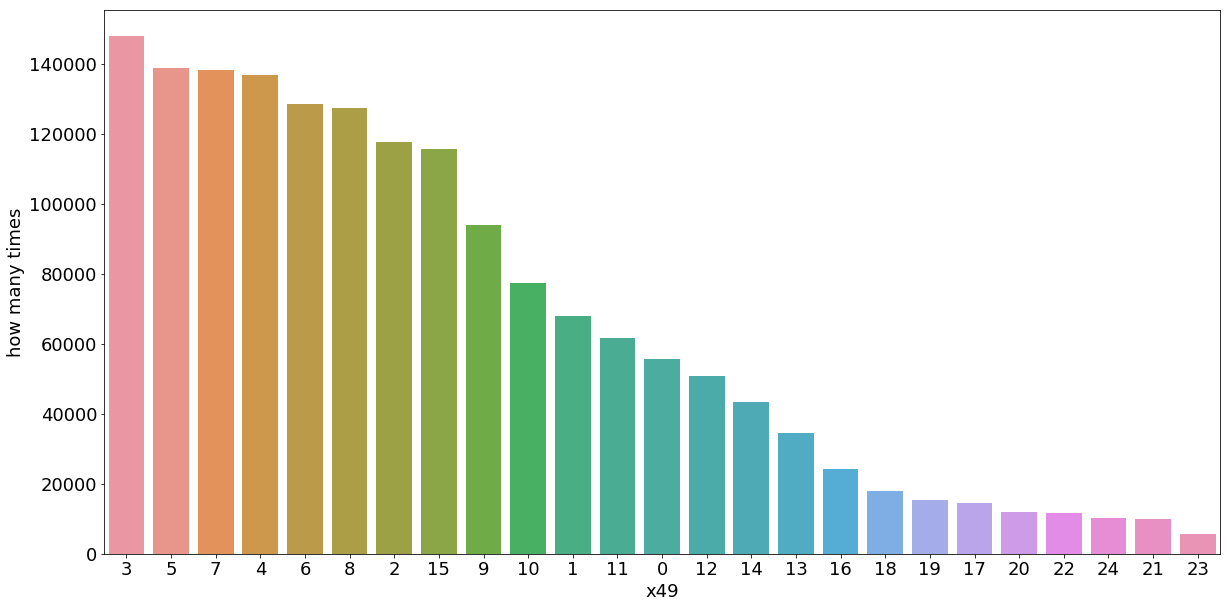

count    1700000.000000
mean     8.363310      
std      6.656968      
min      0.000000      
25%      4.000000      
50%      7.000000      
75%      11.000000     
max      219.000000    
Name: x49, dtype: object




Variable x53 has 499 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

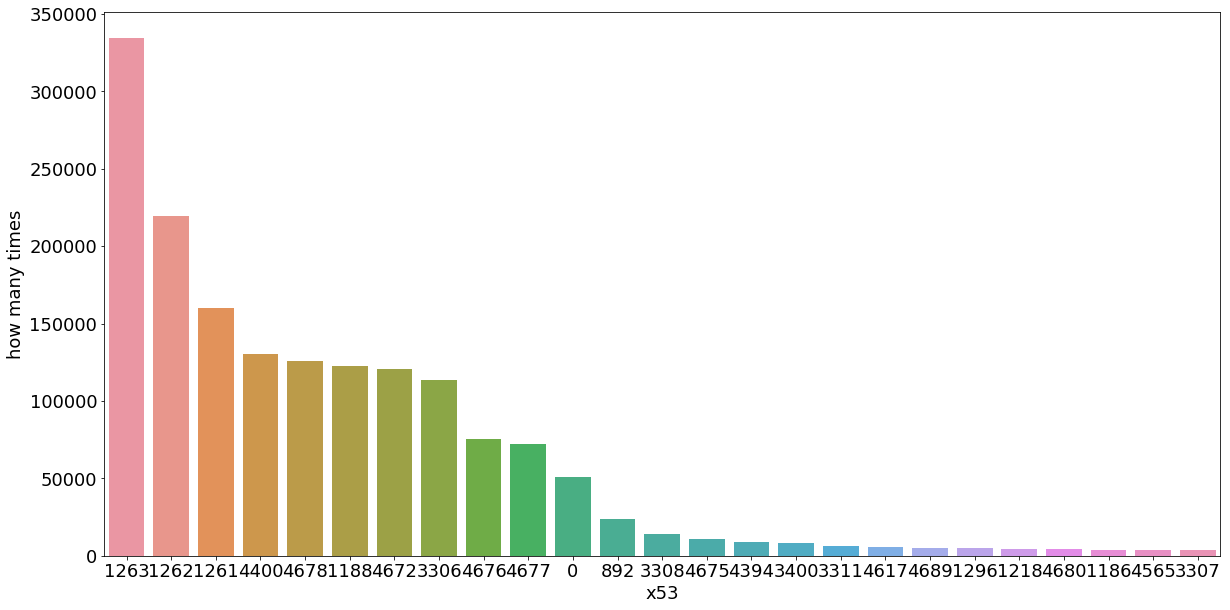

count    1700000.000000
mean     2605.914796   
std      1632.476755   
min      0.000000      
25%      1262.000000   
50%      1263.000000   
75%      4659.000000   
max      19500.000000  
Name: x53, dtype: object




Variable x54 has 419 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

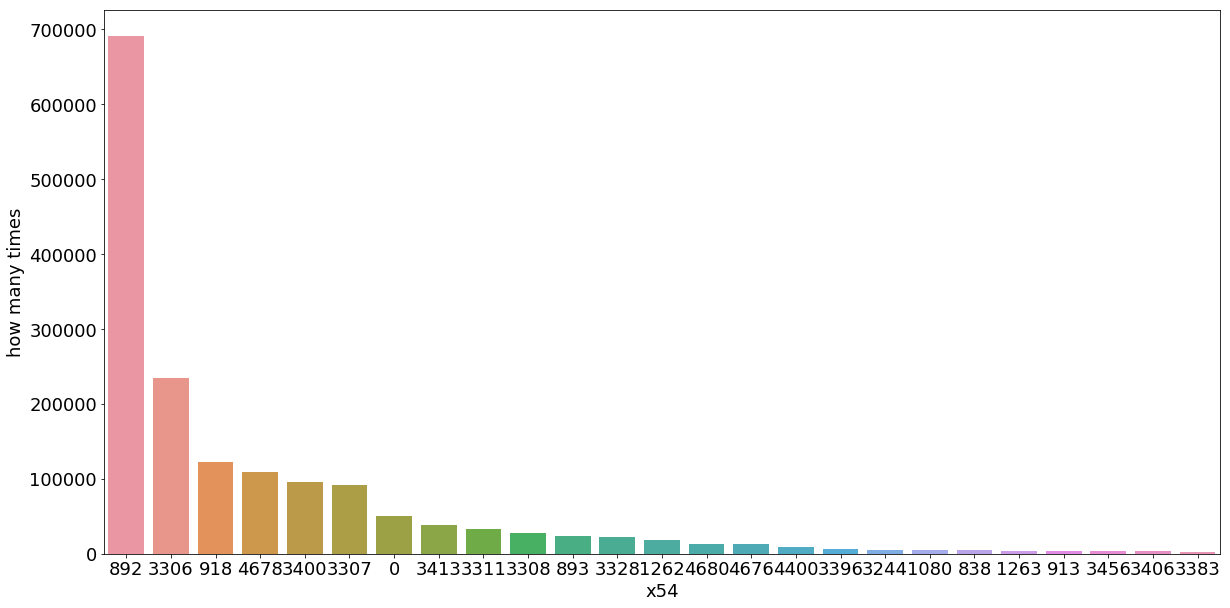

count    1700000.000000
mean     2098.132814   
std      1421.664275   
min      0.000000      
25%      892.000000    
50%      918.000000    
75%      3307.000000   
max      14167.000000  
Name: x54, dtype: object




Variable x58 has 149 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

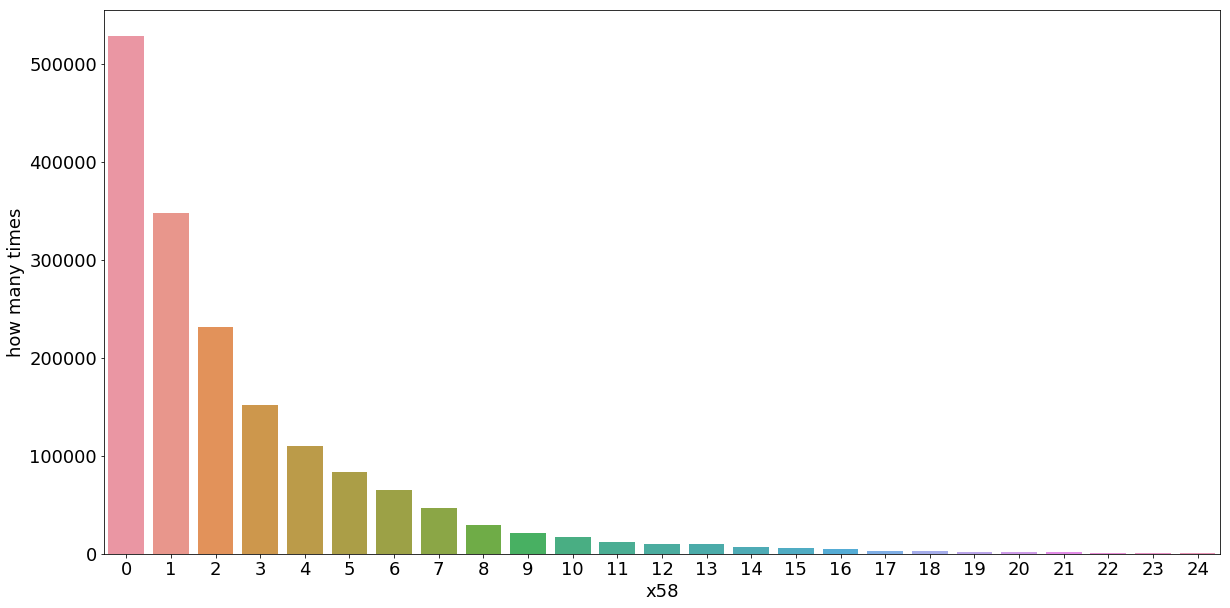

count    1700000.000000
mean     2.640614      
std      3.823310      
min      -1.000000     
25%      0.000000      
50%      1.000000      
75%      4.000000      
max      337.000000    
Name: x58, dtype: object




Variable x76 has 127 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

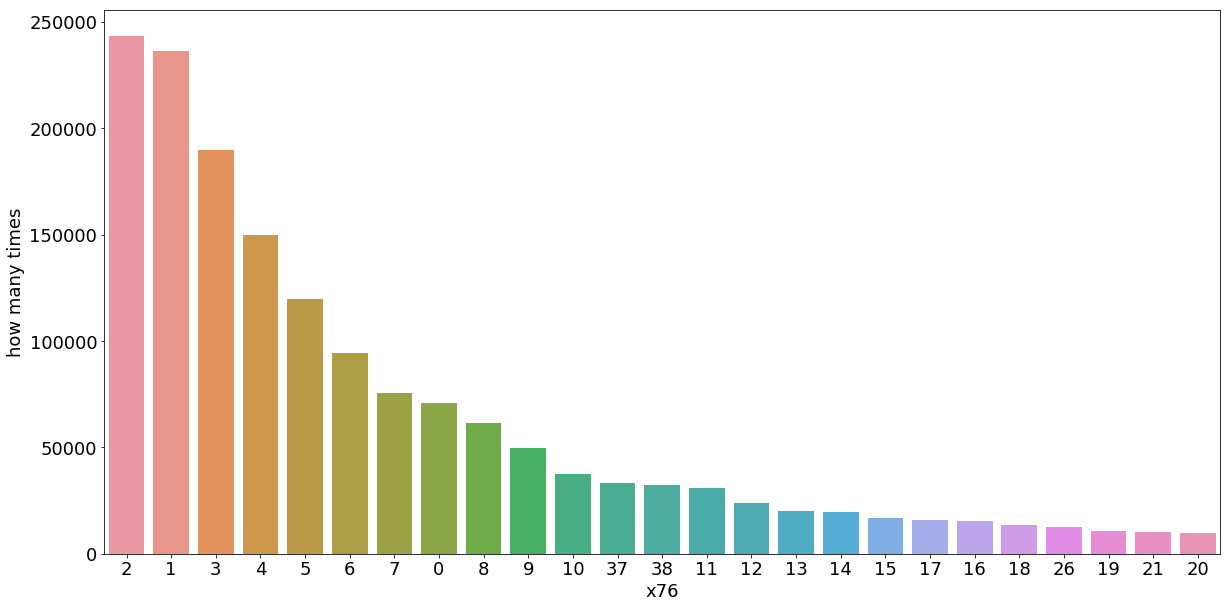

count    1700000.000000
mean     8.259205      
std      10.557784     
min      0.000000      
25%      2.000000      
50%      4.000000      
75%      9.000000      
max      153.000000    
Name: x76, dtype: object




Variable x78 has 184 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

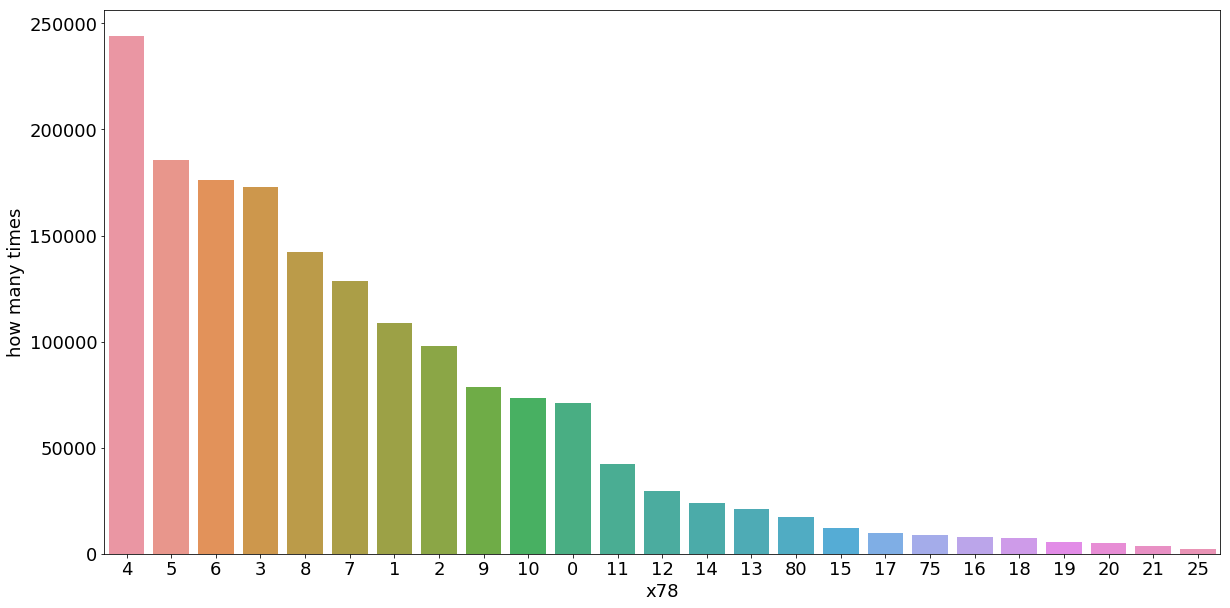

count    1700000.000000
mean     7.502141      
std      11.295486     
min      0.000000      
25%      3.000000      
50%      5.000000      
75%      8.000000      
max      271.000000    
Name: x78, dtype: object




Variable x79 has 109 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

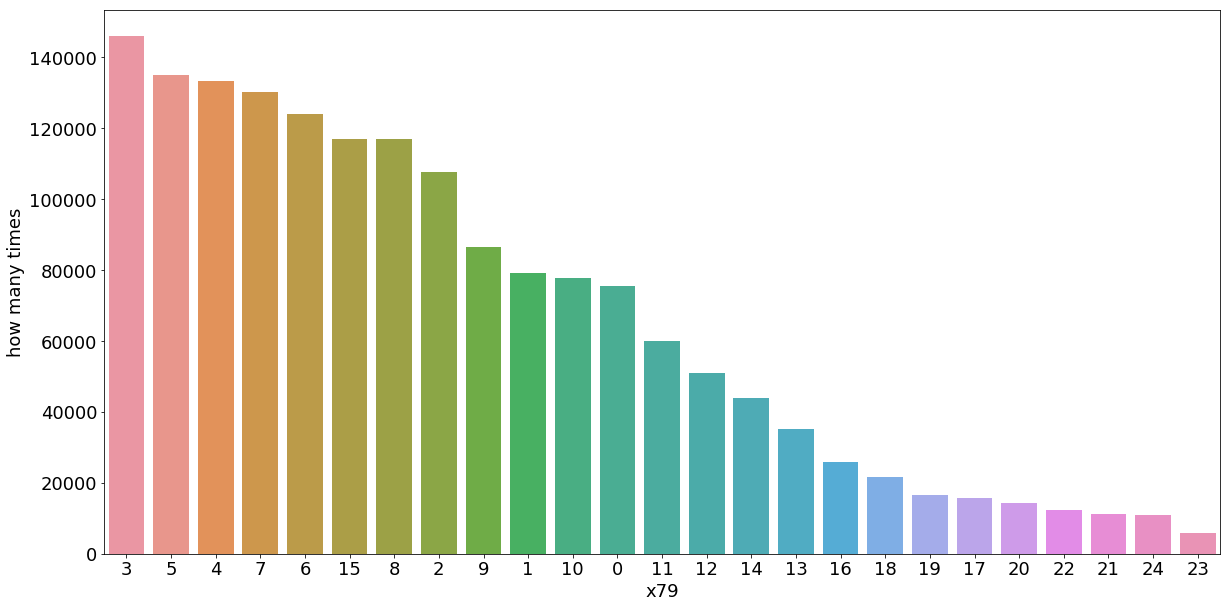

count    1700000.000000
mean     8.401614      
std      6.834330      
min      0.000000      
25%      4.000000      
50%      7.000000      
75%      12.000000     
max      219.000000    
Name: x79, dtype: object




Variable x83 has 498 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

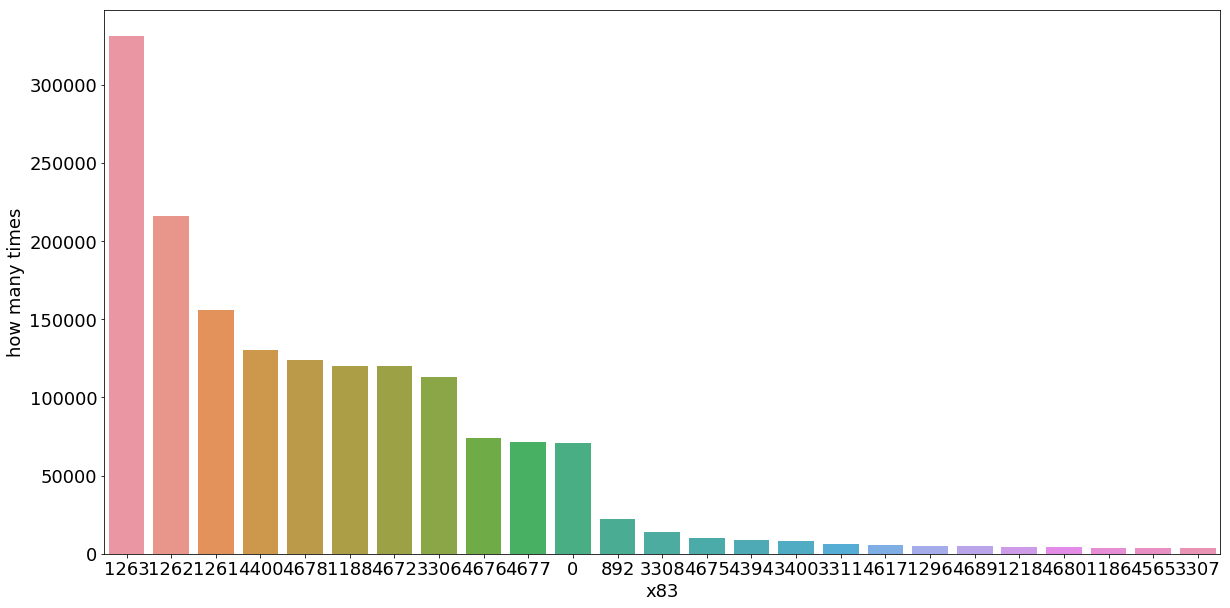

count    1700000.000000
mean     2581.685180   
std      1648.193261   
min      0.000000      
25%      1262.000000   
50%      1263.000000   
75%      4643.000000   
max      19500.000000  
Name: x83, dtype: object




Variable x84 has 417 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

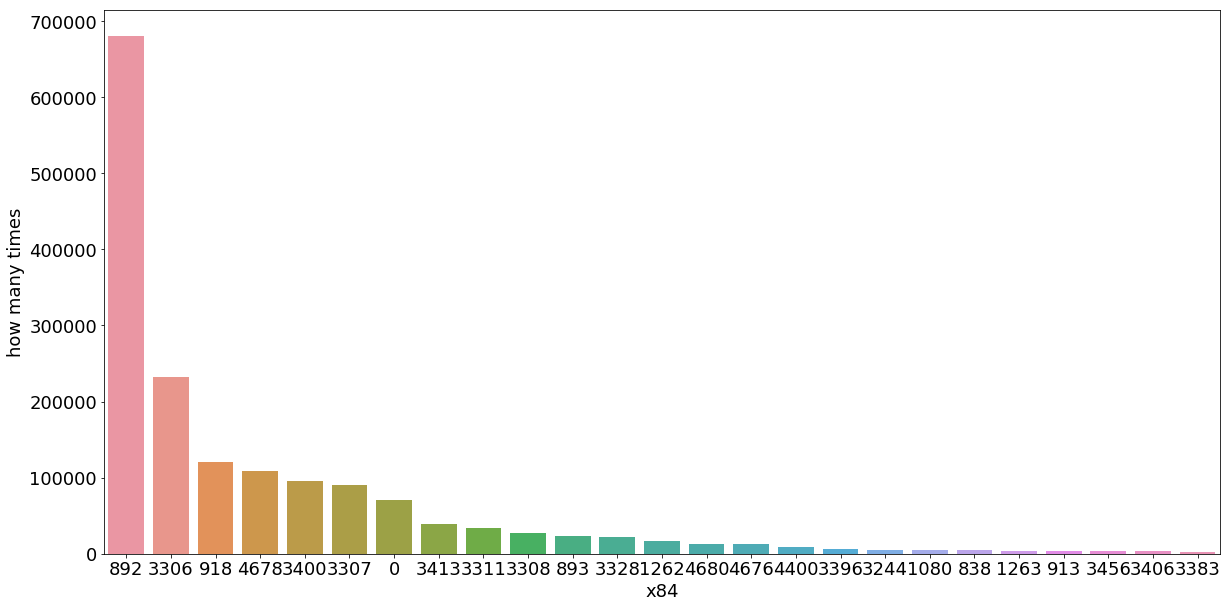

count    1700000.000000
mean     2079.390638   
std      1433.160352   
min      0.000000      
25%      892.000000    
50%      918.000000    
75%      3307.000000   
max      14167.000000  
Name: x84, dtype: object




Variable x88 has 141 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

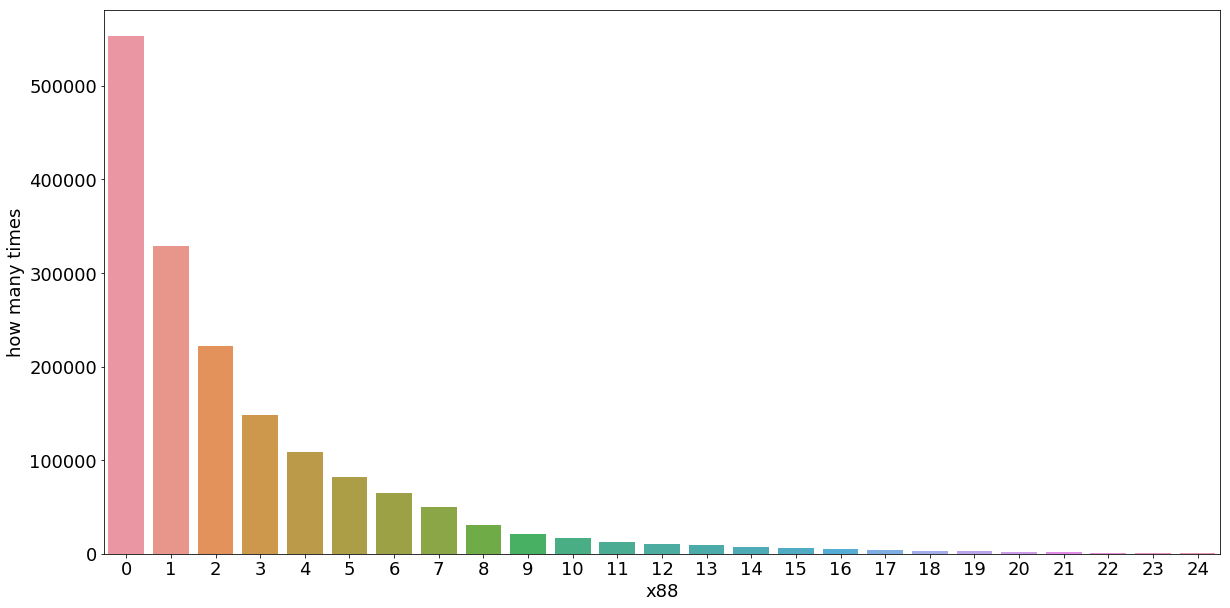

count    1700000.000000
mean     2.685396      
std      3.921535      
min      -1.000000     
25%      0.000000      
50%      1.000000      
75%      4.000000      
max      284.000000    
Name: x88, dtype: object




Variable x106 has 109 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

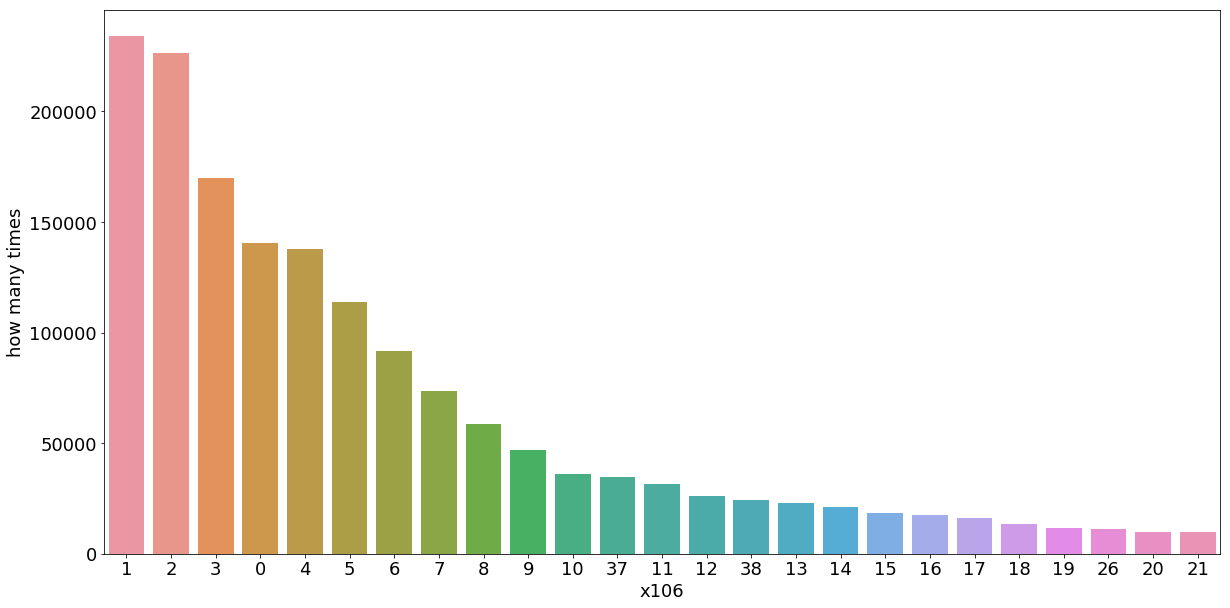

count    1700000.000000
mean     7.851039      
std      10.019375     
min      0.000000      
25%      2.000000      
50%      4.000000      
75%      9.000000      
max      153.000000    
Name: x106, dtype: object




Variable x108 has 123 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

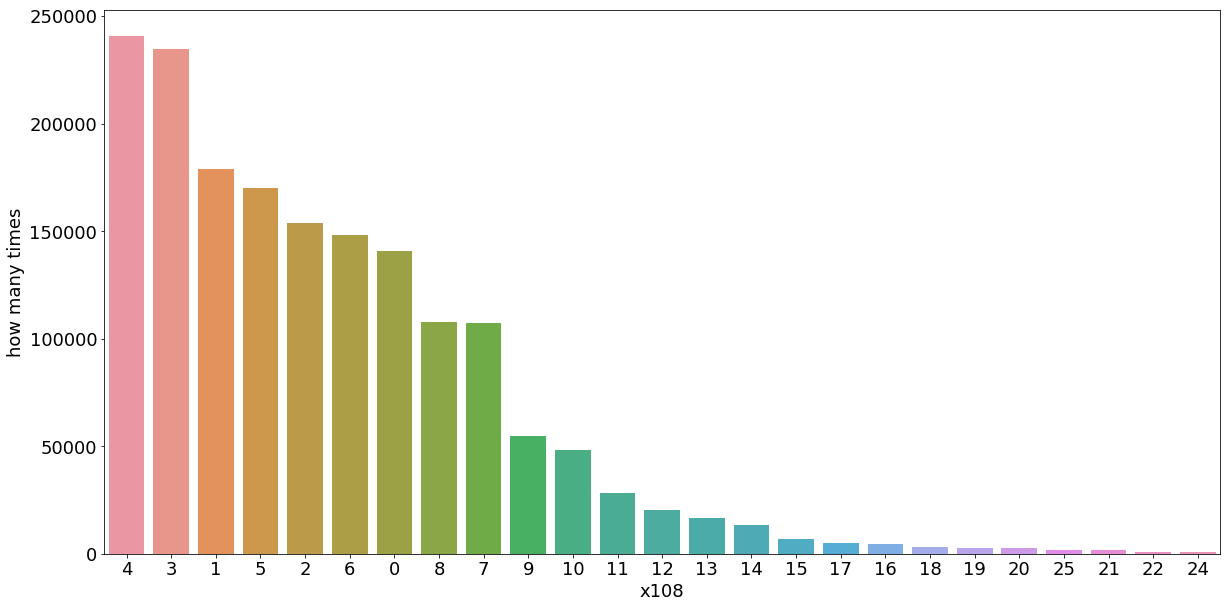

count    1700000.000000
mean     4.854556      
std      4.483374      
min      0.000000      
25%      2.000000      
50%      4.000000      
75%      7.000000      
max      243.000000    
Name: x108, dtype: object




Variable x109 has 109 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

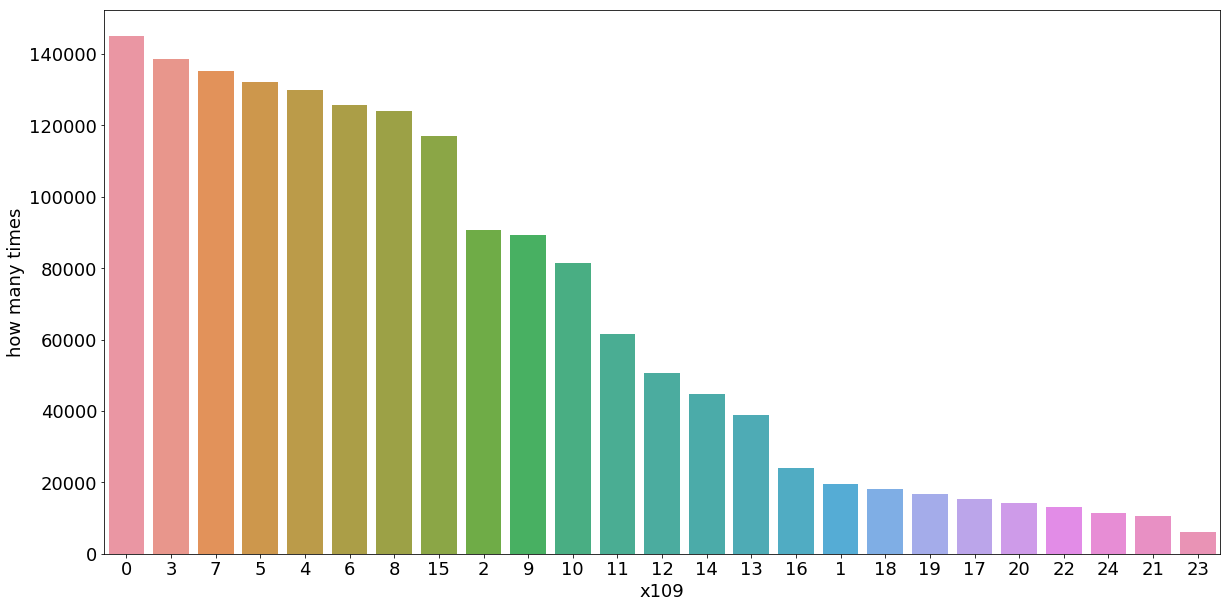

count    1700000.000000
mean     8.419647      
std      6.886586      
min      0.000000      
25%      4.000000      
50%      7.000000      
75%      12.000000     
max      219.000000    
Name: x109, dtype: object




Variable x113 has 500 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

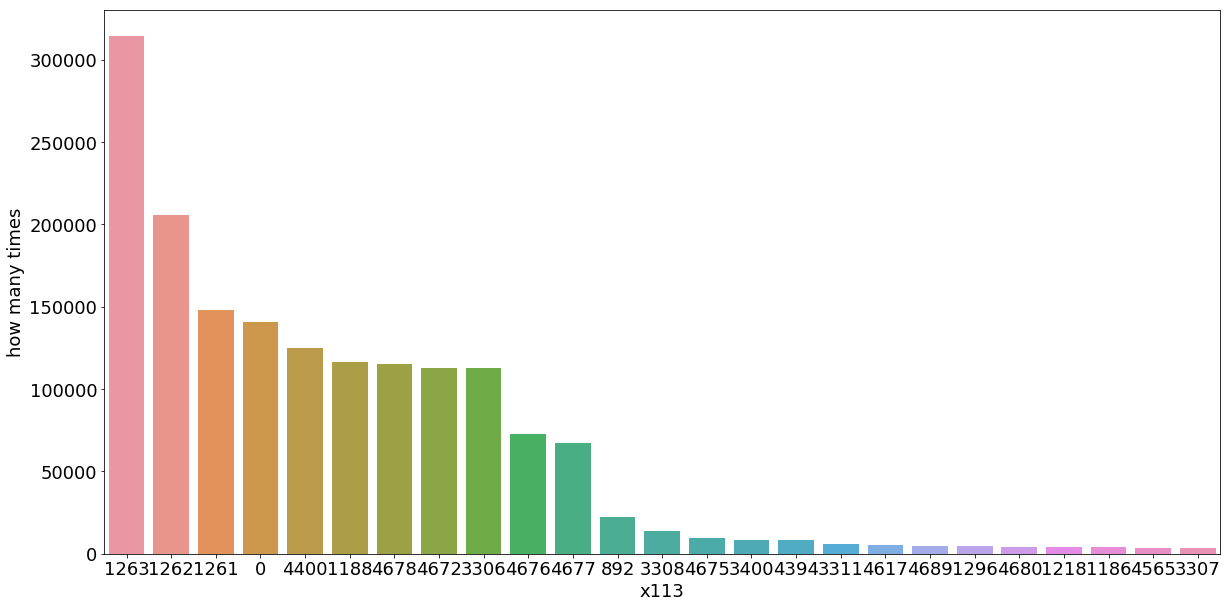

count    1700000.000000
mean     2469.780722   
std      1691.322508   
min      0.000000      
25%      1261.000000   
50%      1263.000000   
75%      4400.000000   
max      19500.000000  
Name: x113, dtype: object




Variable x114 has 419 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

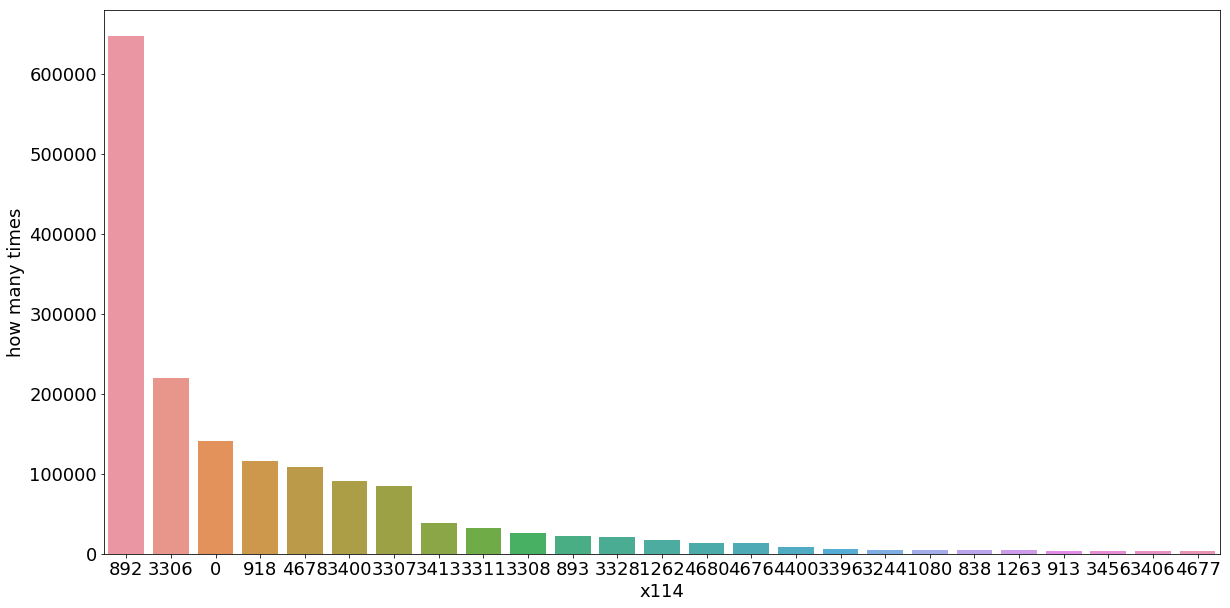

count    1700000.000000
mean     1998.761406   
std      1470.972957   
min      0.000000      
25%      892.000000    
50%      918.000000    
75%      3307.000000   
max      14167.000000  
Name: x114, dtype: object




Variable x118 has 159 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

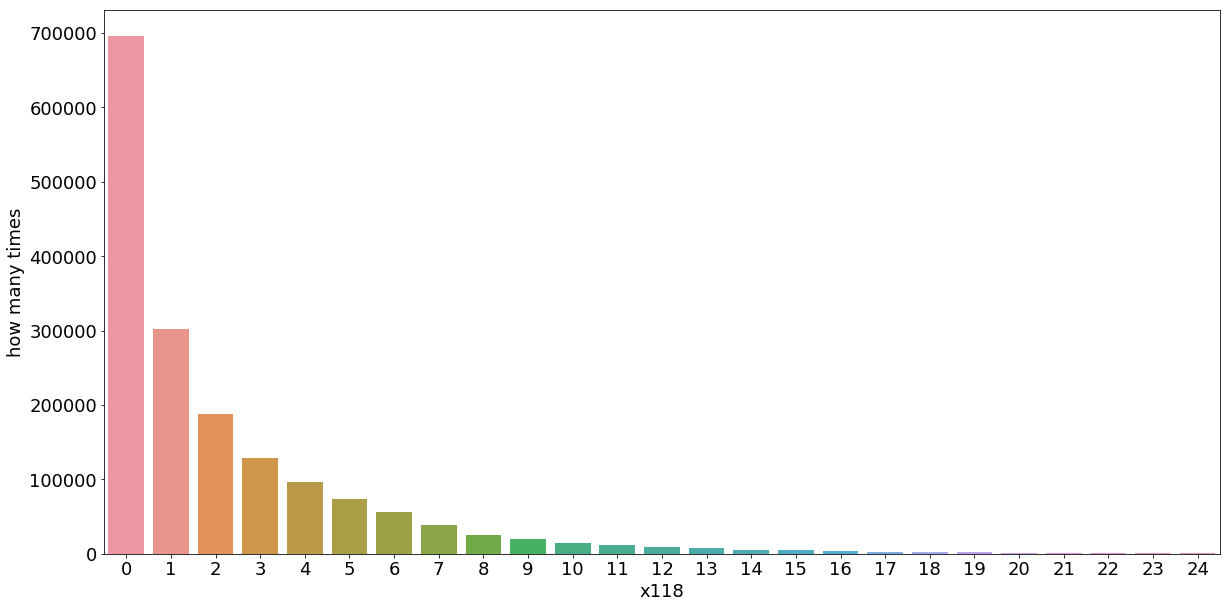

count    1700000.000000
mean     2.314082      
std      3.914509      
min      -1.000000     
25%      0.000000      
50%      1.000000      
75%      3.000000      
max      410.000000    
Name: x118, dtype: object




Variable x131 has 125 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

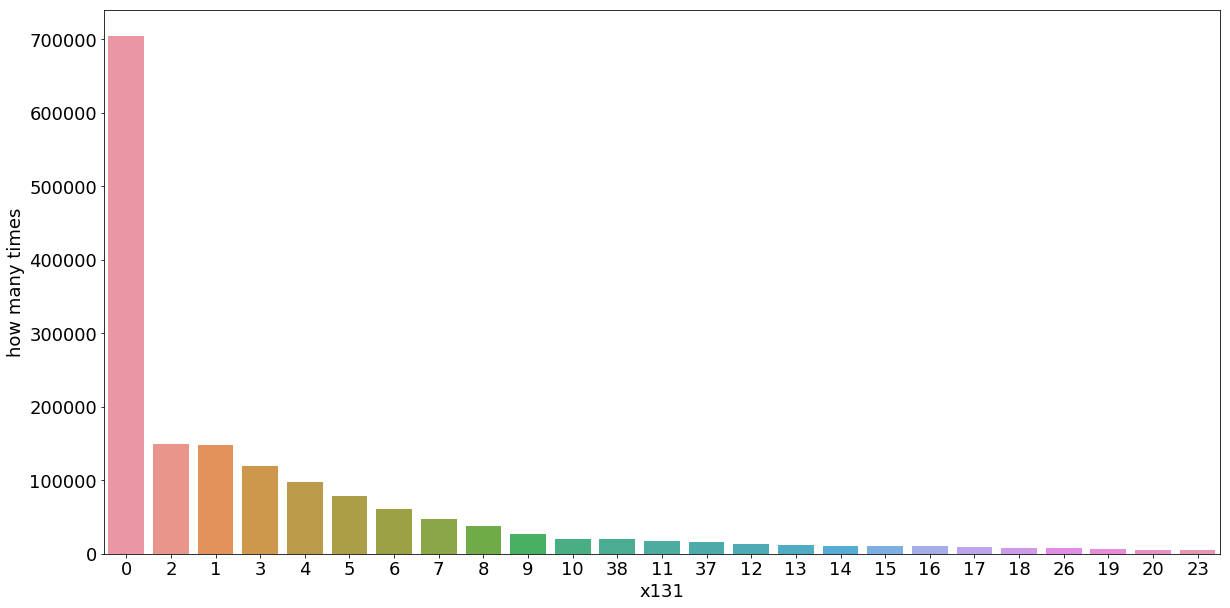

count    1700000.000000
mean     4.809295      
std      8.966942      
min      0.000000      
25%      0.000000      
50%      1.000000      
75%      5.000000      
max      153.000000    
Name: x131, dtype: object




Variable x133 has 158 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

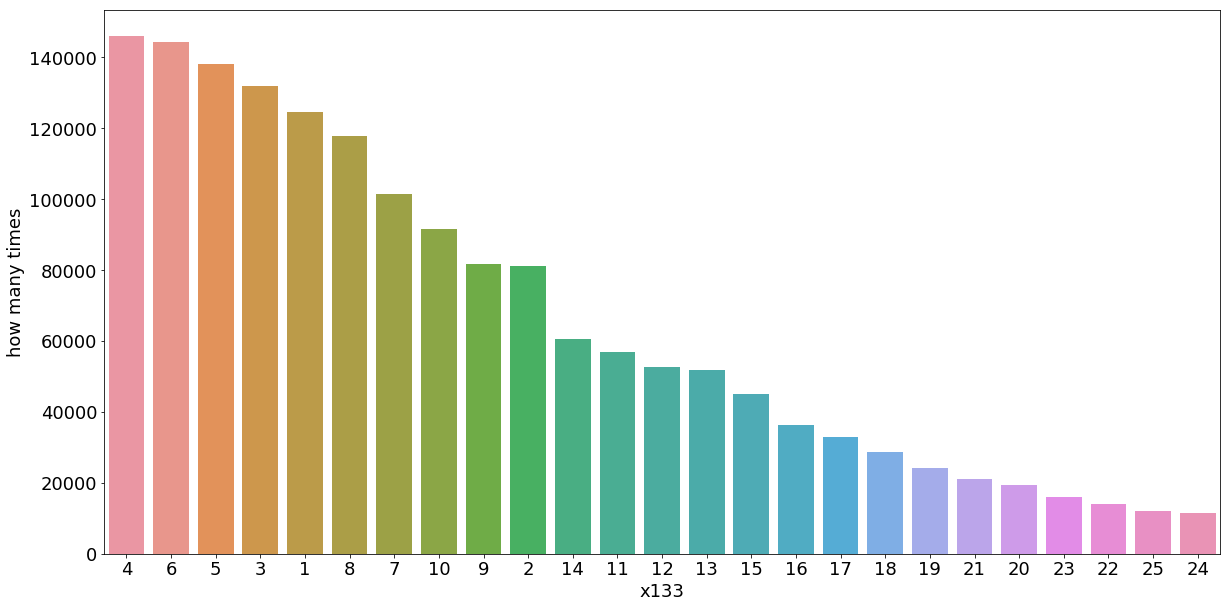

count    1700000.000000
mean     9.301809      
std      7.725215      
min      0.000000      
25%      4.000000      
50%      7.000000      
75%      13.000000     
max      301.000000    
Name: x133, dtype: object




Variable x134 has 110 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

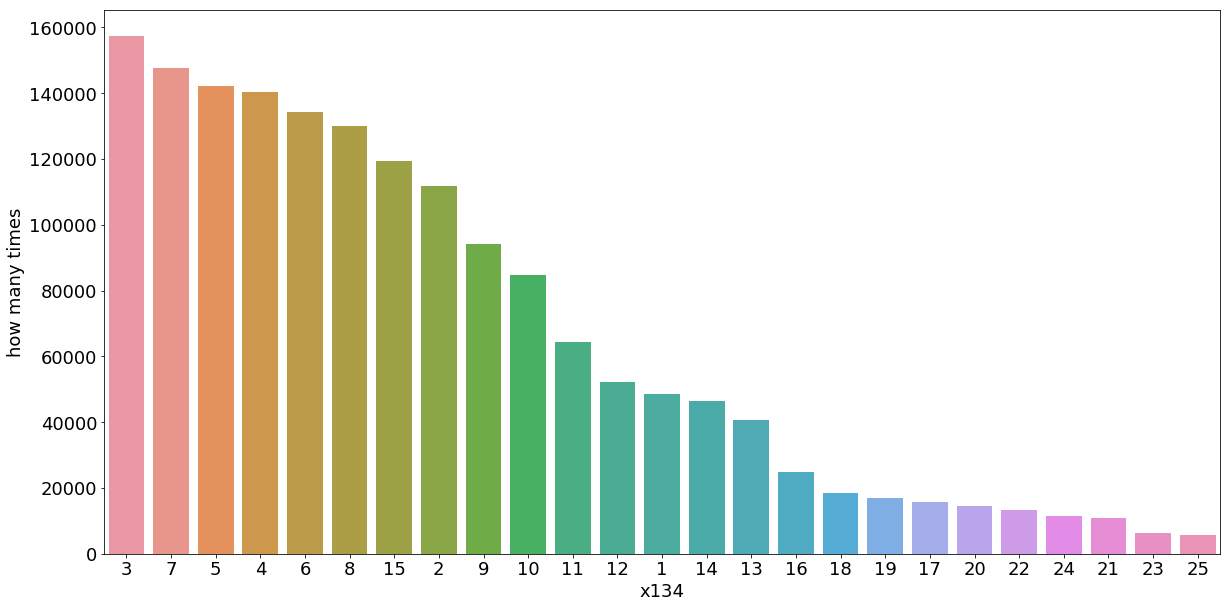

count    1700000.000000
mean     8.842868      
std      6.665332      
min      0.000000      
25%      4.000000      
50%      7.000000      
75%      12.000000     
max      219.000000    
Name: x134, dtype: object




Variable x138 has 500 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

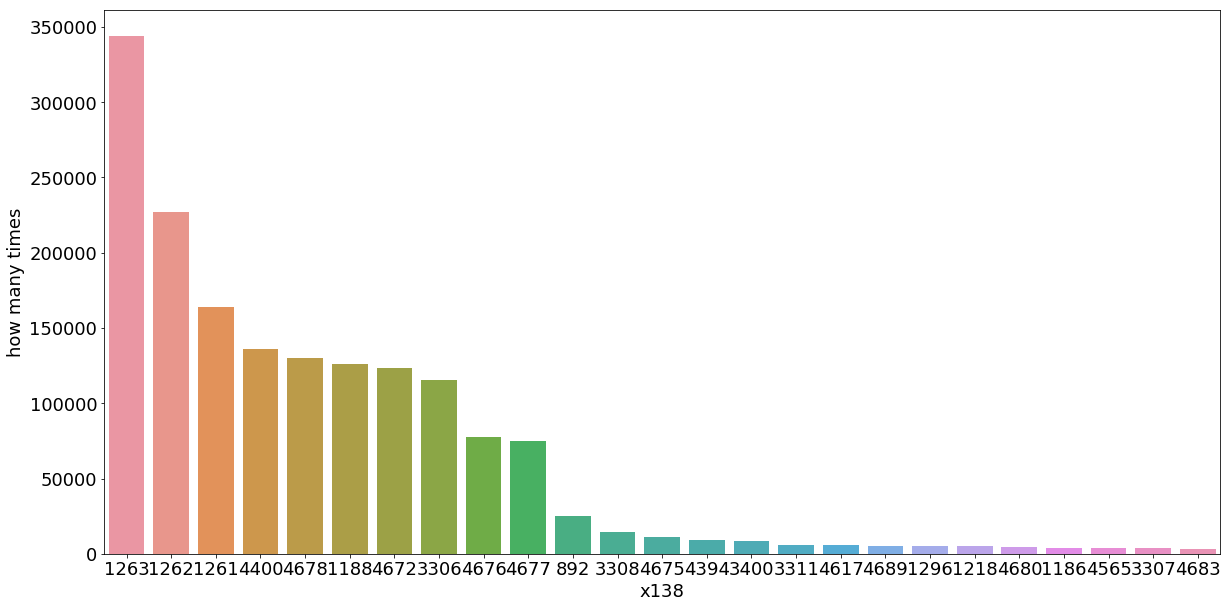

count    1700000.000000
mean     2688.457461   
std      1591.809367   
min      0.000000      
25%      1262.000000   
50%      1263.000000   
75%      4672.000000   
max      19500.000000  
Name: x138, dtype: object




Variable x139 has 420 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

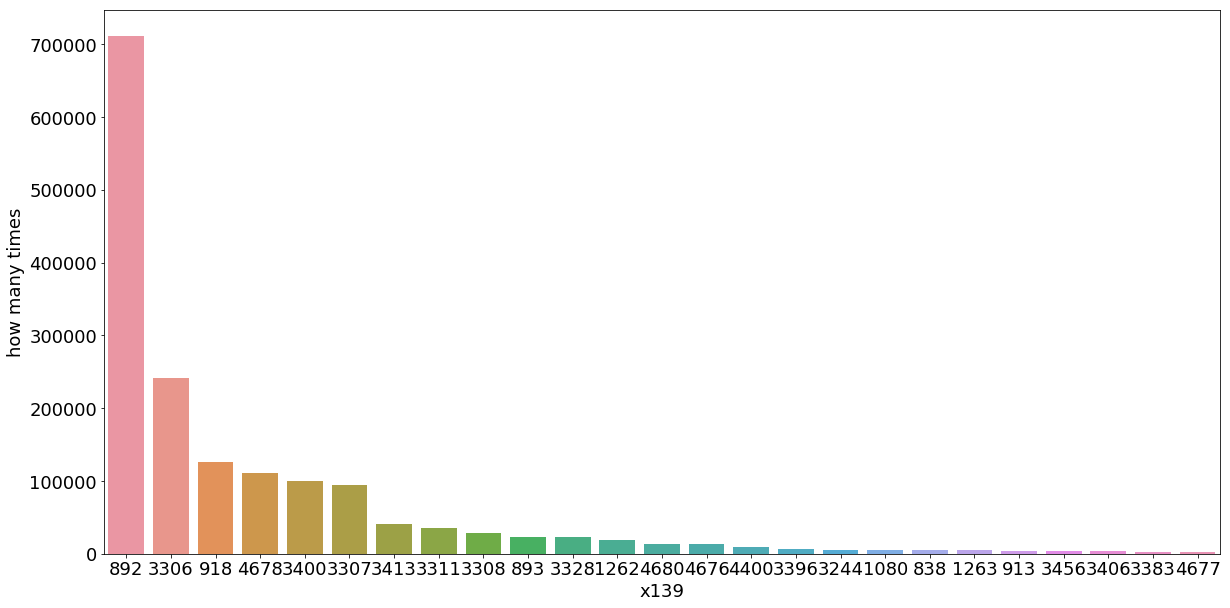

count    1700000.000000
mean     2163.422956   
std      1392.787044   
min      0.000000      
25%      892.000000    
50%      918.000000    
75%      3308.000000   
max      14167.000000  
Name: x139, dtype: object




Variable x143 has 493 different values
Ploting only the 25 largest values


<Figure size 432x288 with 0 Axes>

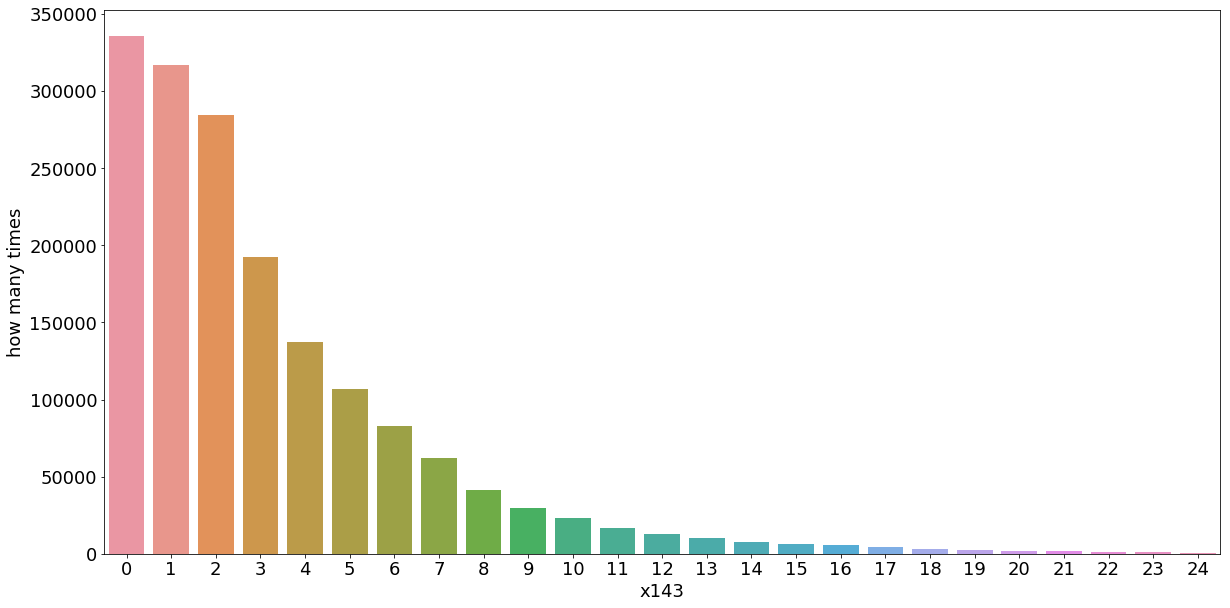

count    1700000.000000
mean     3.632134      
std      9.424120      
min      -1.000000     
25%      1.000000      
50%      2.000000      
75%      5.000000      
max      1219.000000   
Name: x143, dtype: object






In [27]:
for v in int_features:
    feature = train_features[v]
    print("Variable {} has {} different values".format(v, feature.value_counts().shape[0]))
    print("Ploting only the 25 largest values")
    pl.categorical(train_features, v)
    print(feature.describe().apply(lambda x: format(x, 'f')))
    print('\n\n\n')
    

The numerical int variables show three different kinds of patterns: a 25% on 892, a 50% on 1263 and the rest that feel likes quantitative variables. I will classify the first as the height category, the second as the width category and the third as quantitative category.

In [6]:
meta.at[['x23', 'x54', 'x84', 'x114', 'x139'], 'category'] = 'height'
meta.at[['x22', 'x53', 'x83', 'x113', 'x138'], 'category'] = 'width'
meta.at[['x15', 'x17', 'x18', 'x27', 'x46', 'x48', 'x49', 'x58', 'x76', 'x78', 'x79', 'x88', 'x106', 'x108', 'x109', 'x118', 'x131', 'x133', 'x134', 'x143'], 'category'] = 'quantitative'
meta[(meta.category == 'width')]

,role,category,dtype
varname,,,
x22,input,width,int64
x53,input,width,int64
x83,input,width,int64
x113,input,width,int64
x138,input,width,int64


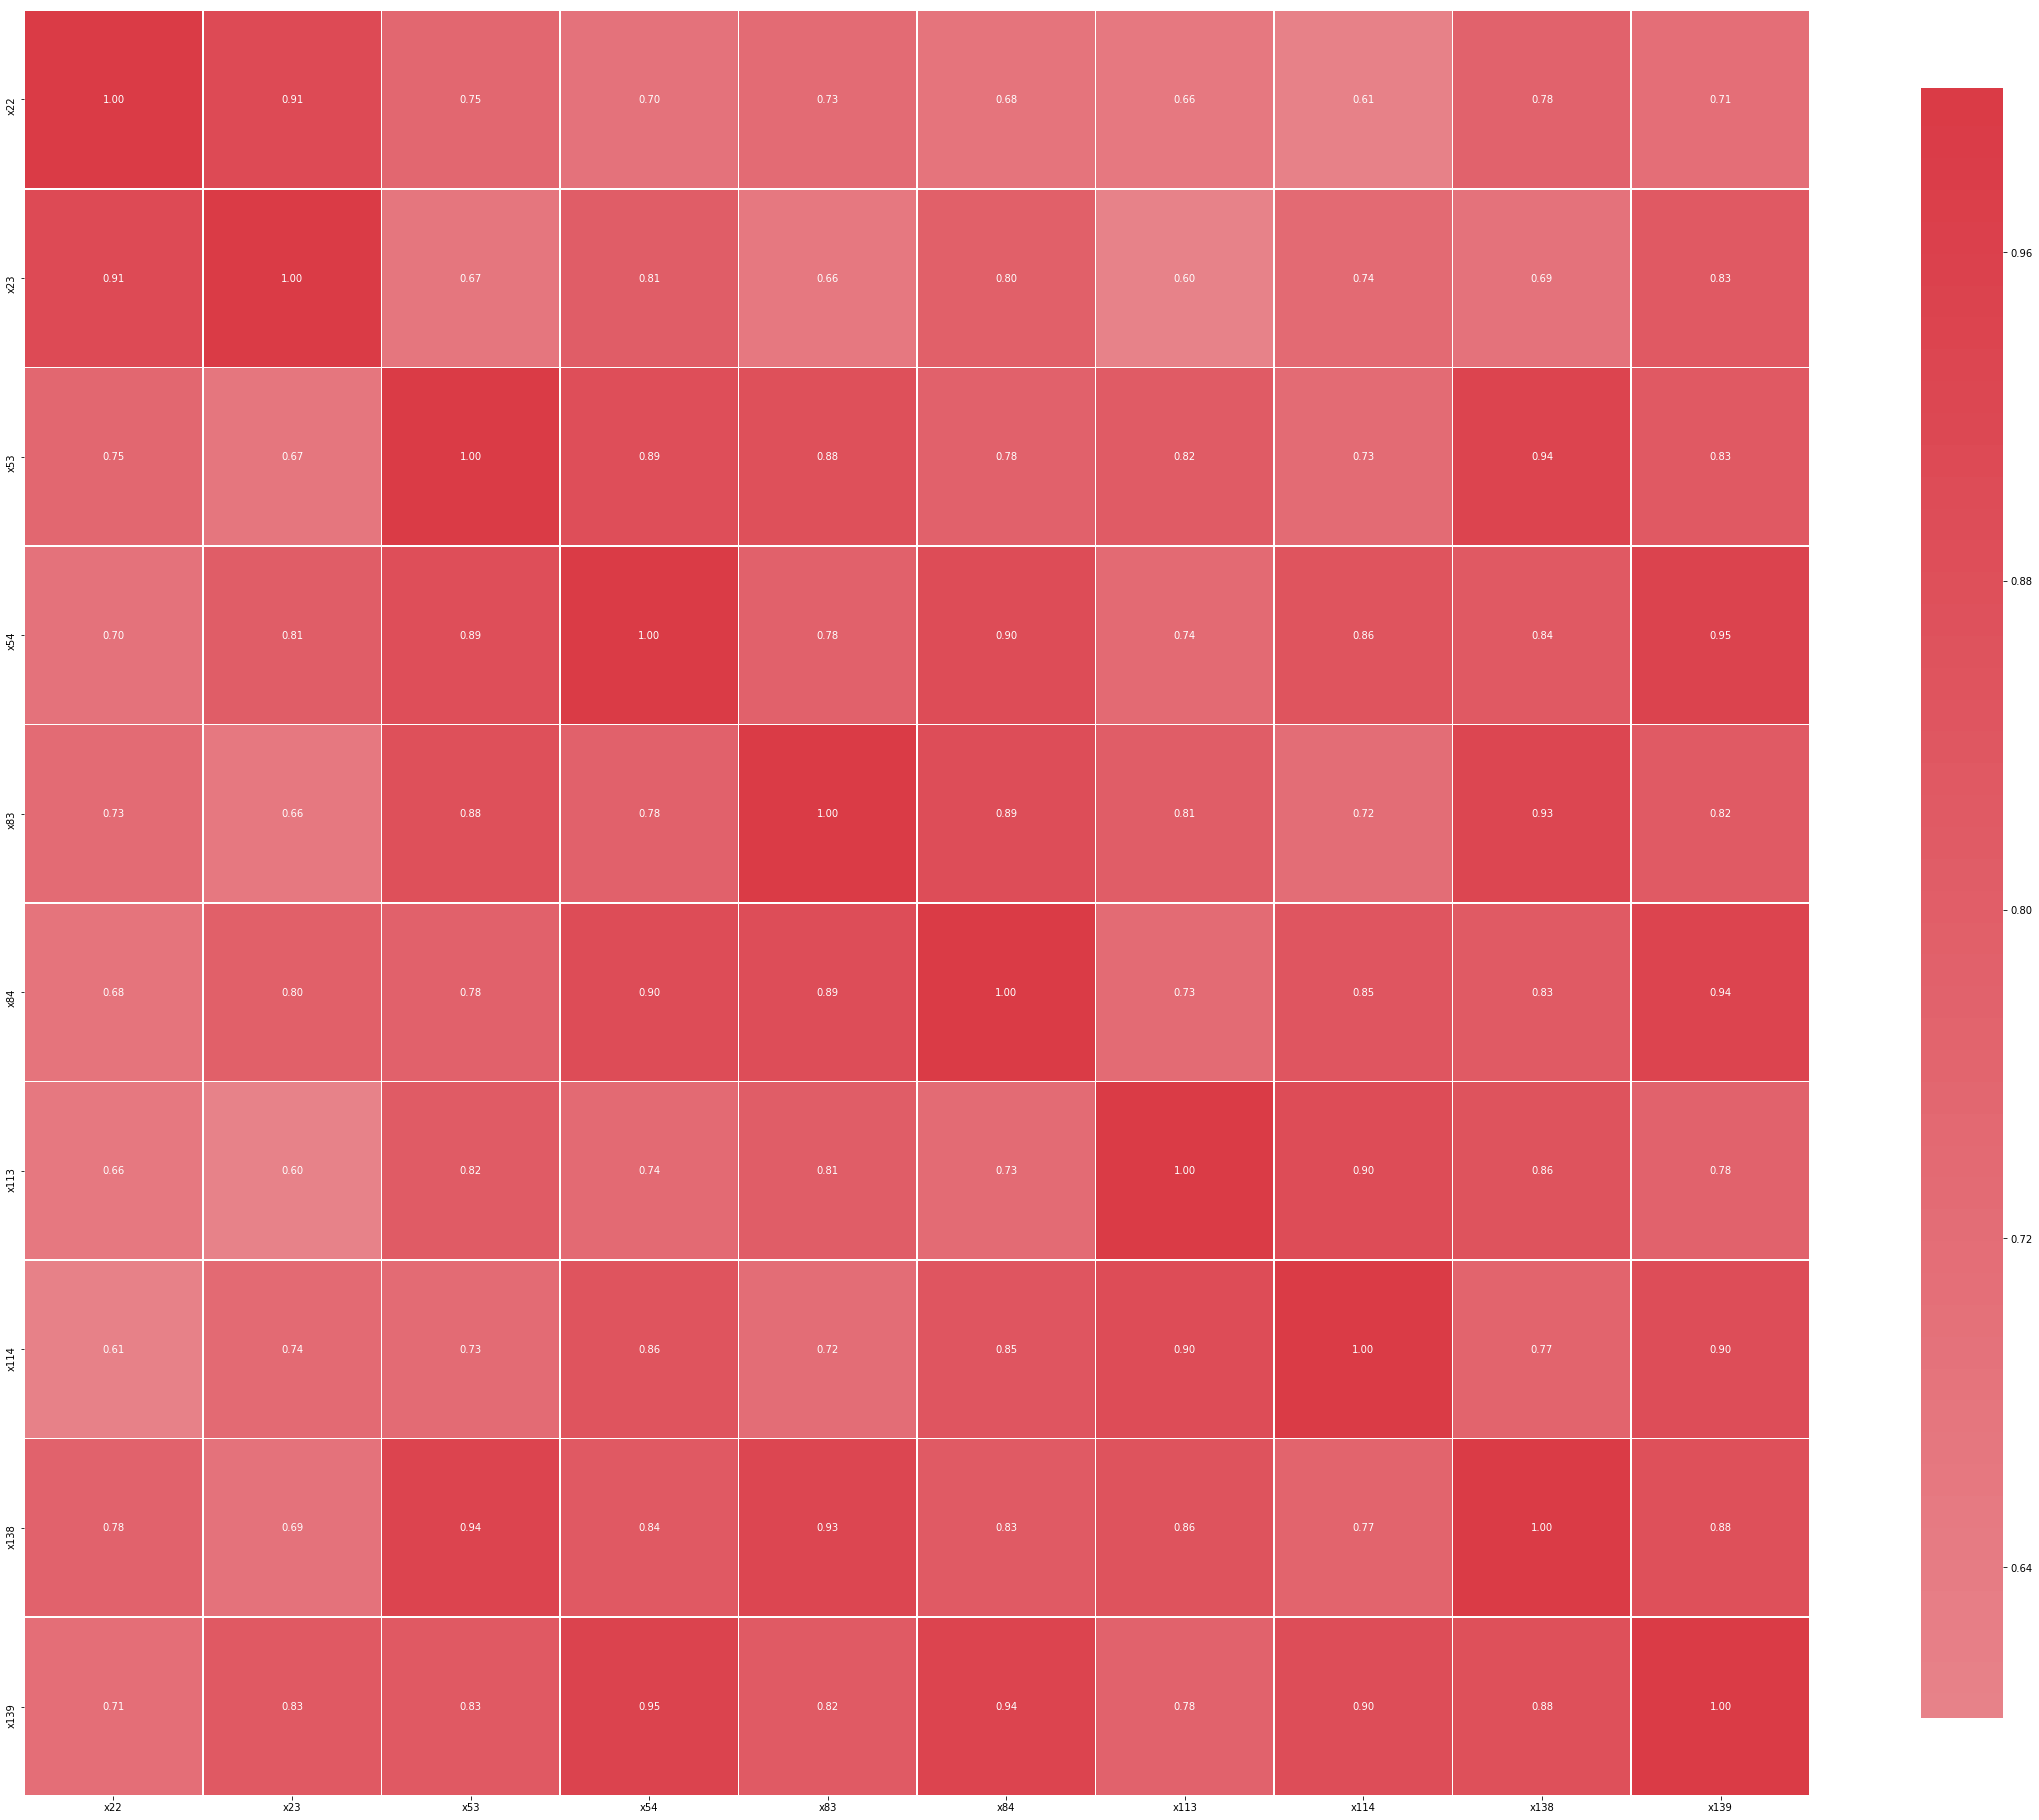

In [34]:
pl.correlation_map(train_features, meta[(meta.category == 'height') | (meta.category == 'width')].index)

As I suspect, the correlation between the width and height category is very linear.

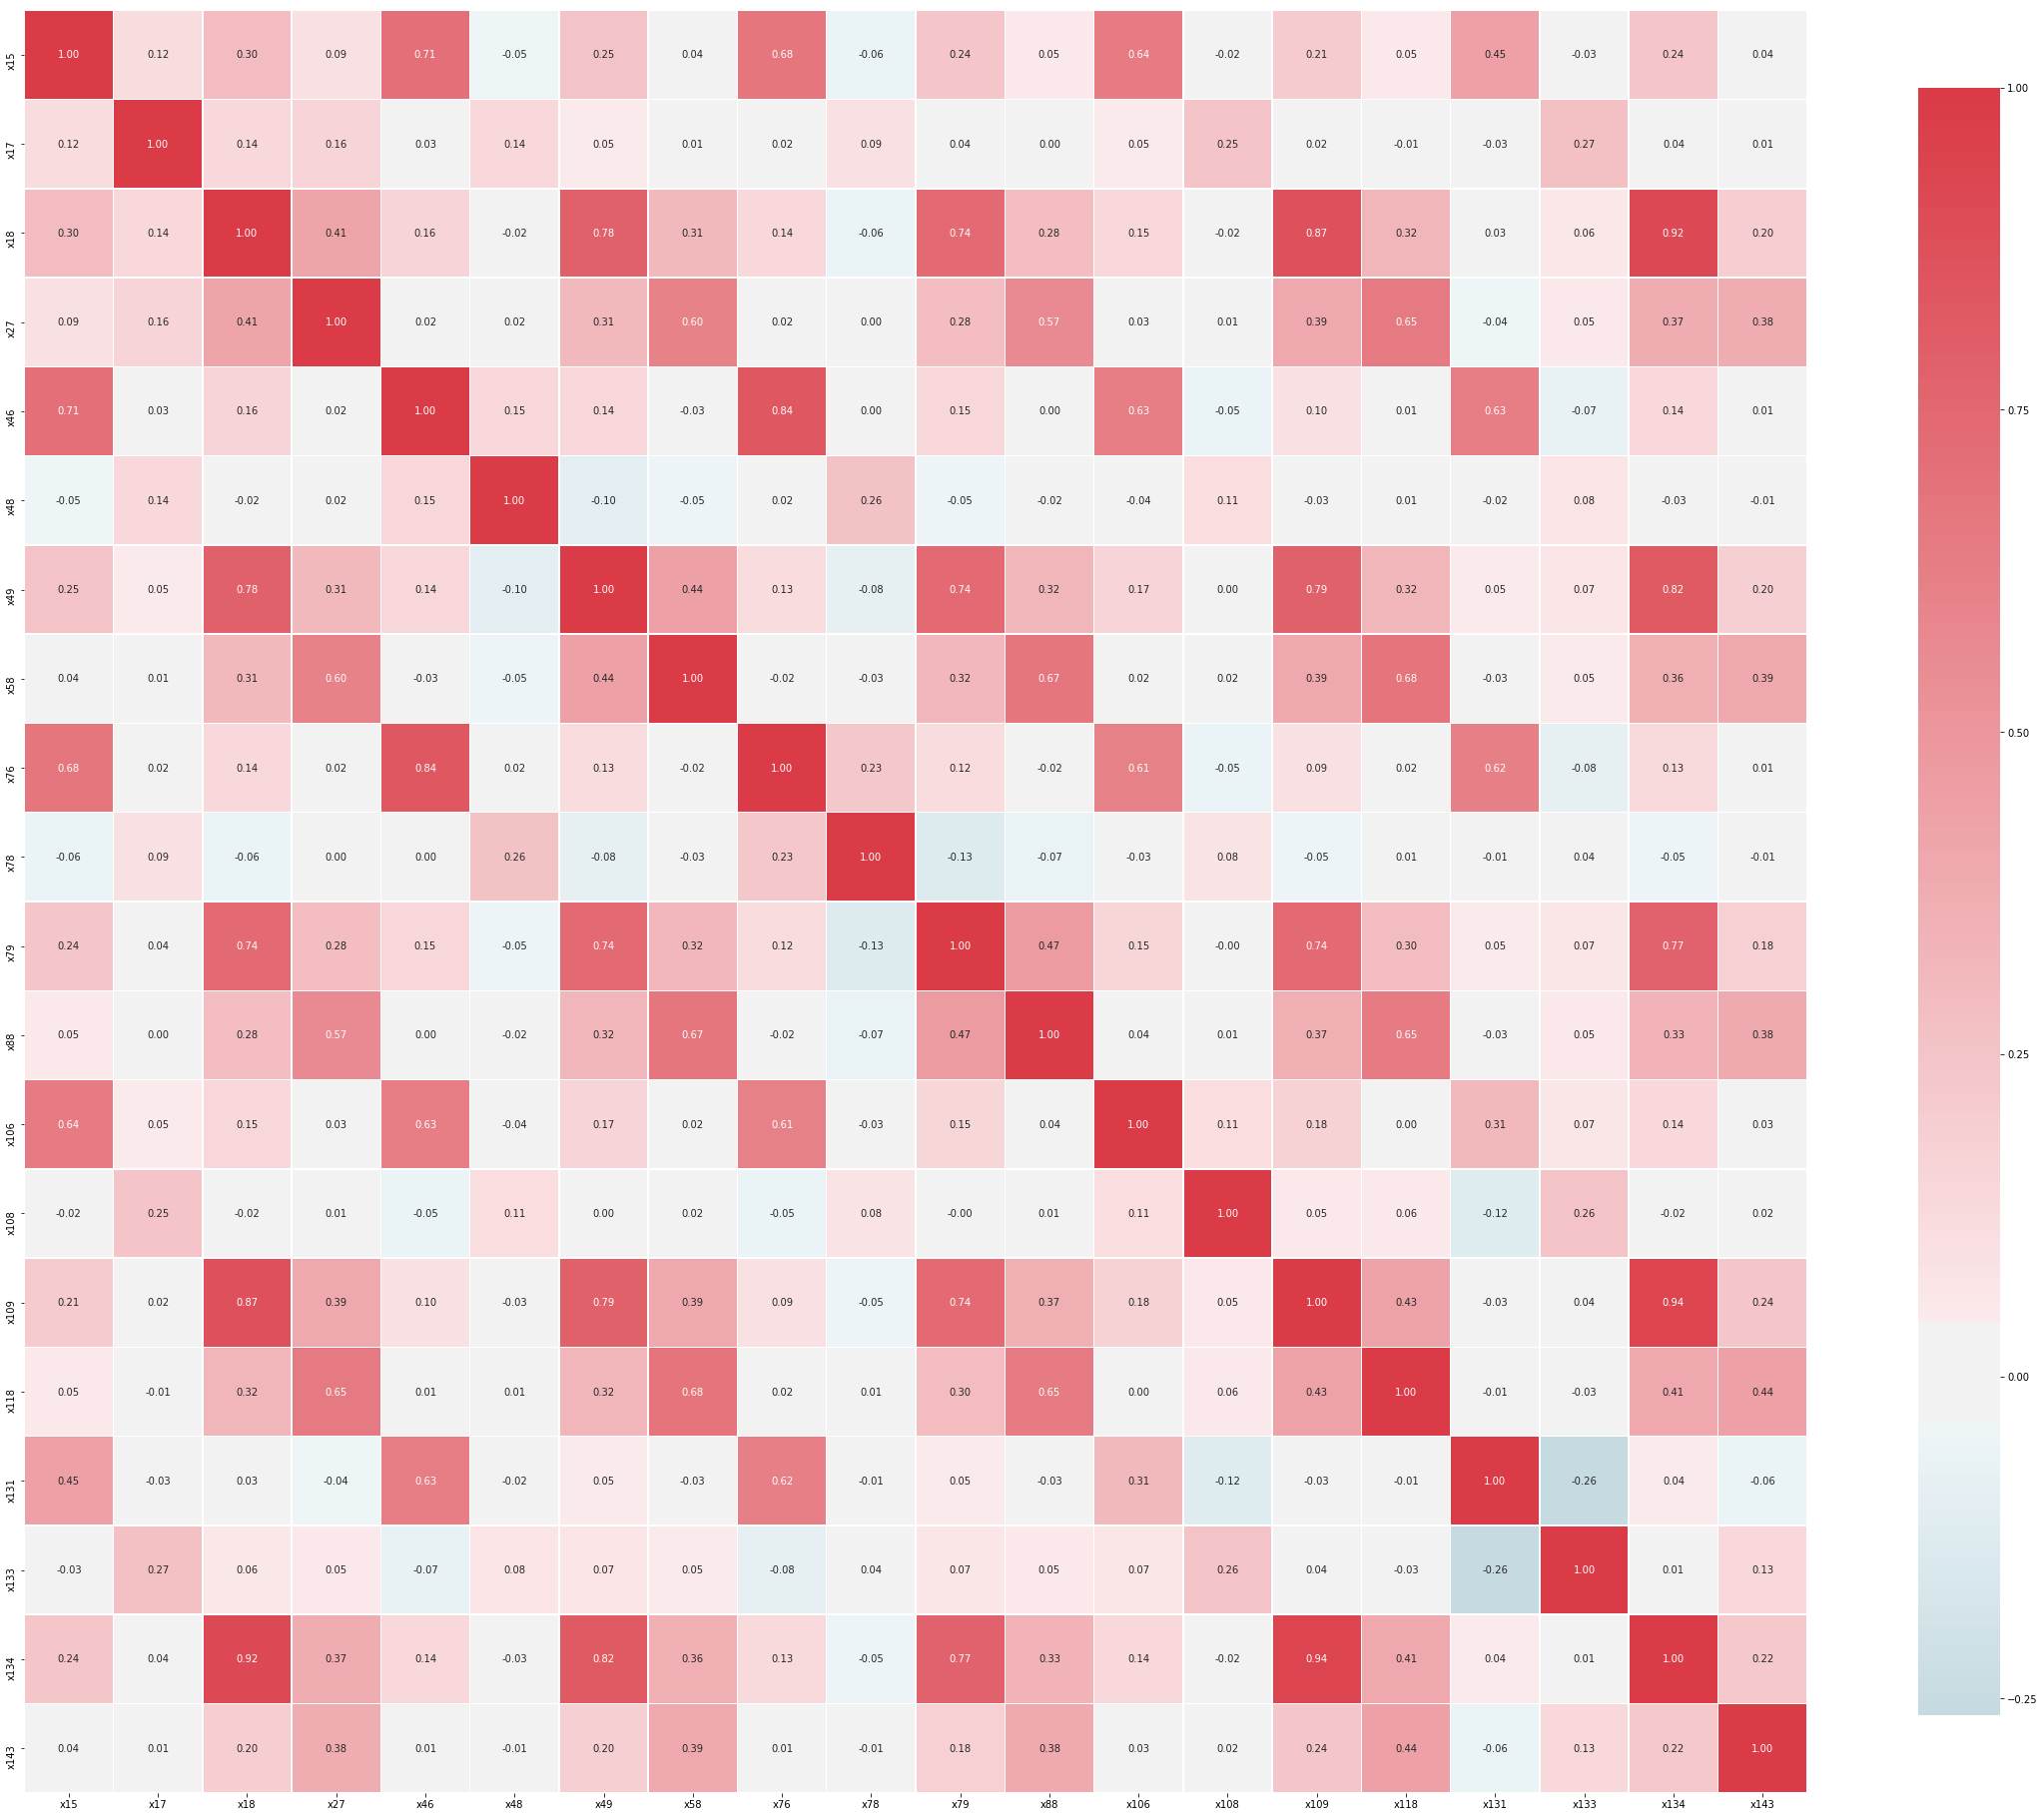

In [35]:
pl.correlation_map(train_features, meta[(meta.category == 'quantitative')].index)

In [16]:
pca_features = train_features.sample(frac=0.5)
pca = PCA(n_components=5)
pca.fit(pca_features[meta[(meta.category == 'height') | (meta.category == 'width')].index])
[ "{:0.5f}".format(x) for x in pca.explained_variance_ratio_ ]

['0.81348', '0.07019', '0.05062', '0.03623', '0.02164']

As component principal analysis with 5 components can explain 99,21% of the variance in the height/width part of the dataset, this can be used in the implementation part of the algorithms.

In [23]:
pca_features = train_features.sample(frac=0.5)
pca = PCA(n_components=10)
pca.fit(pca_features[meta[(meta.category == 'quantitative')].index])
[ "{:0.5f}".format(x) for x in pca.explained_variance_ratio_ ]

['0.30023',
 '0.18144',
 '0.12165',
 '0.07665',
 '0.06814',
 '0.06394',
 '0.03789',
 '0.02542',
 '0.02390',
 '0.02135']

As component principal analysis with 10 components can explain 92,06% of the variance in the quantitative part of the dataset, this can be used in the implementation part of the algorithms.

#### Numerical float variables <a class="anchor" id="float_variables"></a> 

Checking the correlations between interval variables. A heatmap is a good way to visualize the correlation between variables. 

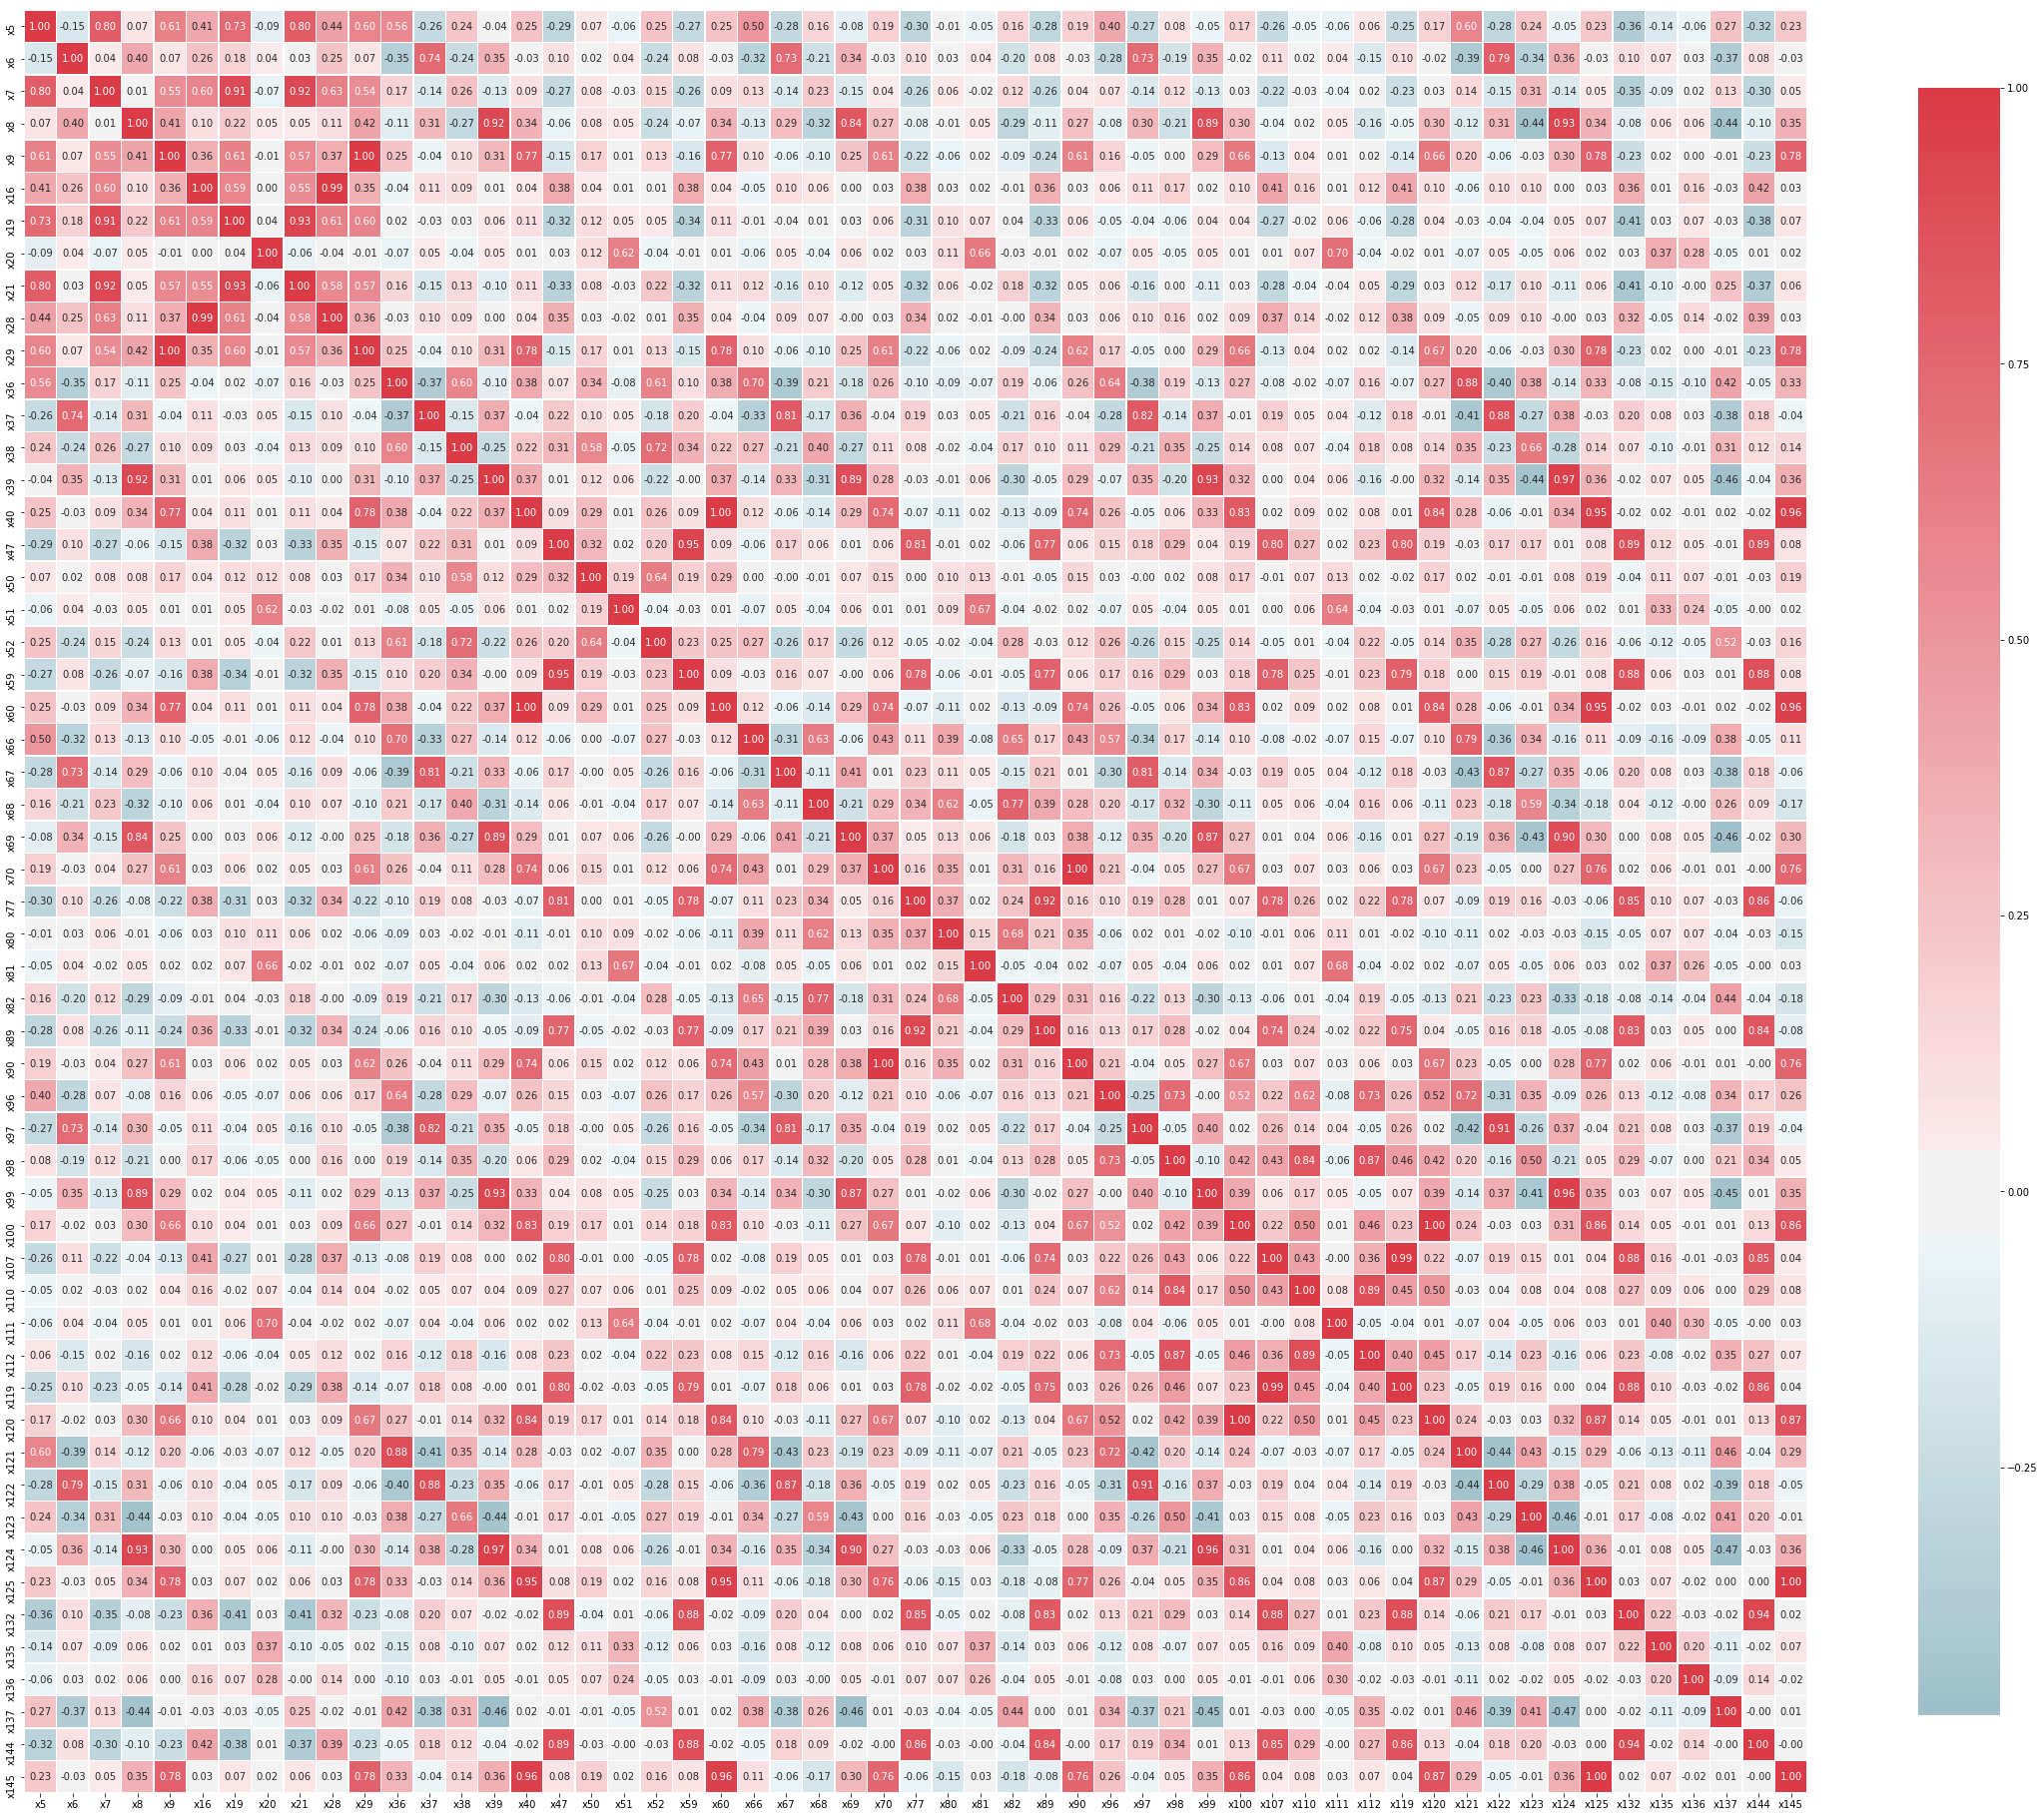

In [32]:
pl.correlation_map(train_features, float_features)

As we can see, that has many features with a nice linear correlation, which can make this part of the dataset a good call for a PCA to see how much the component analysis can explain the linear correlation.

In [12]:
pca_features = train_features.sample(frac=0.5)
pca = PCA(n_components=10)
pca.fit(pca_features[(float_features)])
[ "{:0.5f}".format(x) for x in pca.explained_variance_ratio_ ]

['0.32163',
 '0.13221',
 '0.10925',
 '0.09541',
 '0.09278',
 '0.05833',
 '0.03506',
 '0.03238',
 '0.02477',
 '0.01815']

As component principal analysis with 10 components can explain 91.99% of the variance in the float part of the dataset, this can be used in the implementation part of the algorithms.

#### Boolean variables <a class="anchor" id="boolean_variables"></a> 

<Figure size 432x288 with 0 Axes>

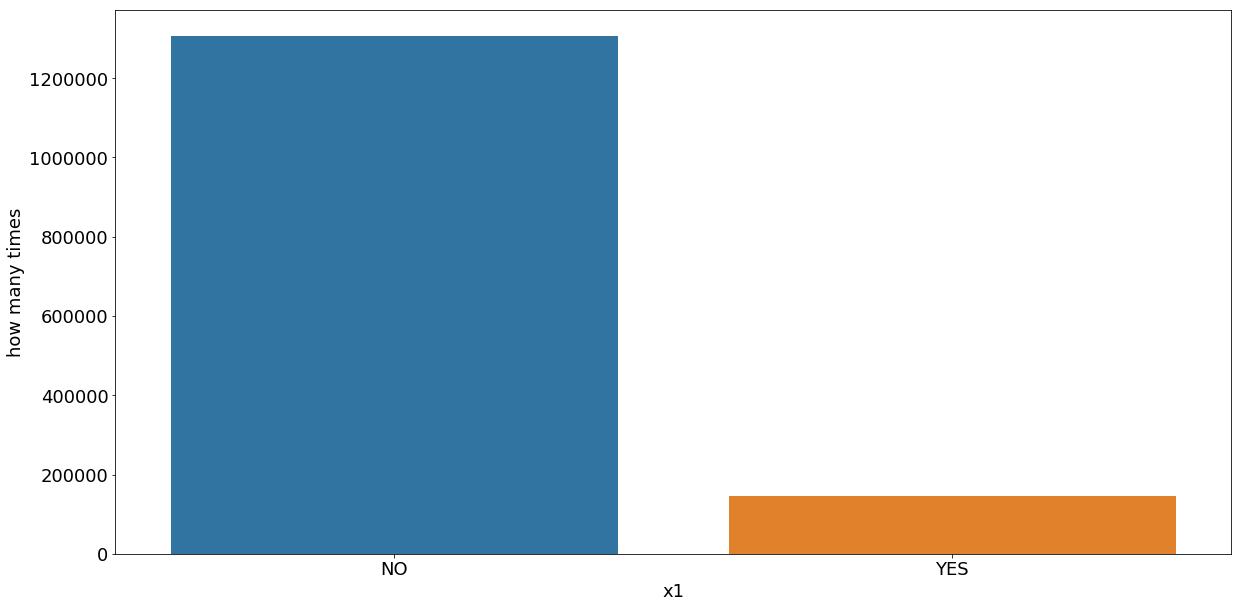

count     1451810
unique    2      
top       NO     
freq      1306048
Name: x1, dtype: object


<Figure size 432x288 with 0 Axes>

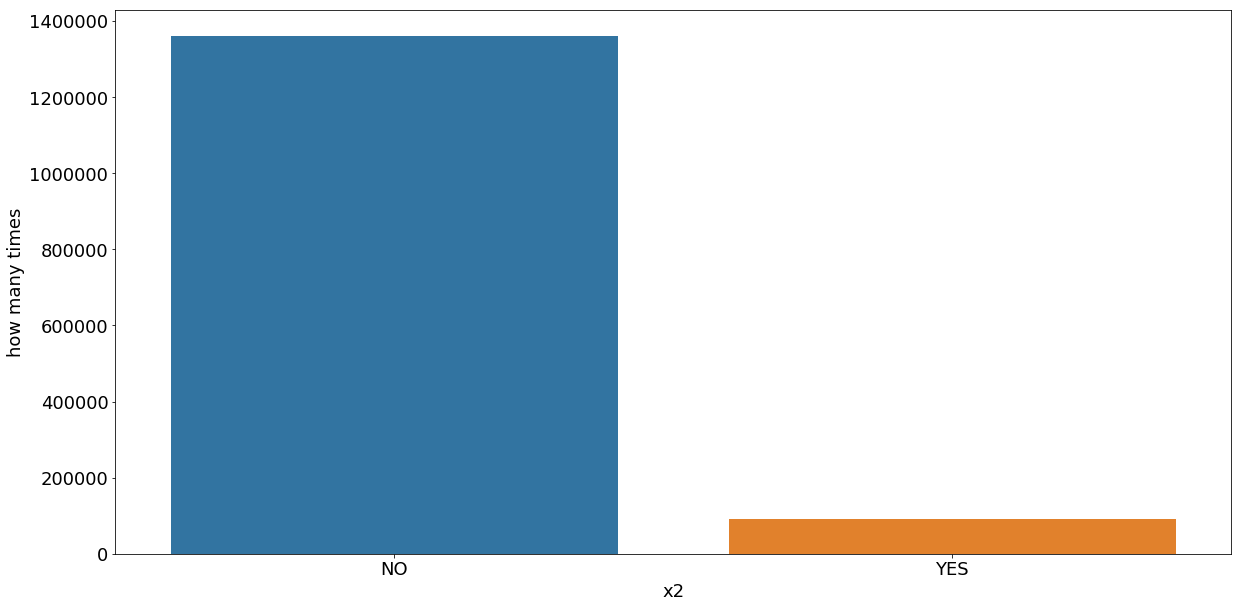

count     1451810
unique    2      
top       NO     
freq      1360034
Name: x2, dtype: object


<Figure size 432x288 with 0 Axes>

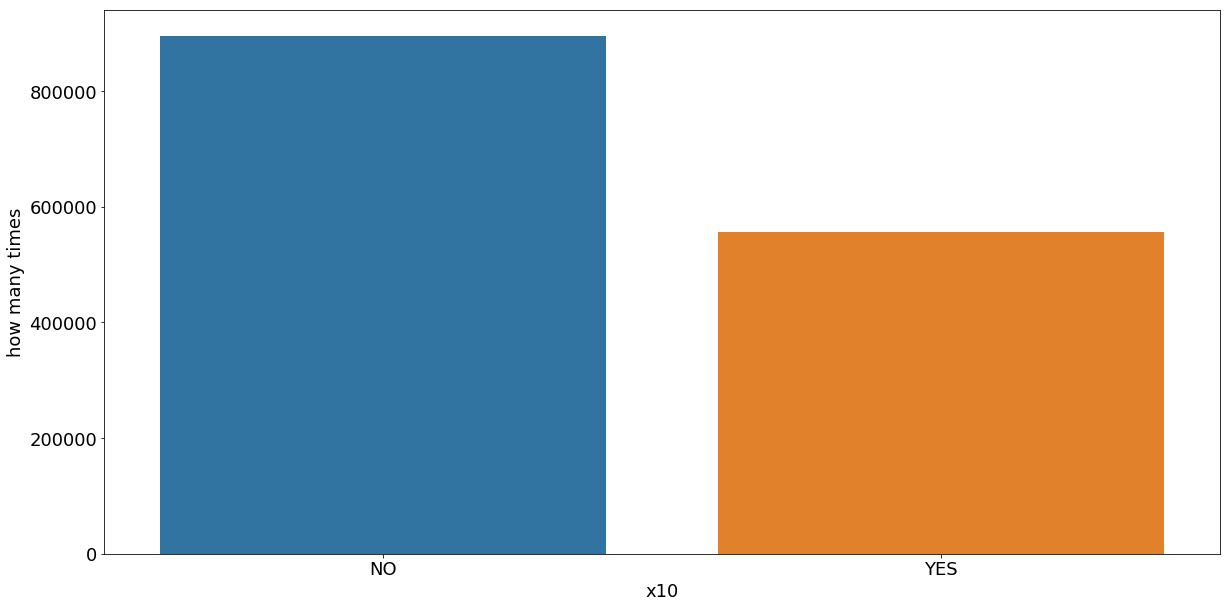

count     1451737
unique    2      
top       NO     
freq      895085 
Name: x10, dtype: object


<Figure size 432x288 with 0 Axes>

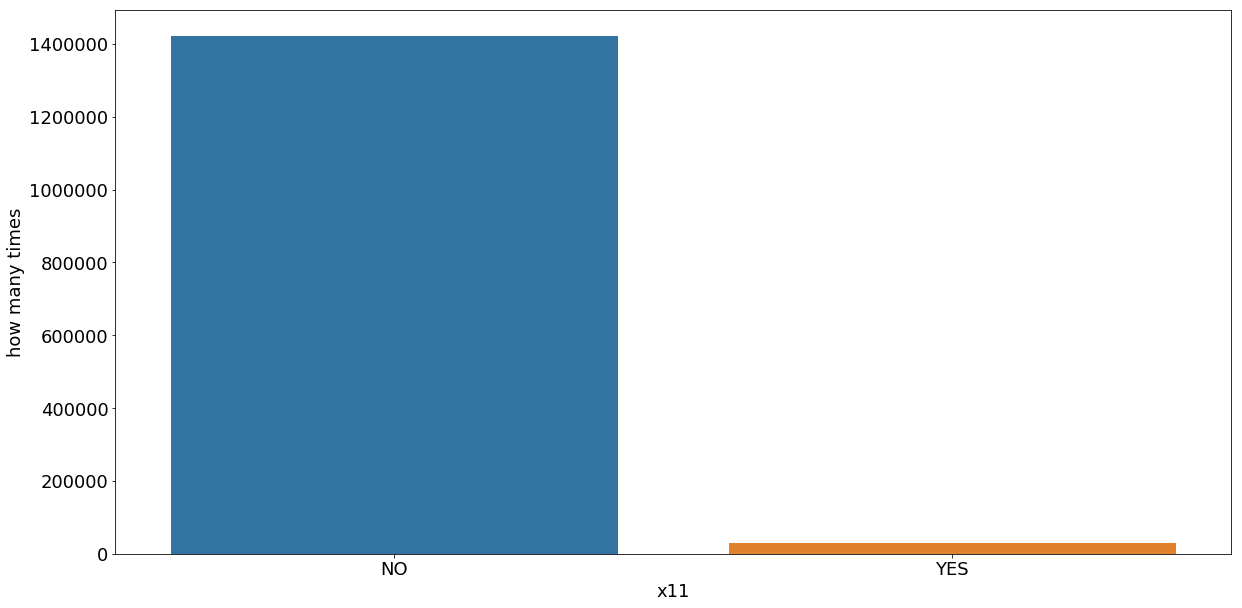

count     1451737
unique    2      
top       NO     
freq      1421672
Name: x11, dtype: object


<Figure size 432x288 with 0 Axes>

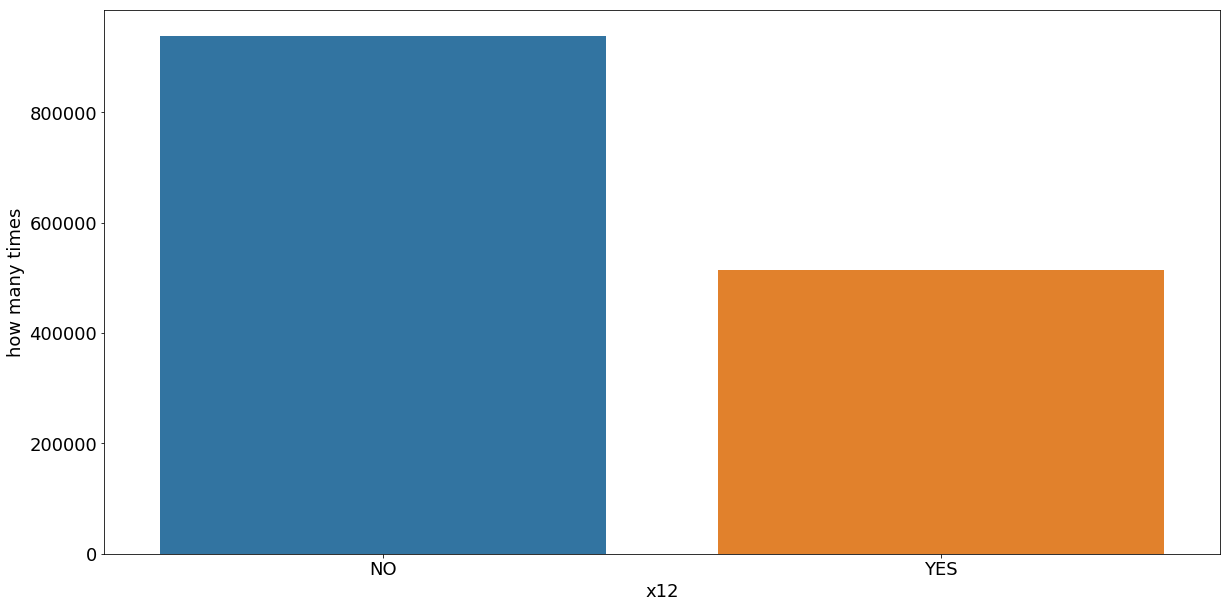

count     1451737
unique    2      
top       NO     
freq      937844 
Name: x12, dtype: object


<Figure size 432x288 with 0 Axes>

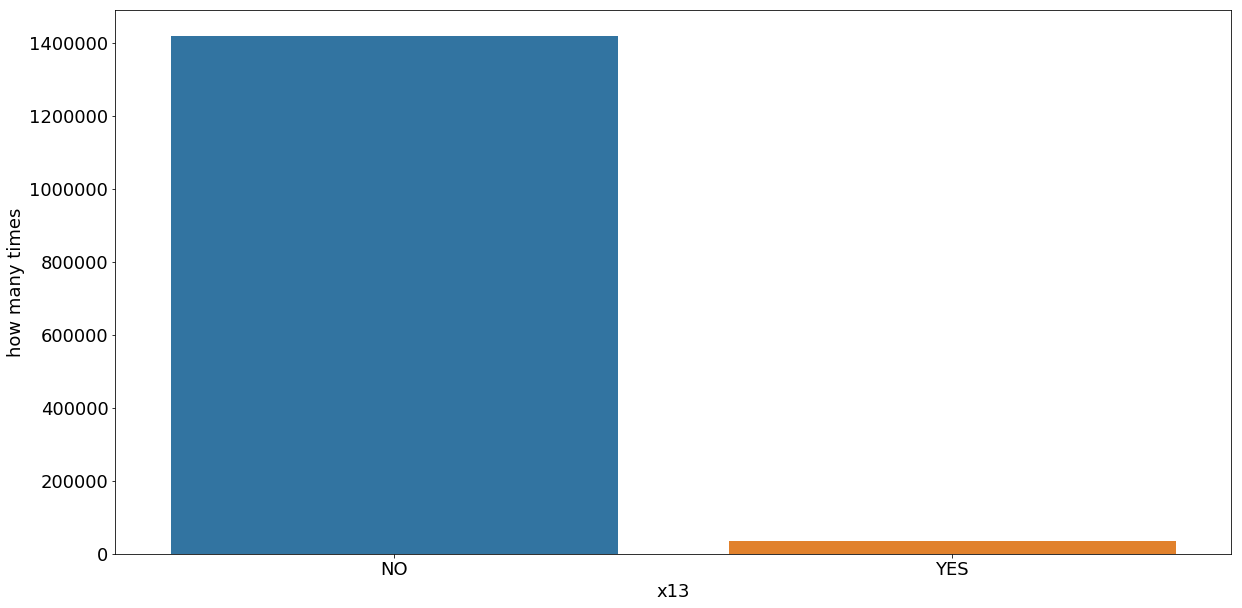

count     1451737
unique    2      
top       NO     
freq      1417787
Name: x13, dtype: object


<Figure size 432x288 with 0 Axes>

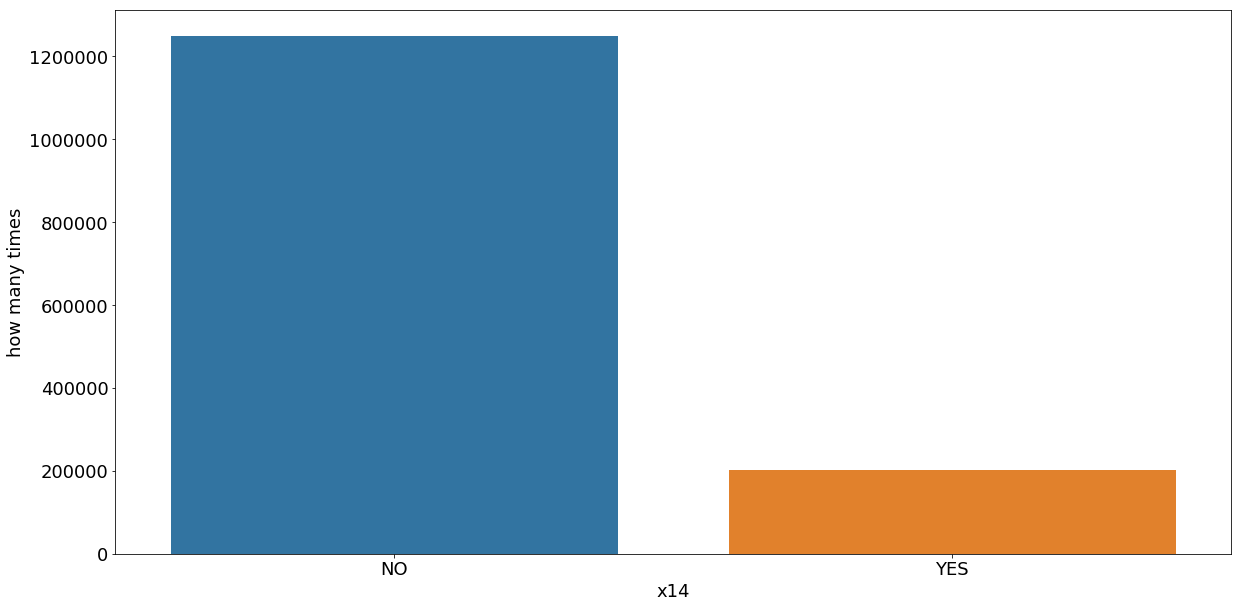

count     1451737
unique    2      
top       NO     
freq      1248943
Name: x14, dtype: object


<Figure size 432x288 with 0 Axes>

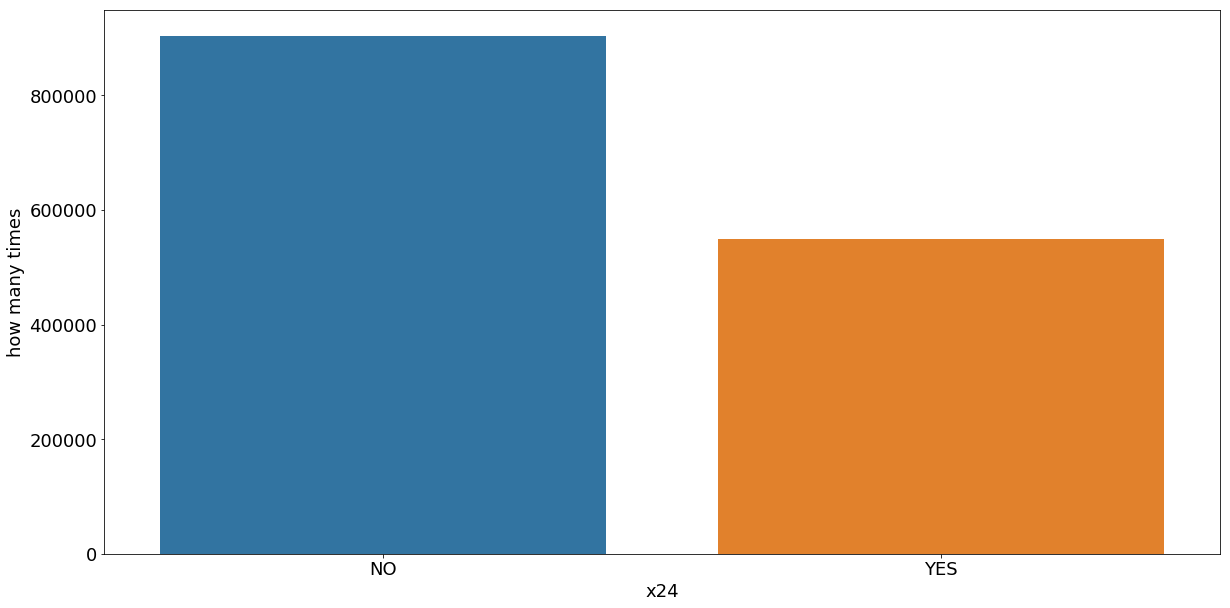

count     1451737
unique    2      
top       NO     
freq      903287 
Name: x24, dtype: object


<Figure size 432x288 with 0 Axes>

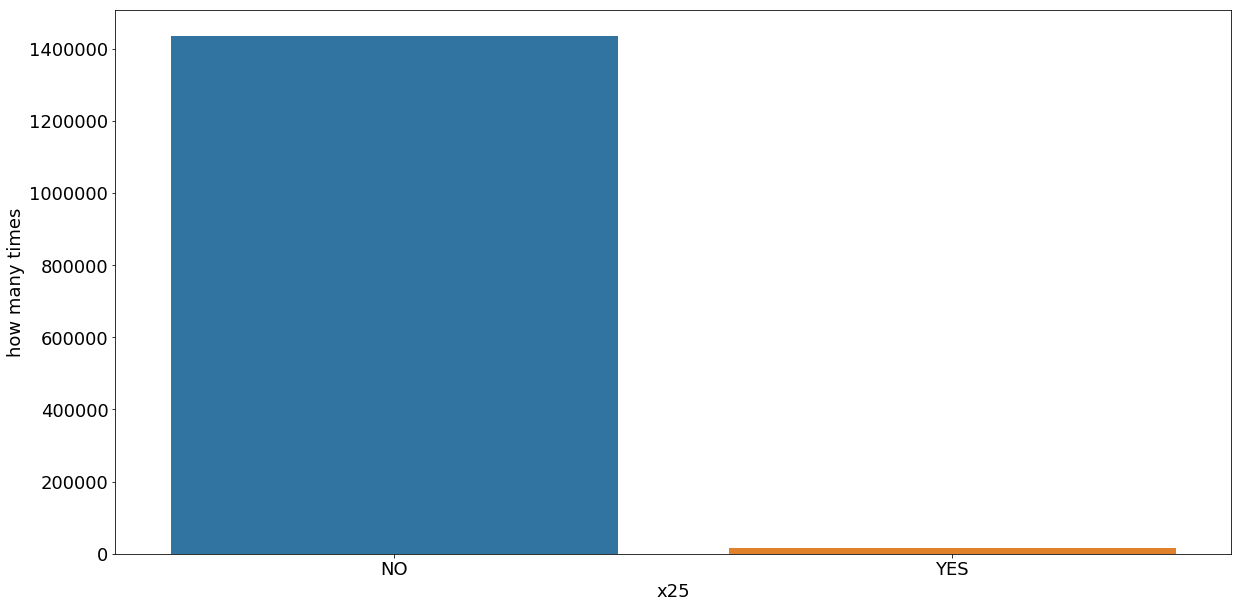

count     1451737
unique    2      
top       NO     
freq      1434703
Name: x25, dtype: object


<Figure size 432x288 with 0 Axes>

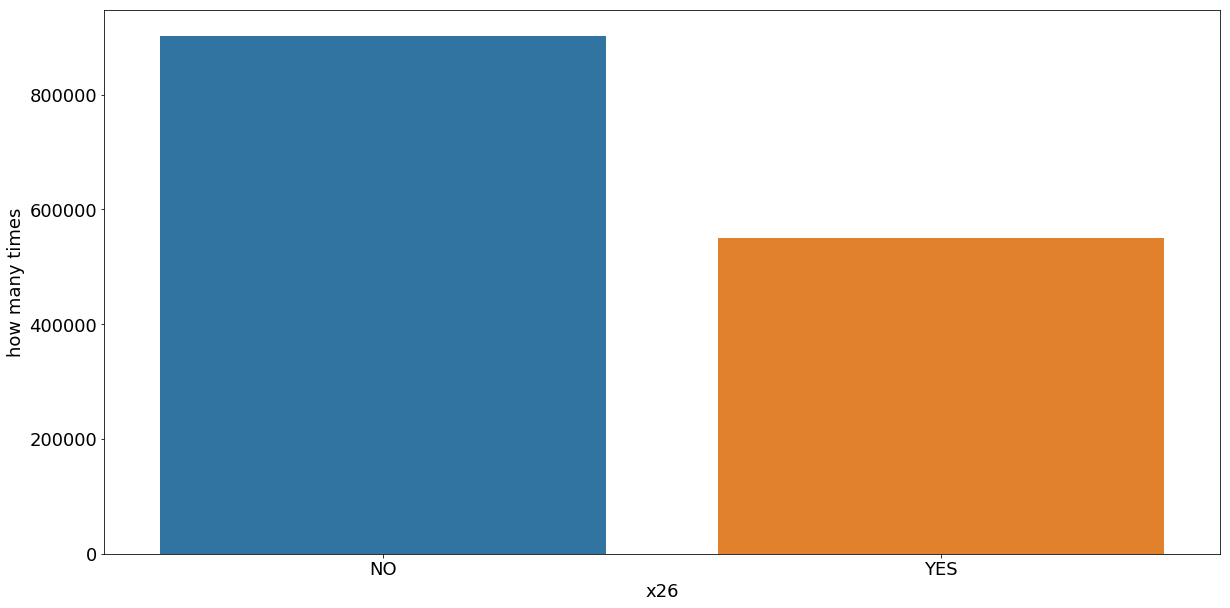

count     1451737
unique    2      
top       NO     
freq      901813 
Name: x26, dtype: object


<Figure size 432x288 with 0 Axes>

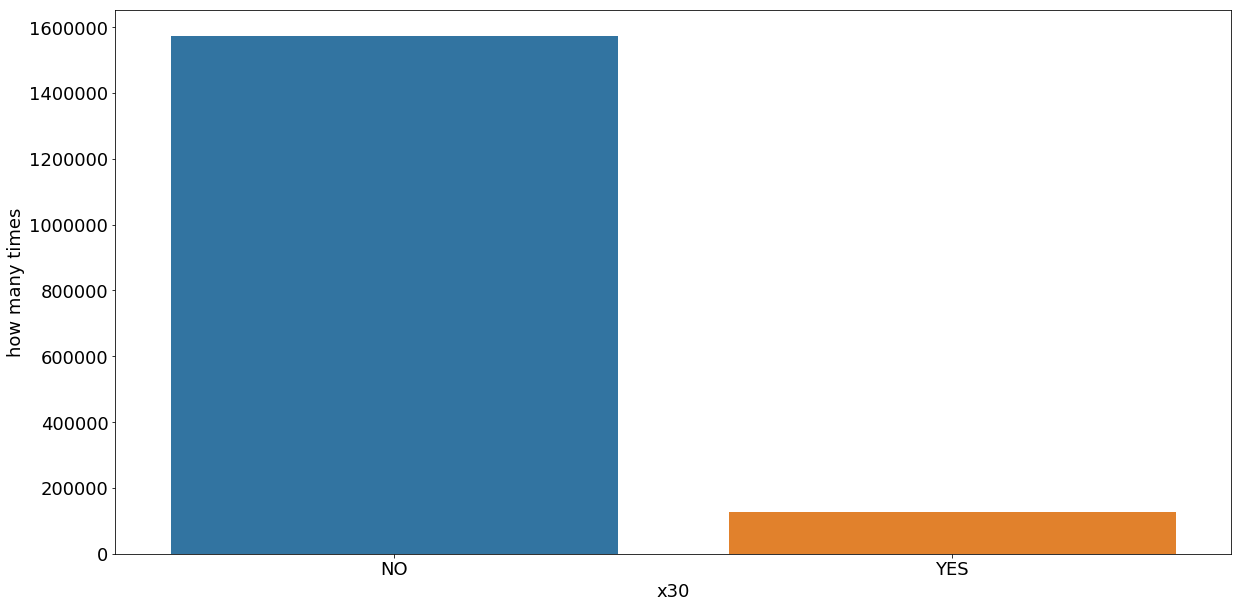

count     1700000
unique    2      
top       NO     
freq      1572446
Name: x30, dtype: object


<Figure size 432x288 with 0 Axes>

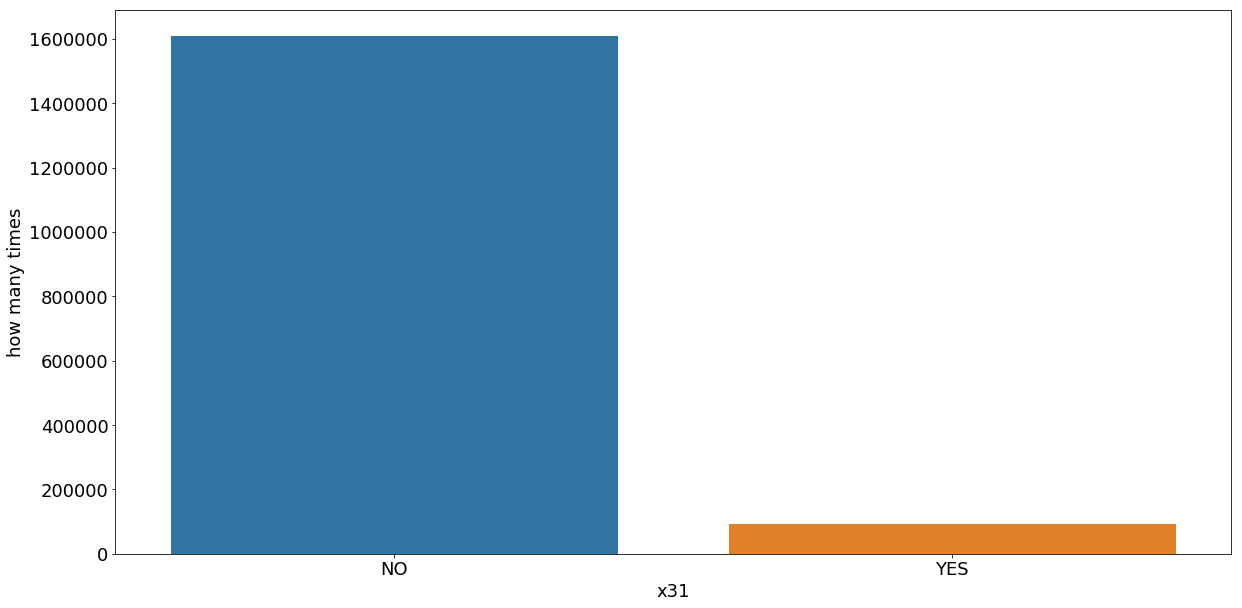

count     1700000
unique    2      
top       NO     
freq      1608242
Name: x31, dtype: object


<Figure size 432x288 with 0 Axes>

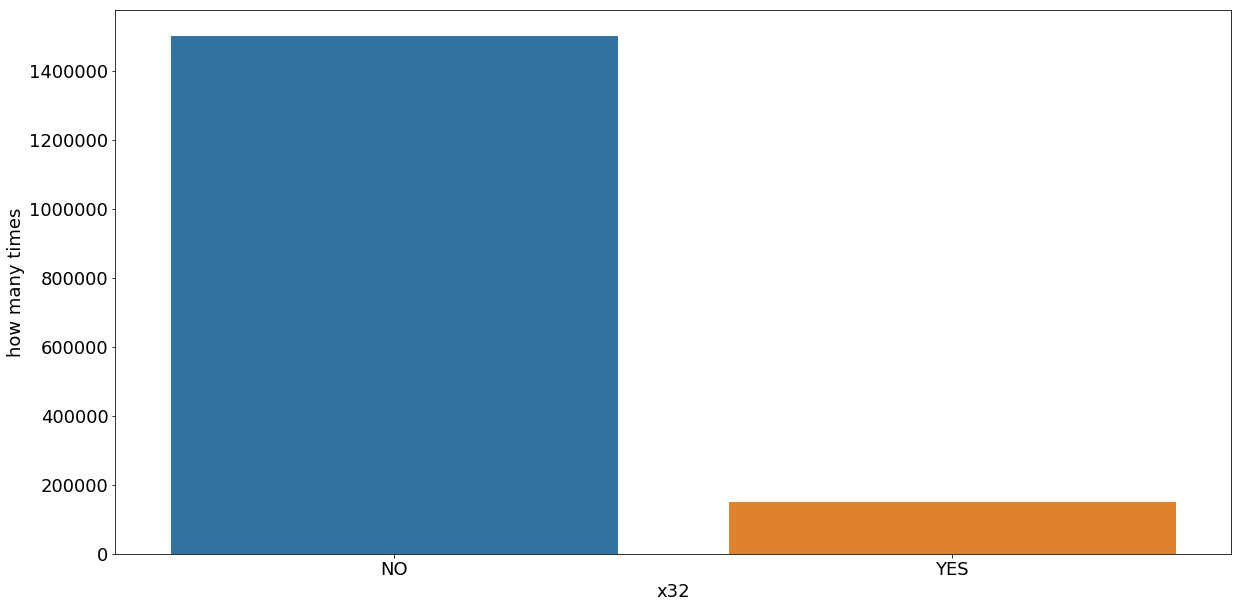

count     1649228
unique    2      
top       NO     
freq      1499709
Name: x32, dtype: object


<Figure size 432x288 with 0 Axes>

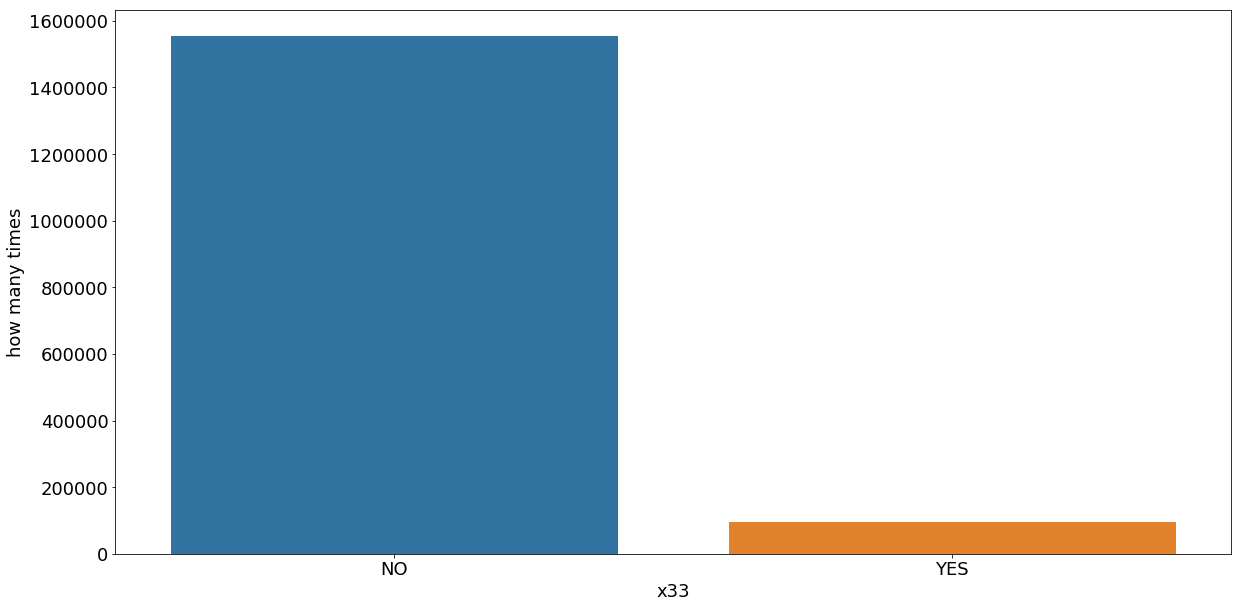

count     1649228
unique    2      
top       NO     
freq      1554186
Name: x33, dtype: object


<Figure size 432x288 with 0 Axes>

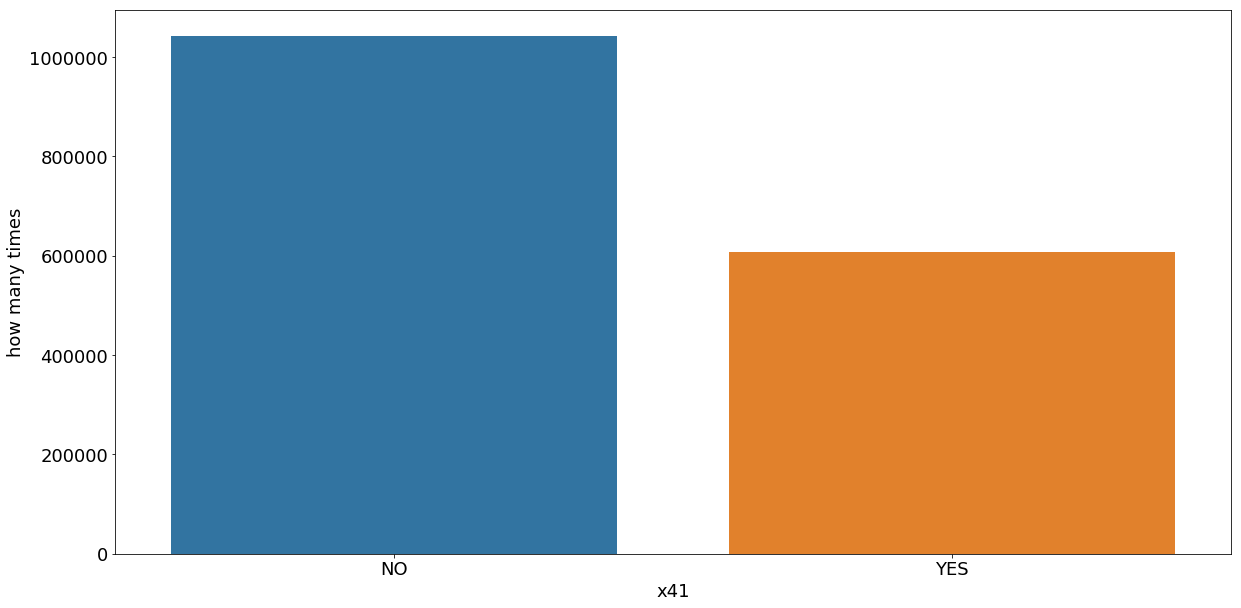

count     1649154
unique    2      
top       NO     
freq      1042290
Name: x41, dtype: object


<Figure size 432x288 with 0 Axes>

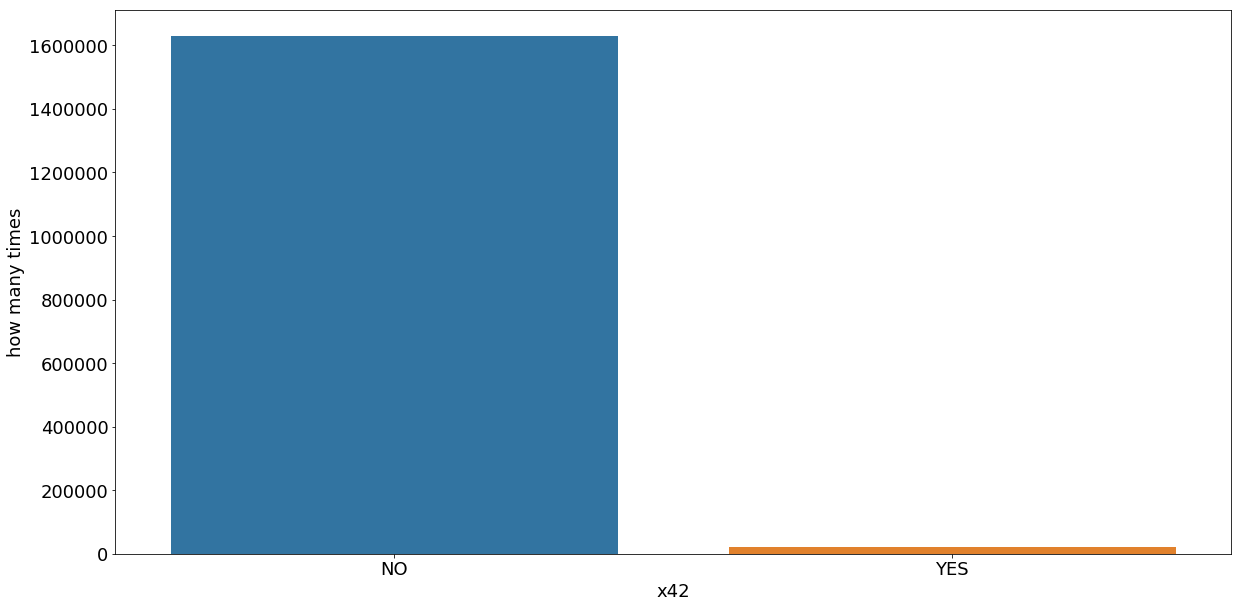

count     1649154
unique    2      
top       NO     
freq      1629261
Name: x42, dtype: object


<Figure size 432x288 with 0 Axes>

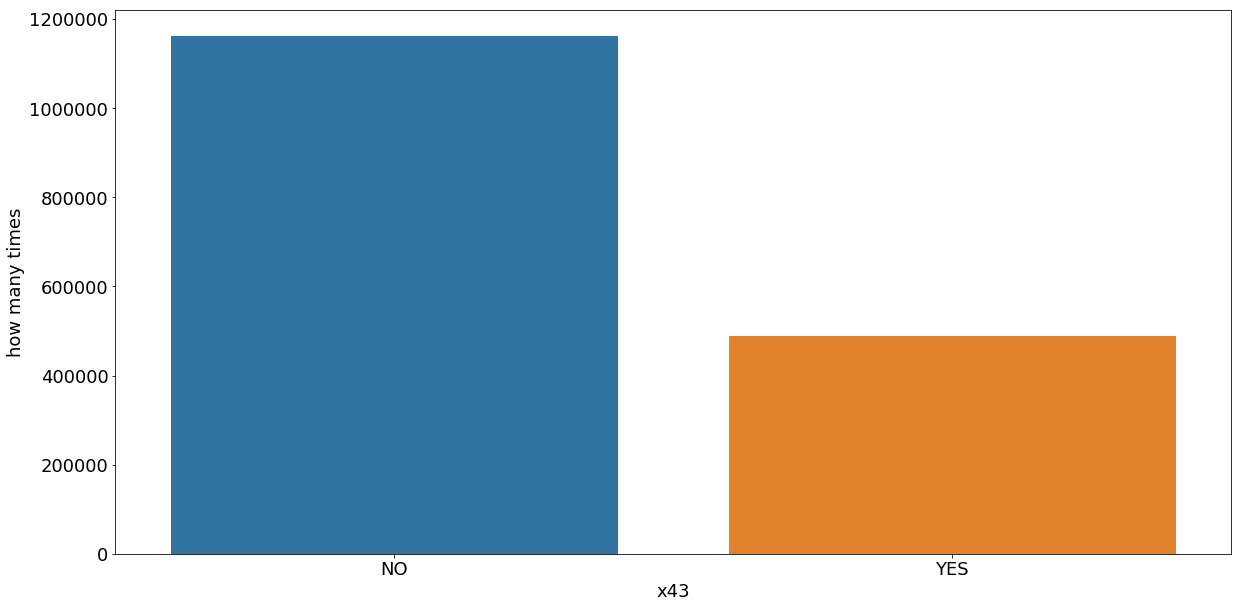

count     1649154
unique    2      
top       NO     
freq      1161460
Name: x43, dtype: object


<Figure size 432x288 with 0 Axes>

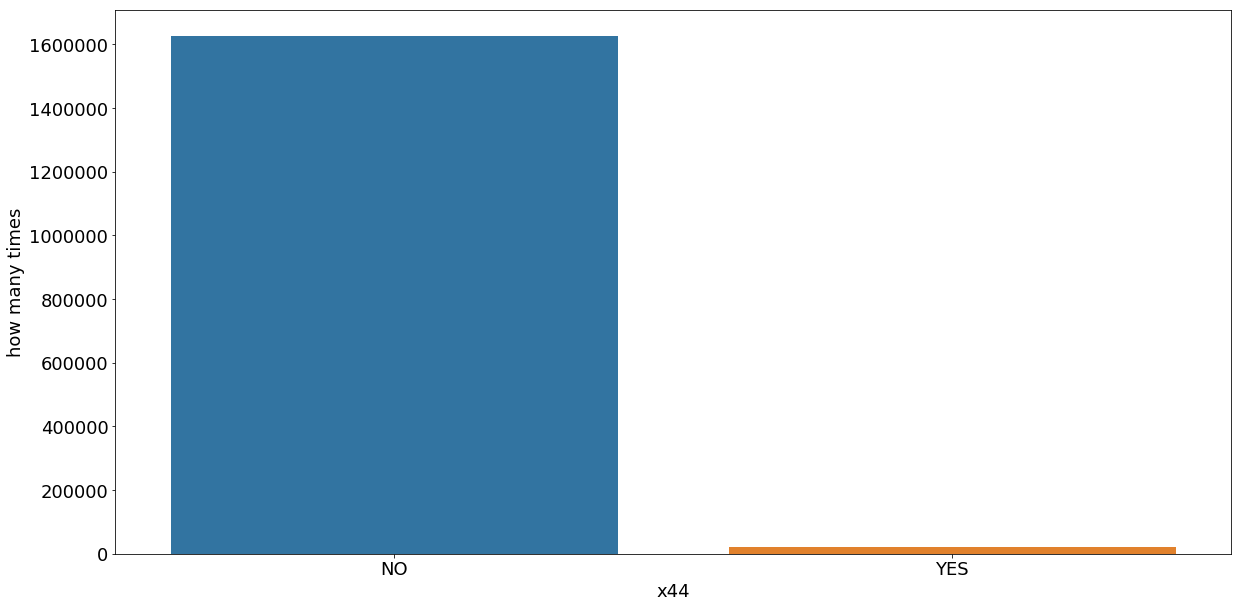

count     1649154
unique    2      
top       NO     
freq      1626229
Name: x44, dtype: object


<Figure size 432x288 with 0 Axes>

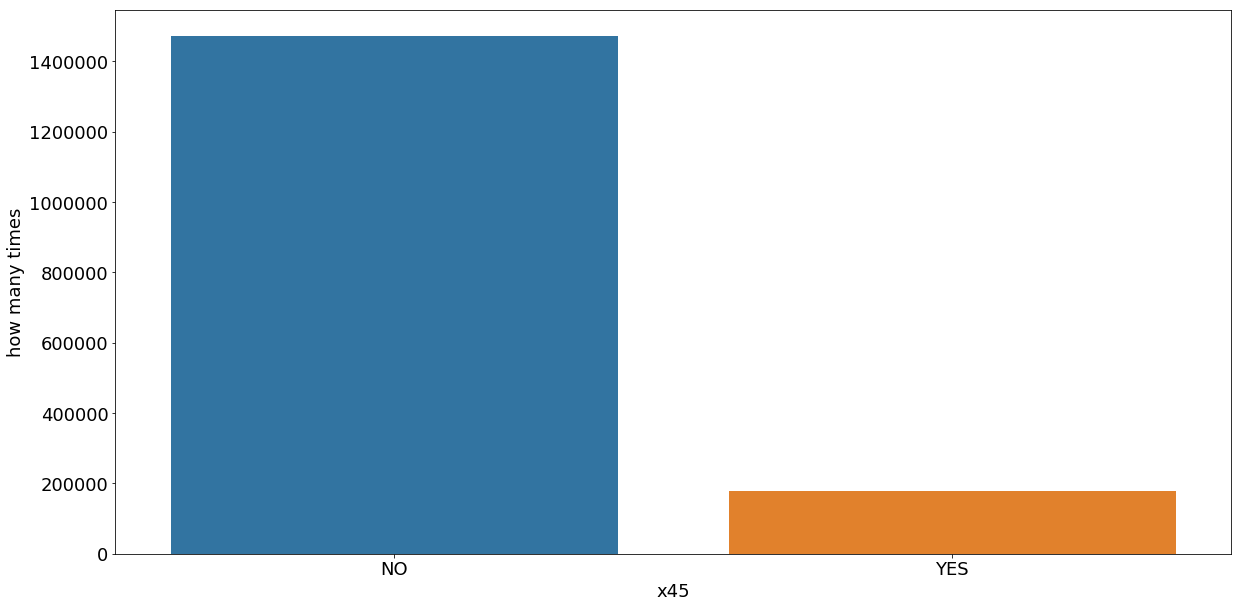

count     1649154
unique    2      
top       NO     
freq      1471789
Name: x45, dtype: object


<Figure size 432x288 with 0 Axes>

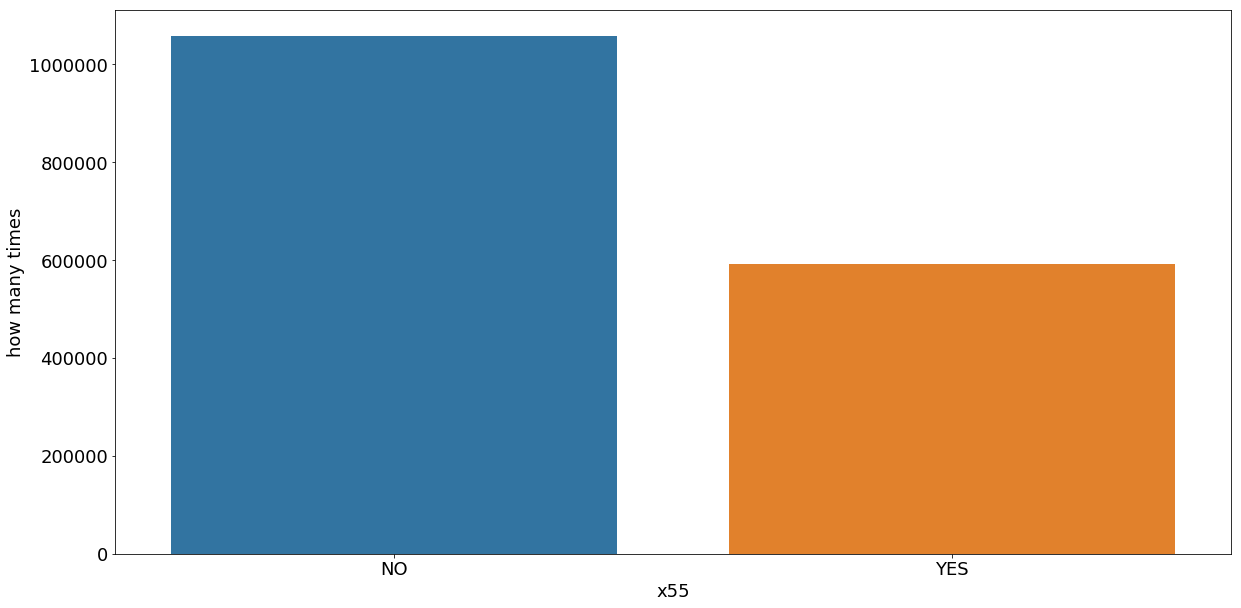

count     1649154
unique    2      
top       NO     
freq      1057557
Name: x55, dtype: object


<Figure size 432x288 with 0 Axes>

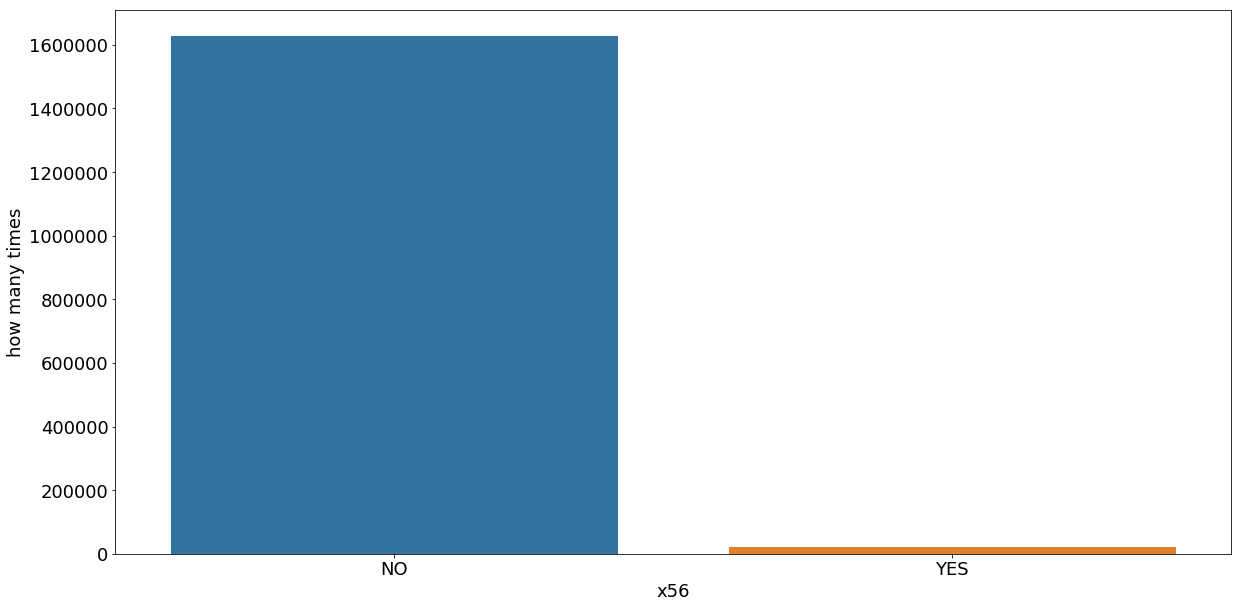

count     1649154
unique    2      
top       NO     
freq      1627610
Name: x56, dtype: object


<Figure size 432x288 with 0 Axes>

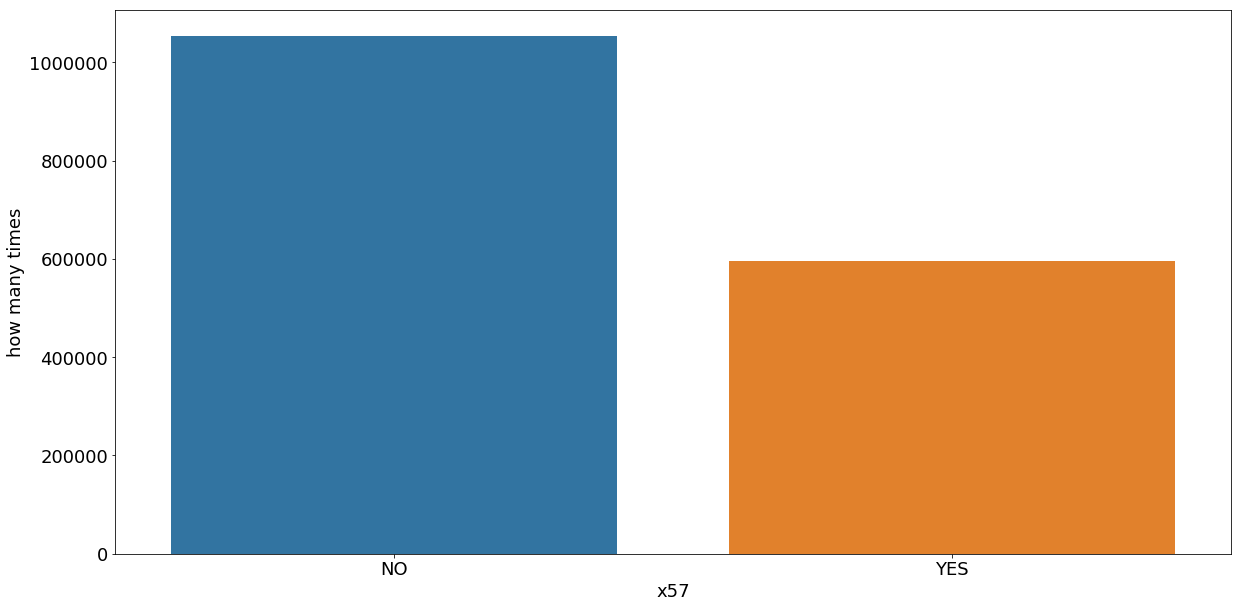

count     1649154
unique    2      
top       NO     
freq      1053102
Name: x57, dtype: object


<Figure size 432x288 with 0 Axes>

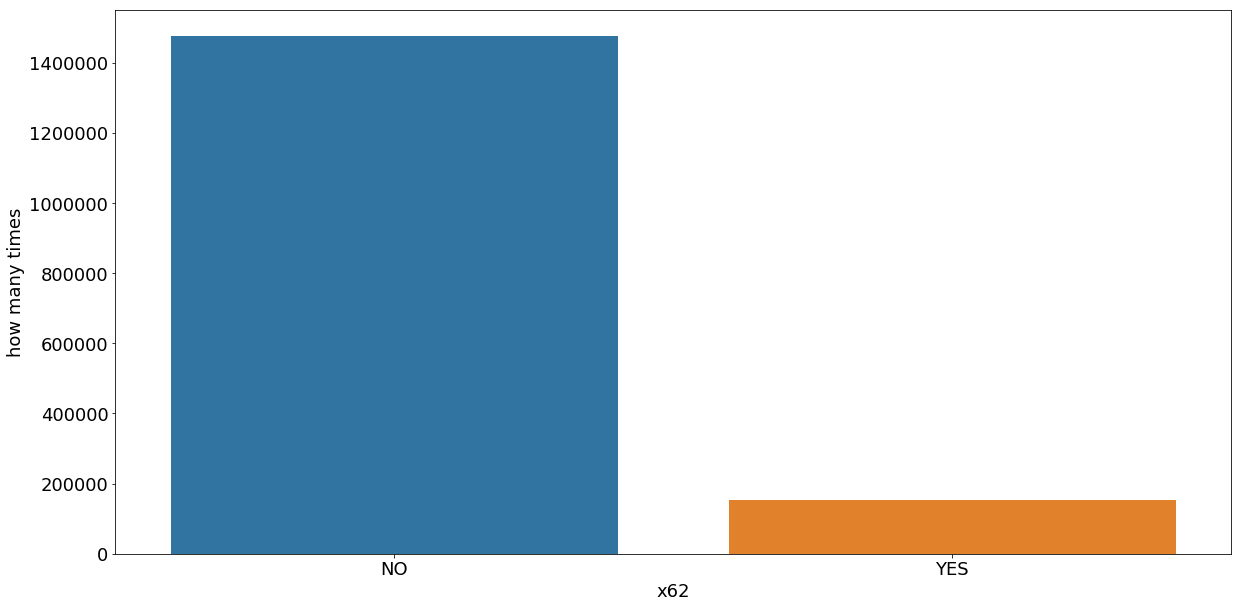

count     1629022
unique    2      
top       NO     
freq      1475852
Name: x62, dtype: object


<Figure size 432x288 with 0 Axes>

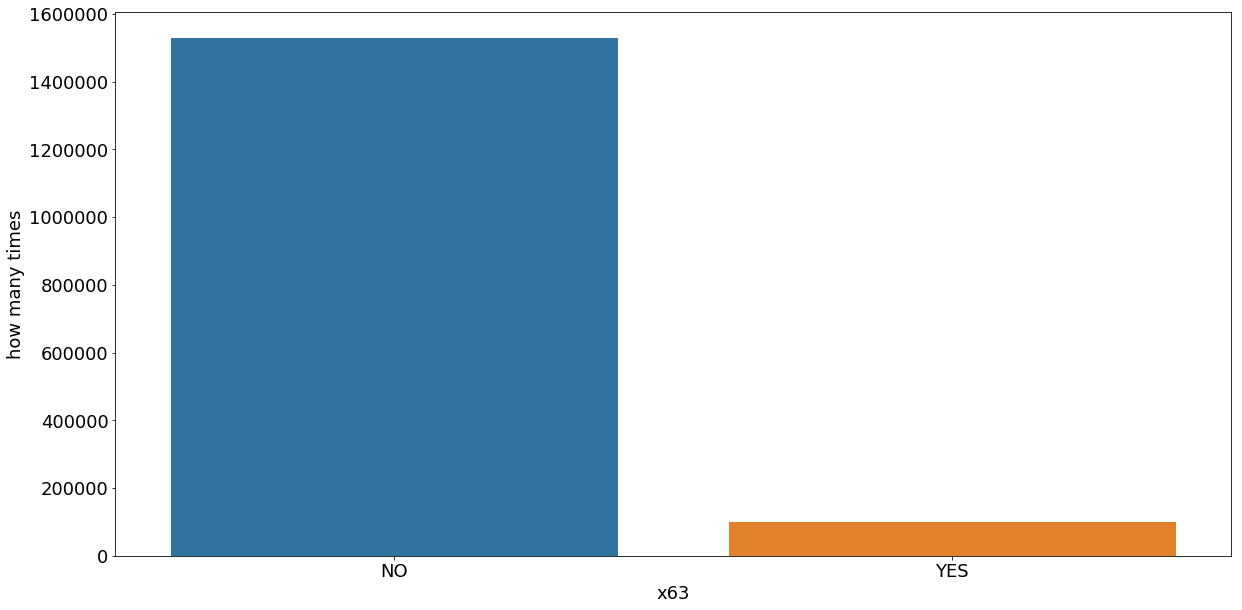

count     1629022
unique    2      
top       NO     
freq      1528719
Name: x63, dtype: object


<Figure size 432x288 with 0 Axes>

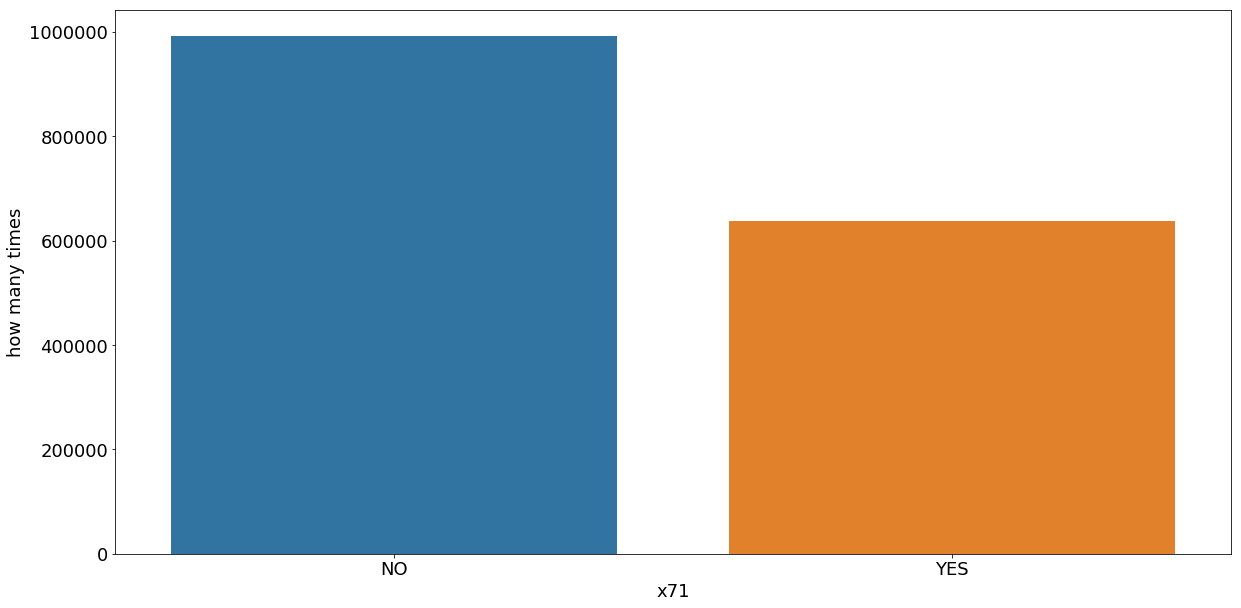

count     1628939
unique    2      
top       NO     
freq      992003 
Name: x71, dtype: object


<Figure size 432x288 with 0 Axes>

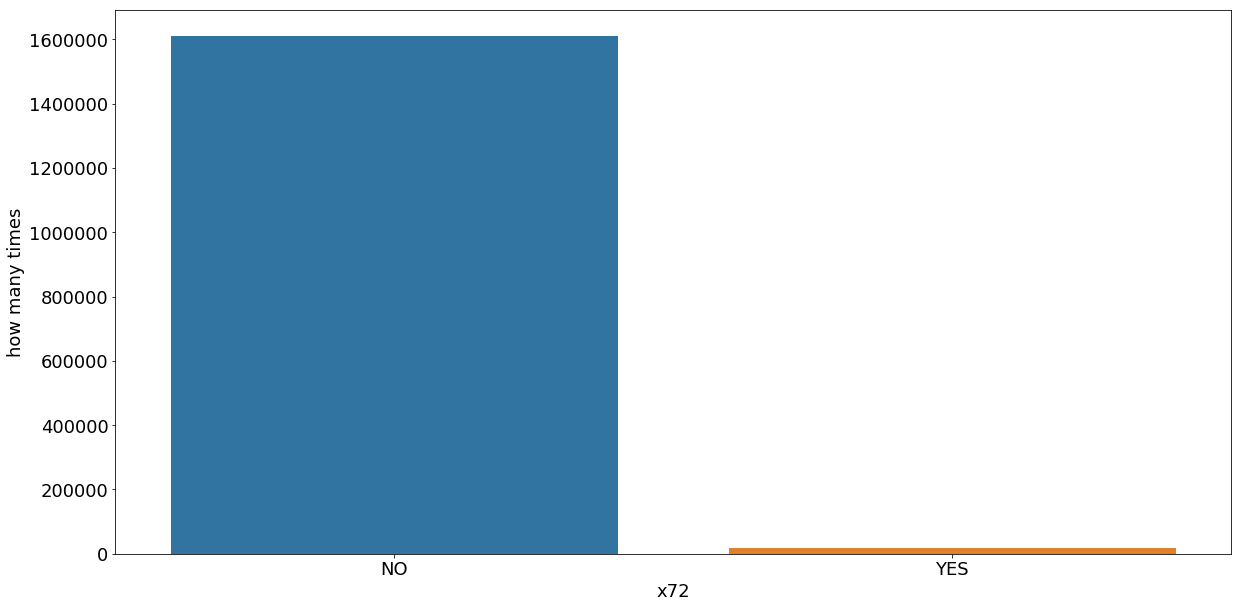

count     1628939
unique    2      
top       NO     
freq      1609920
Name: x72, dtype: object


<Figure size 432x288 with 0 Axes>

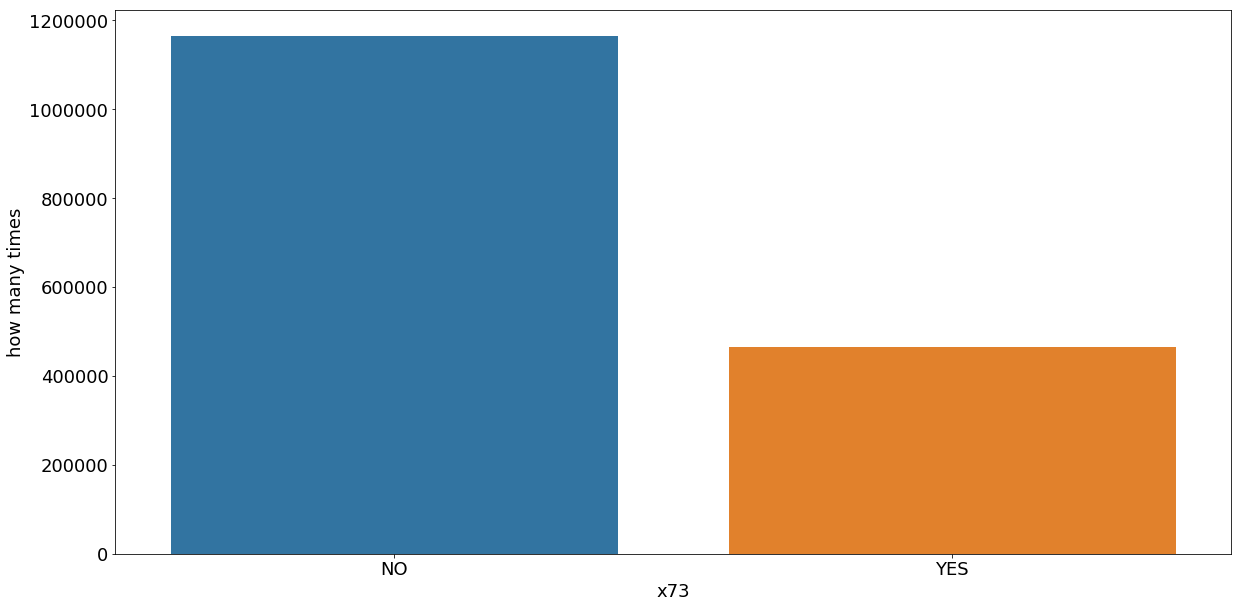

count     1628939
unique    2      
top       NO     
freq      1164110
Name: x73, dtype: object


<Figure size 432x288 with 0 Axes>

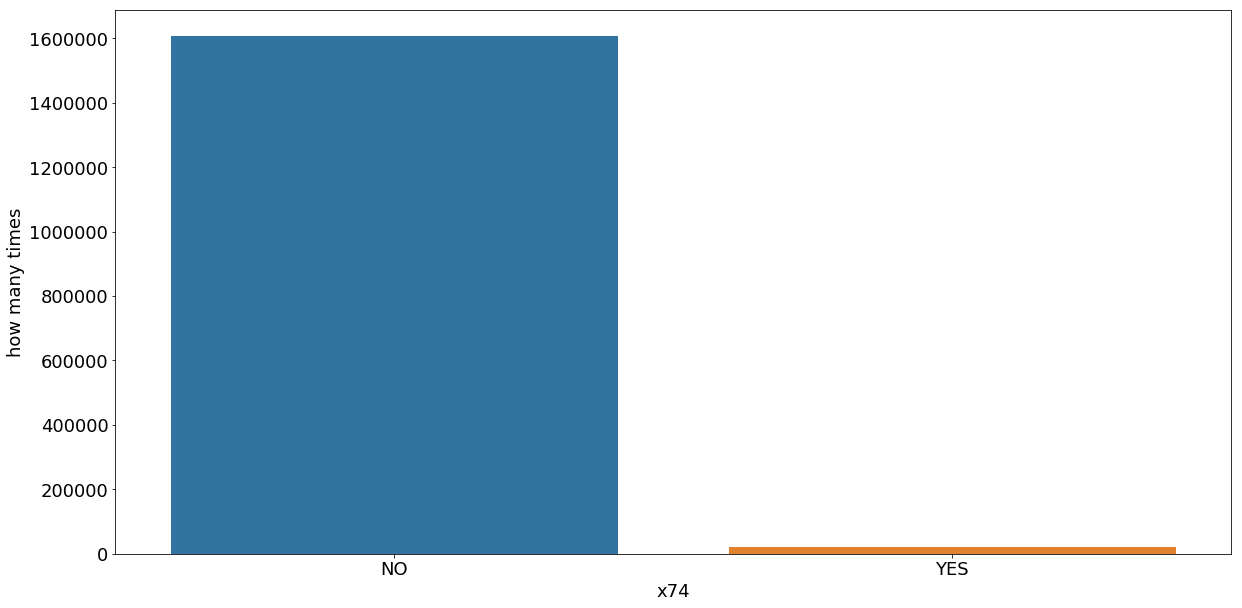

count     1628939
unique    2      
top       NO     
freq      1606349
Name: x74, dtype: object


<Figure size 432x288 with 0 Axes>

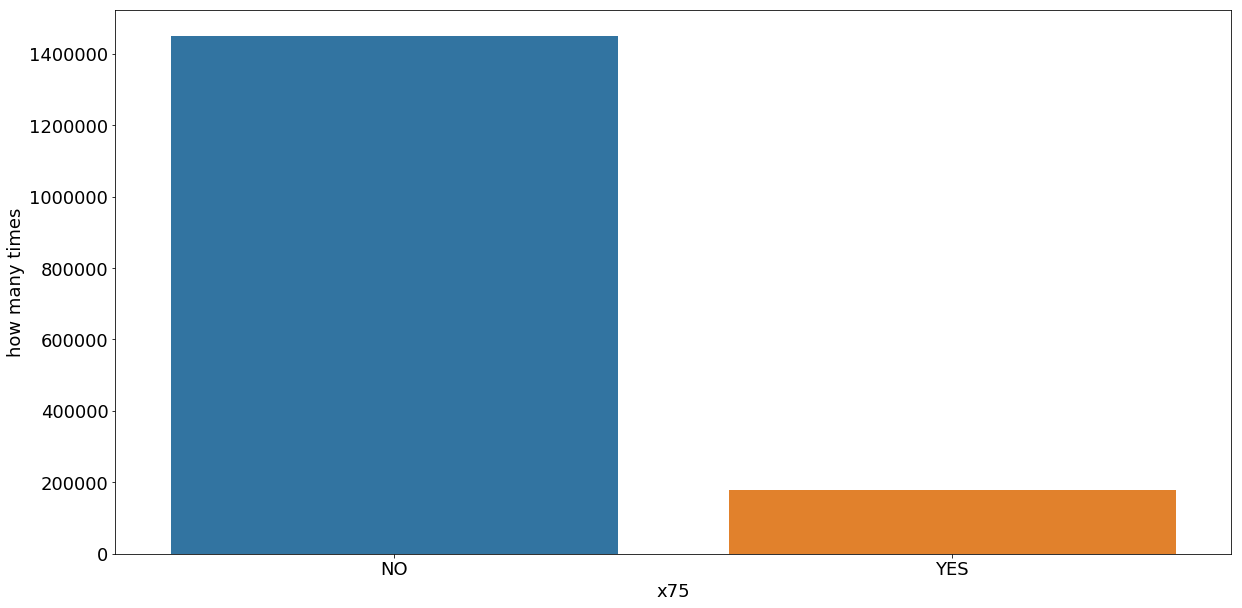

count     1628939
unique    2      
top       NO     
freq      1449499
Name: x75, dtype: object


<Figure size 432x288 with 0 Axes>

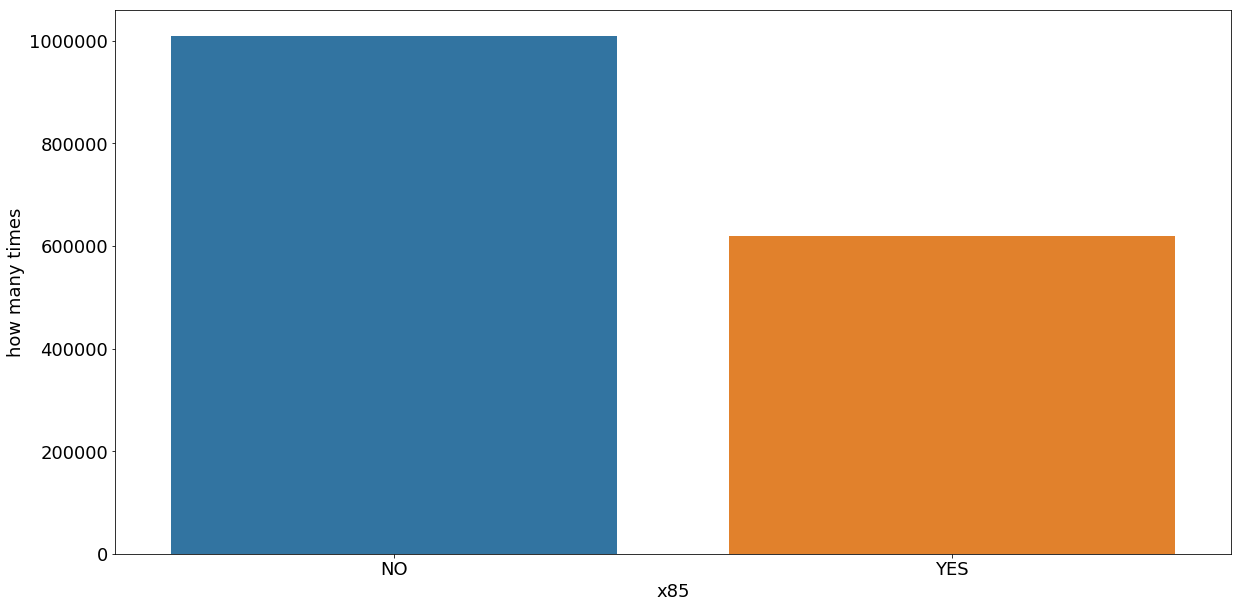

count     1628939
unique    2      
top       NO     
freq      1008828
Name: x85, dtype: object


<Figure size 432x288 with 0 Axes>

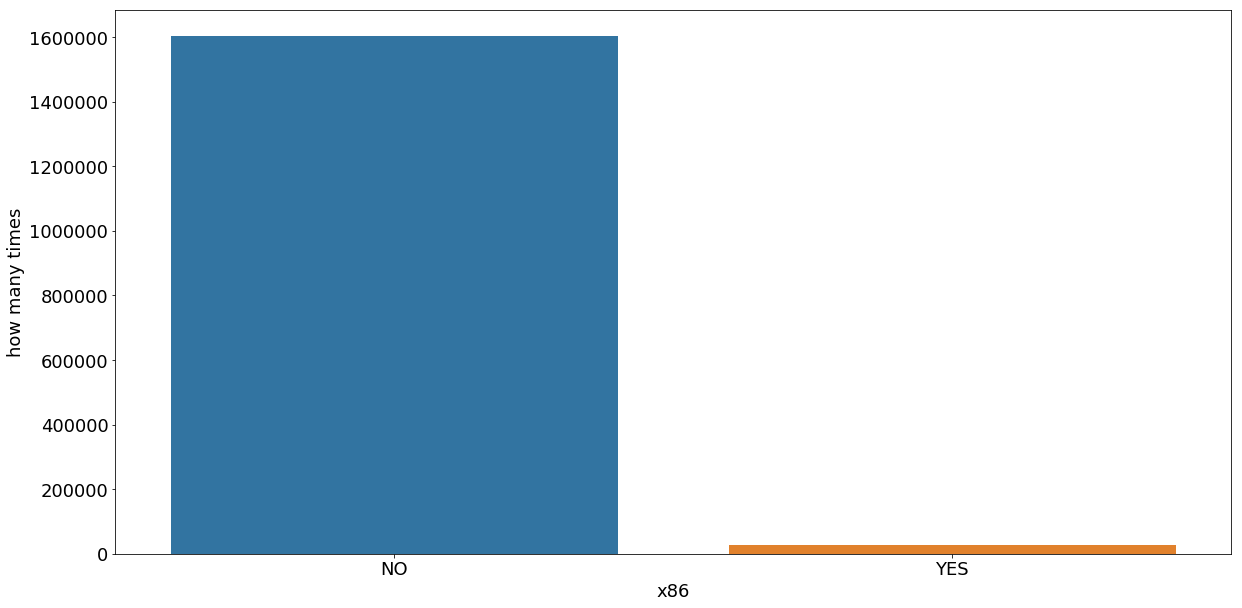

count     1628939
unique    2      
top       NO     
freq      1602879
Name: x86, dtype: object


<Figure size 432x288 with 0 Axes>

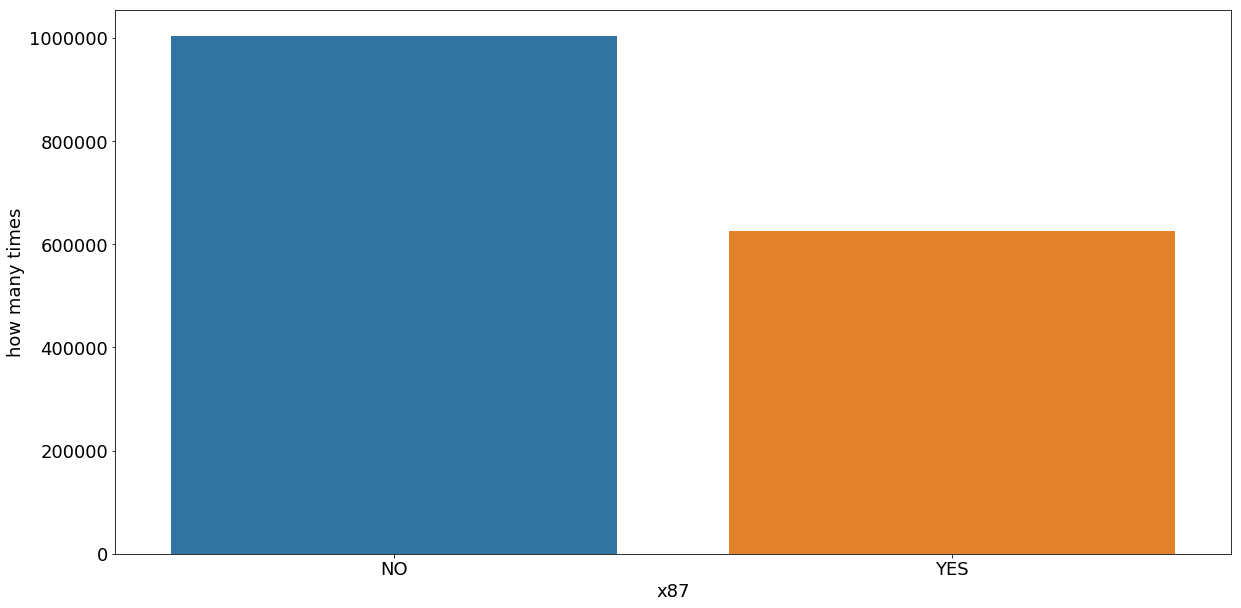

count     1628939
unique    2      
top       NO     
freq      1003502
Name: x87, dtype: object


<Figure size 432x288 with 0 Axes>

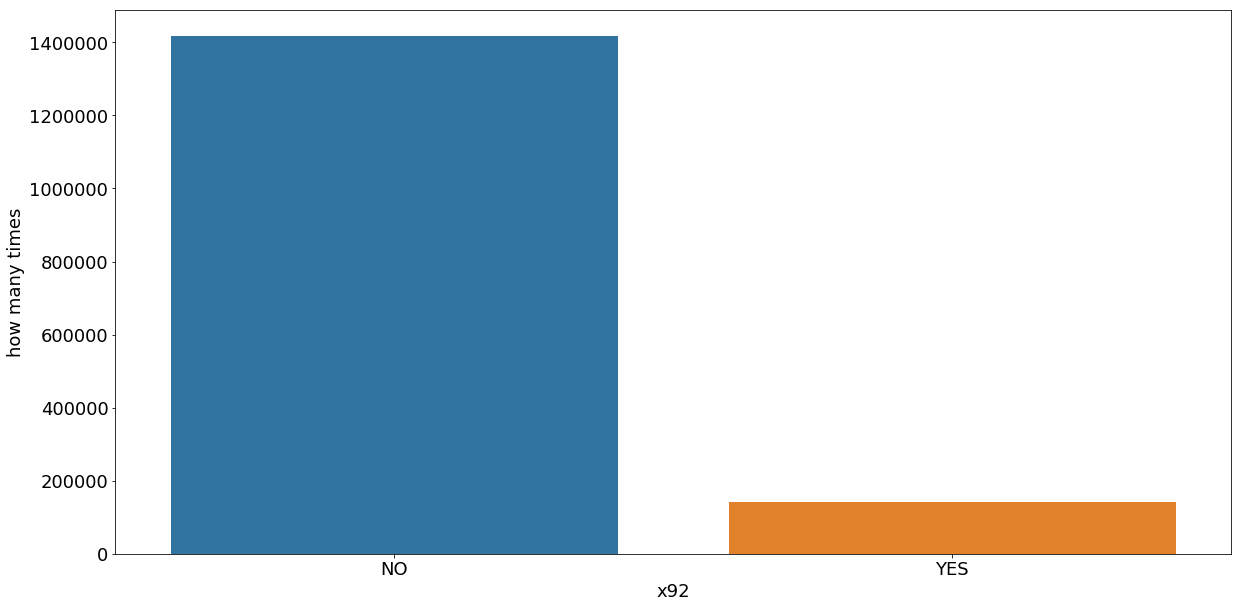

count     1559474
unique    2      
top       NO     
freq      1417147
Name: x92, dtype: object


<Figure size 432x288 with 0 Axes>

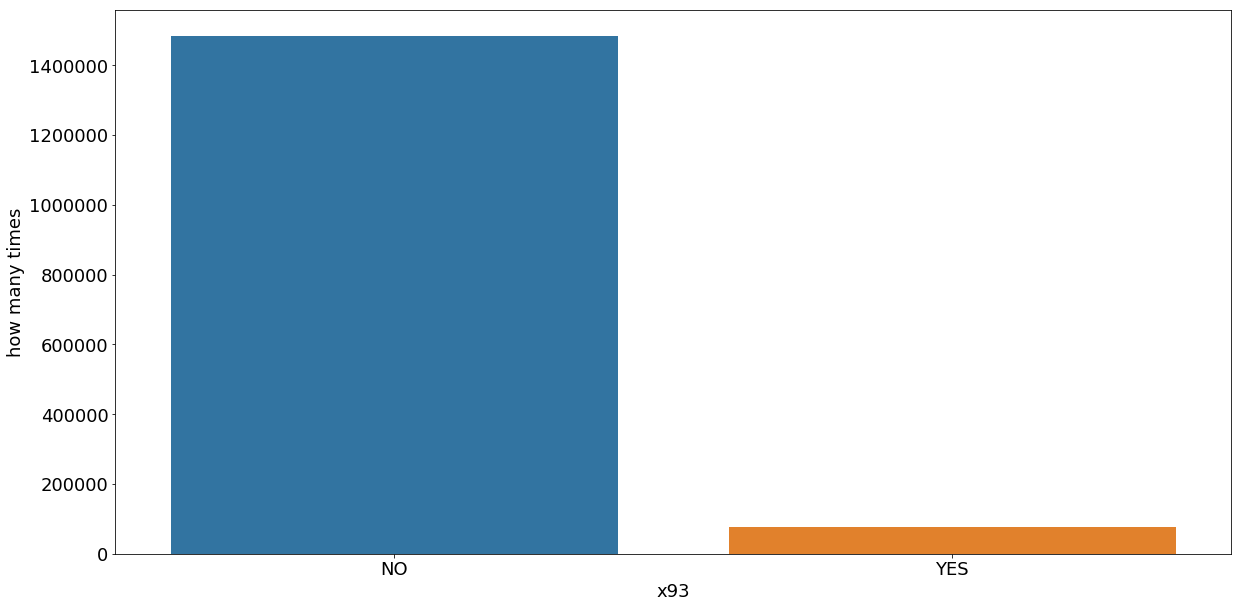

count     1559474
unique    2      
top       NO     
freq      1483269
Name: x93, dtype: object


<Figure size 432x288 with 0 Axes>

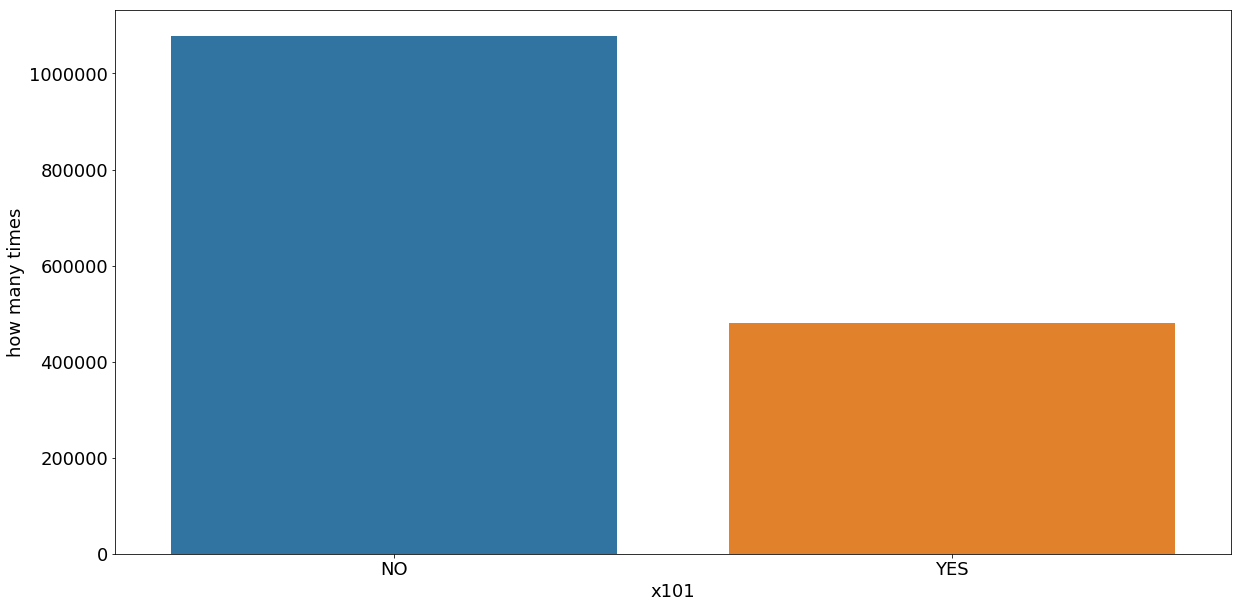

count     1559381
unique    2      
top       NO     
freq      1077855
Name: x101, dtype: object


<Figure size 432x288 with 0 Axes>

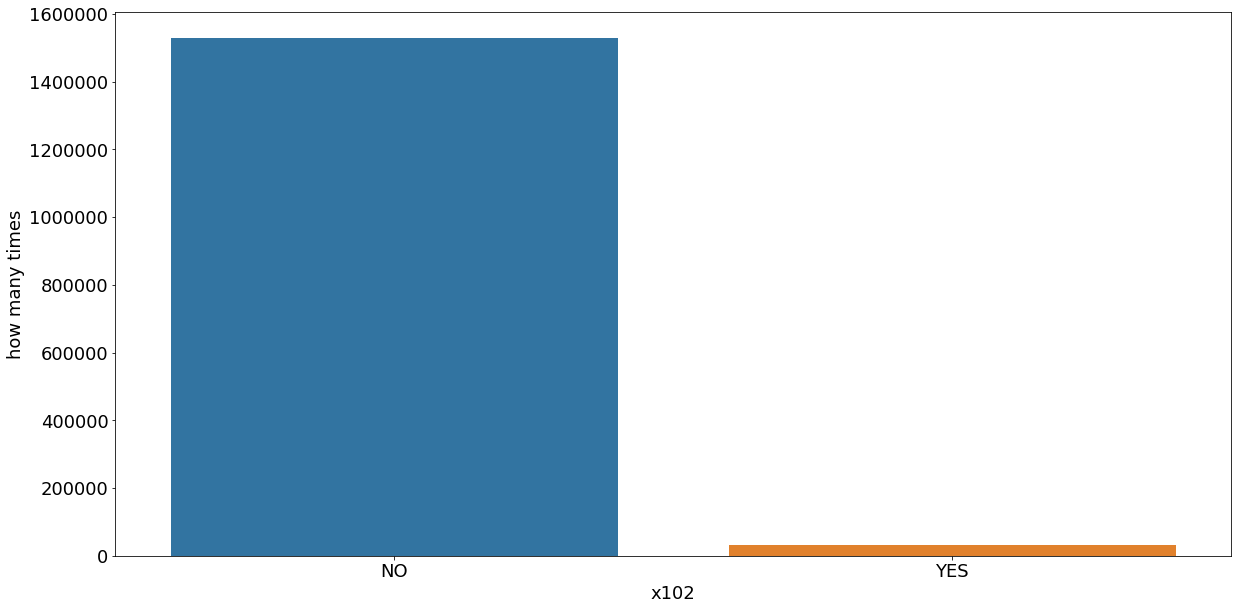

count     1559381
unique    2      
top       NO     
freq      1528452
Name: x102, dtype: object


<Figure size 432x288 with 0 Axes>

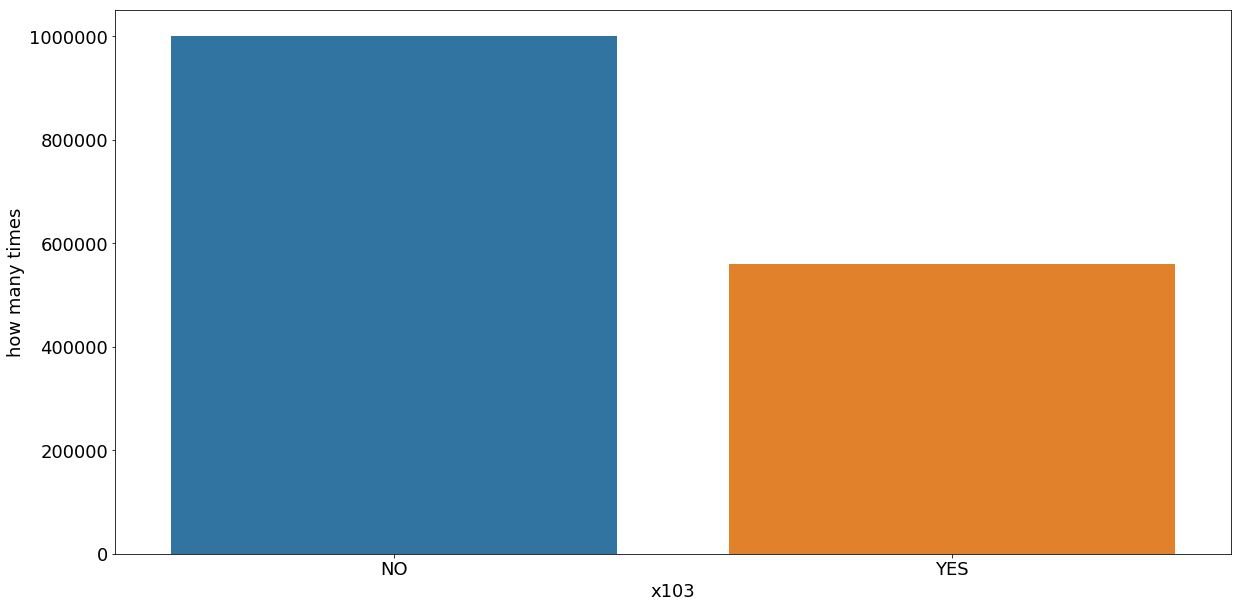

count     1559381
unique    2      
top       NO     
freq      1000298
Name: x103, dtype: object


<Figure size 432x288 with 0 Axes>

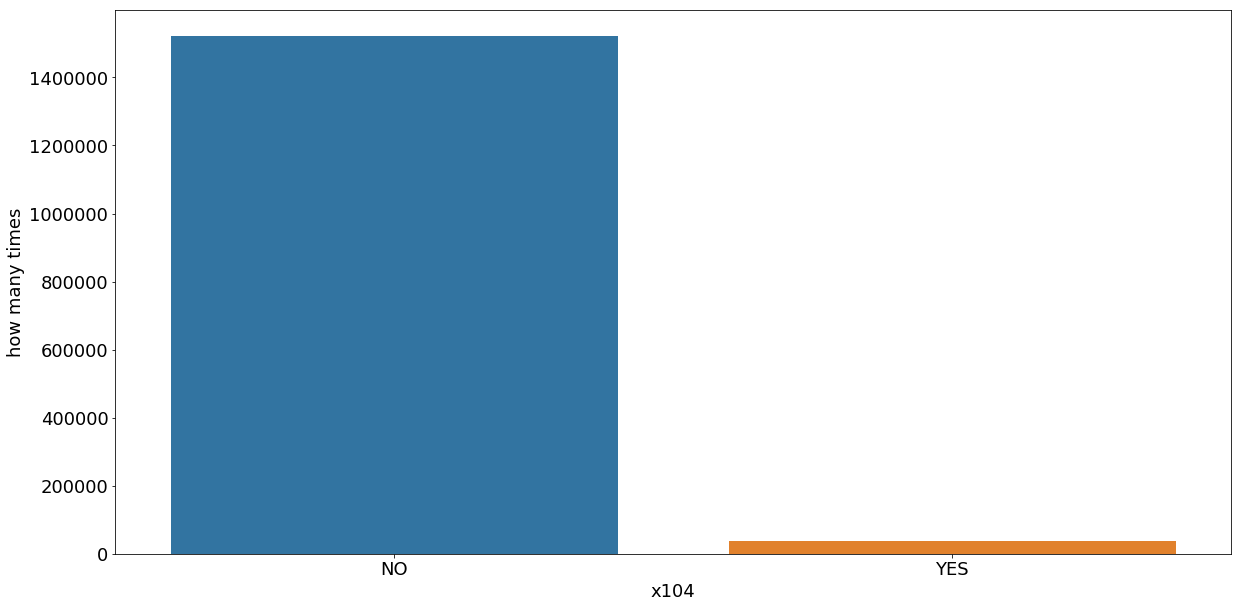

count     1559381
unique    2      
top       NO     
freq      1521380
Name: x104, dtype: object


<Figure size 432x288 with 0 Axes>

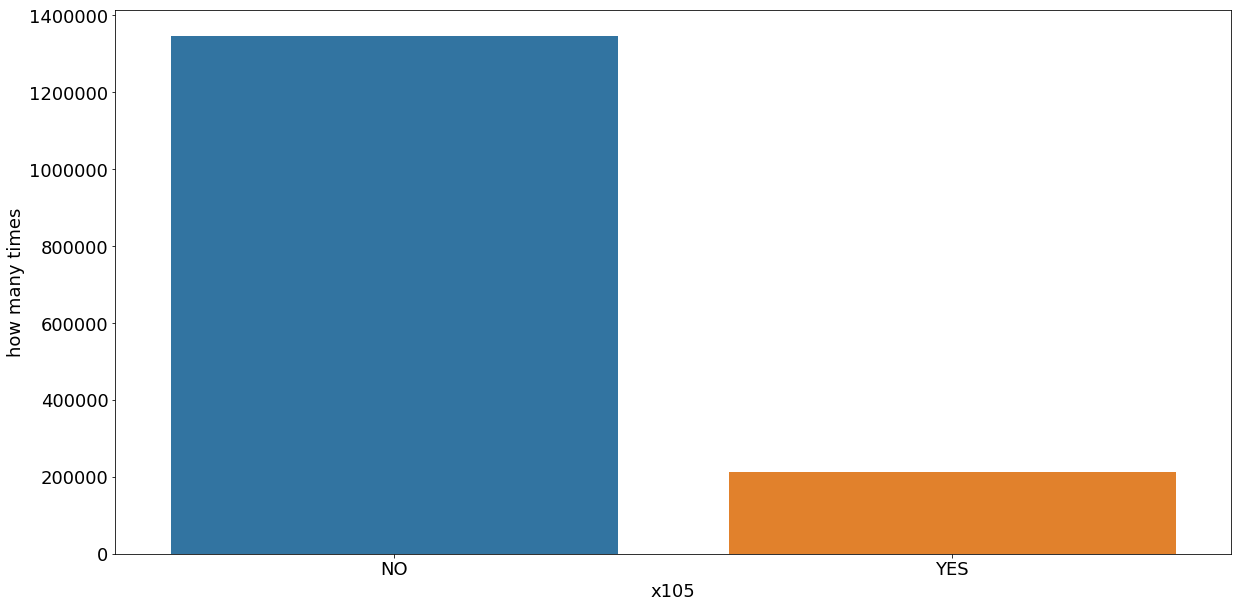

count     1559381
unique    2      
top       NO     
freq      1346098
Name: x105, dtype: object


<Figure size 432x288 with 0 Axes>

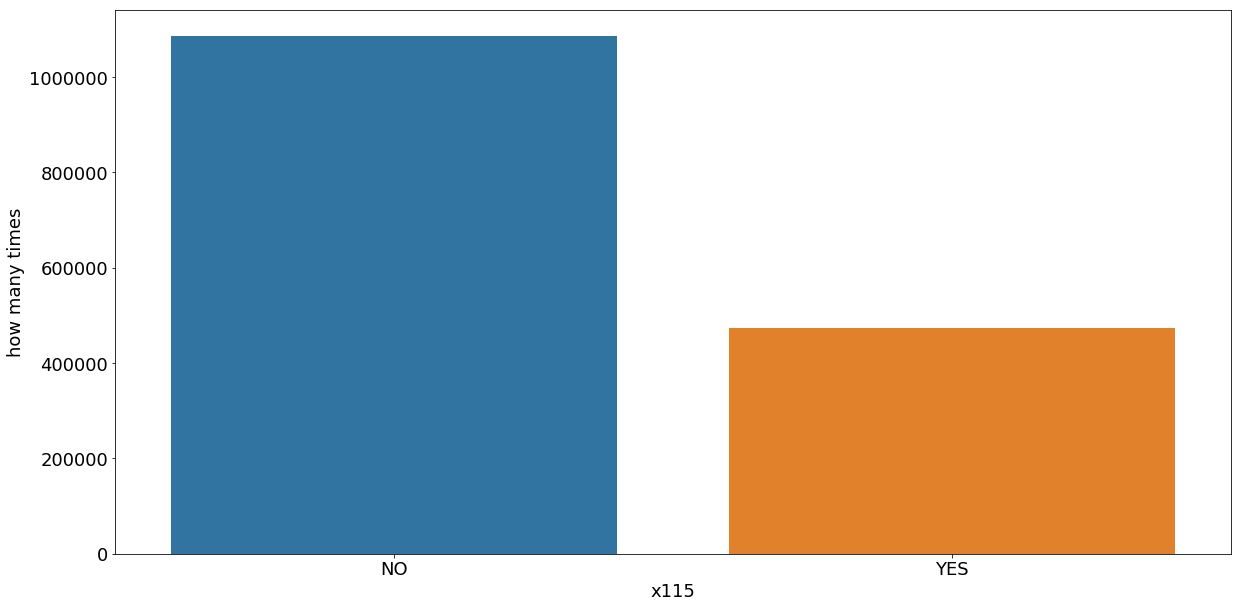

count     1559381
unique    2      
top       NO     
freq      1085899
Name: x115, dtype: object


<Figure size 432x288 with 0 Axes>

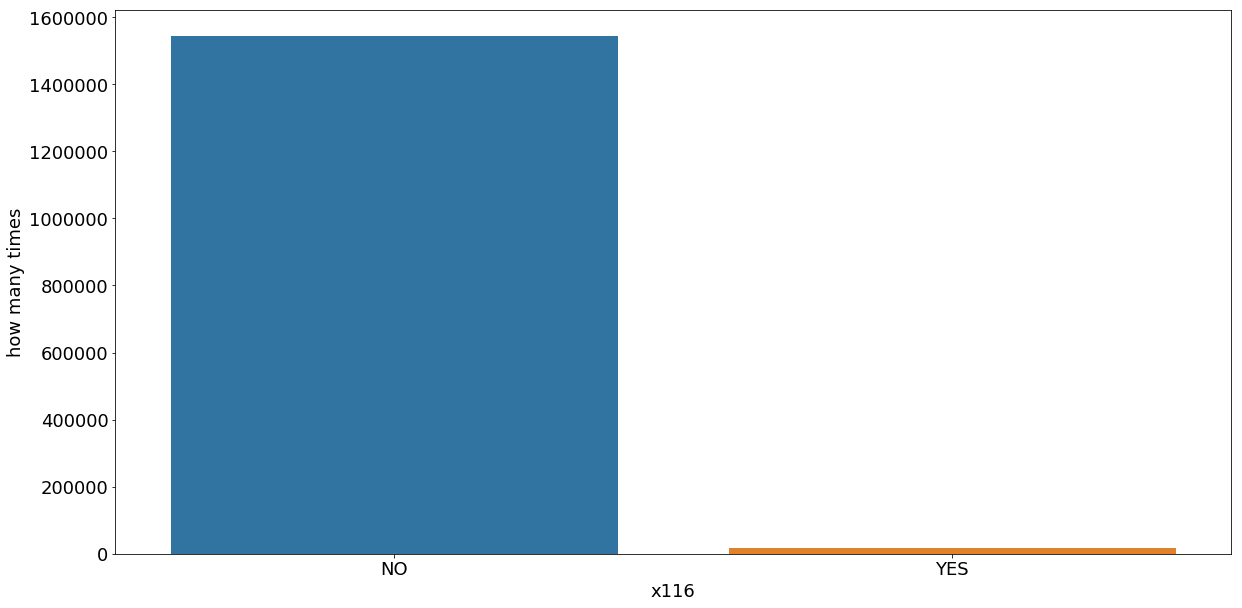

count     1559381
unique    2      
top       NO     
freq      1543503
Name: x116, dtype: object


<Figure size 432x288 with 0 Axes>

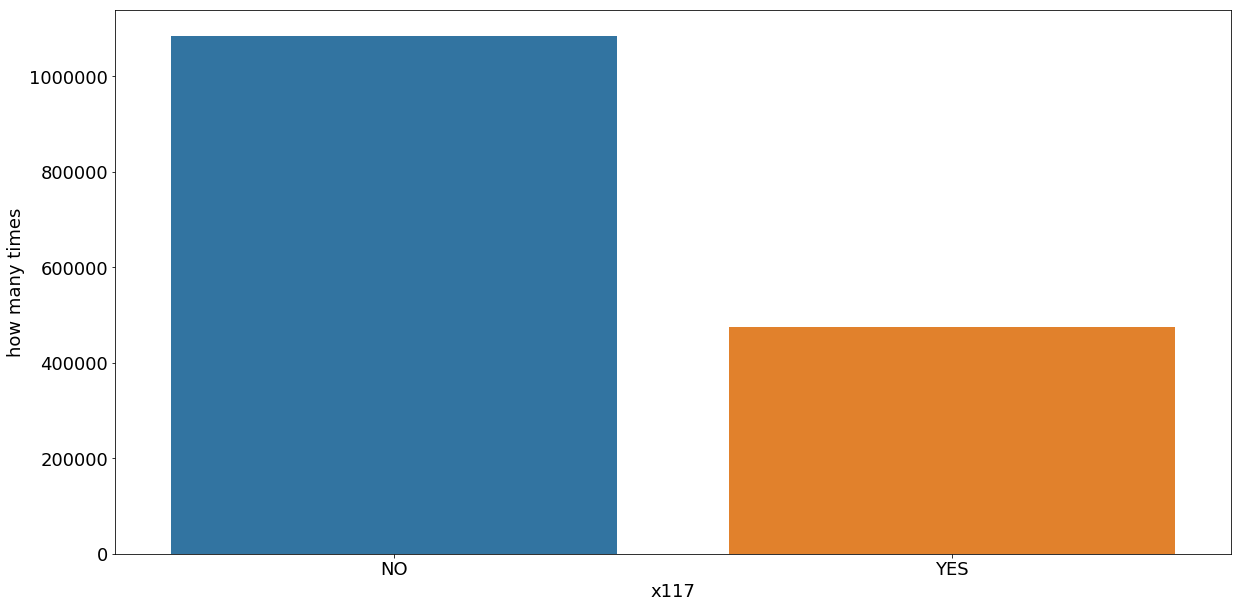

count     1559381
unique    2      
top       NO     
freq      1084300
Name: x117, dtype: object


<Figure size 432x288 with 0 Axes>

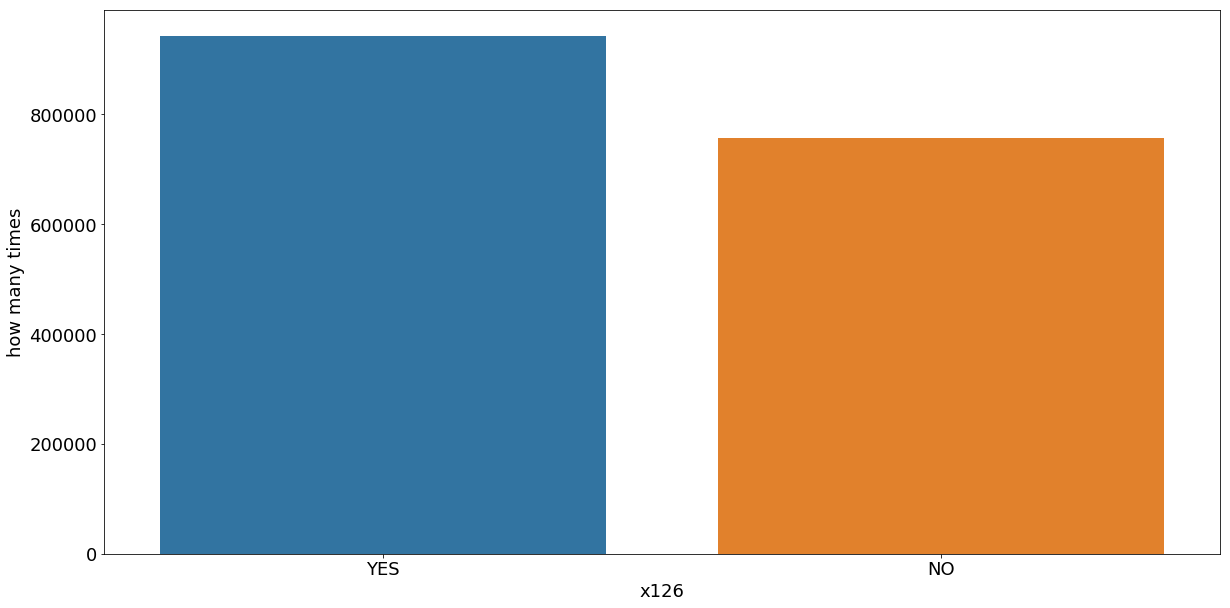

count     1699968
unique    2      
top       YES    
freq      942459 
Name: x126, dtype: object


<Figure size 432x288 with 0 Axes>

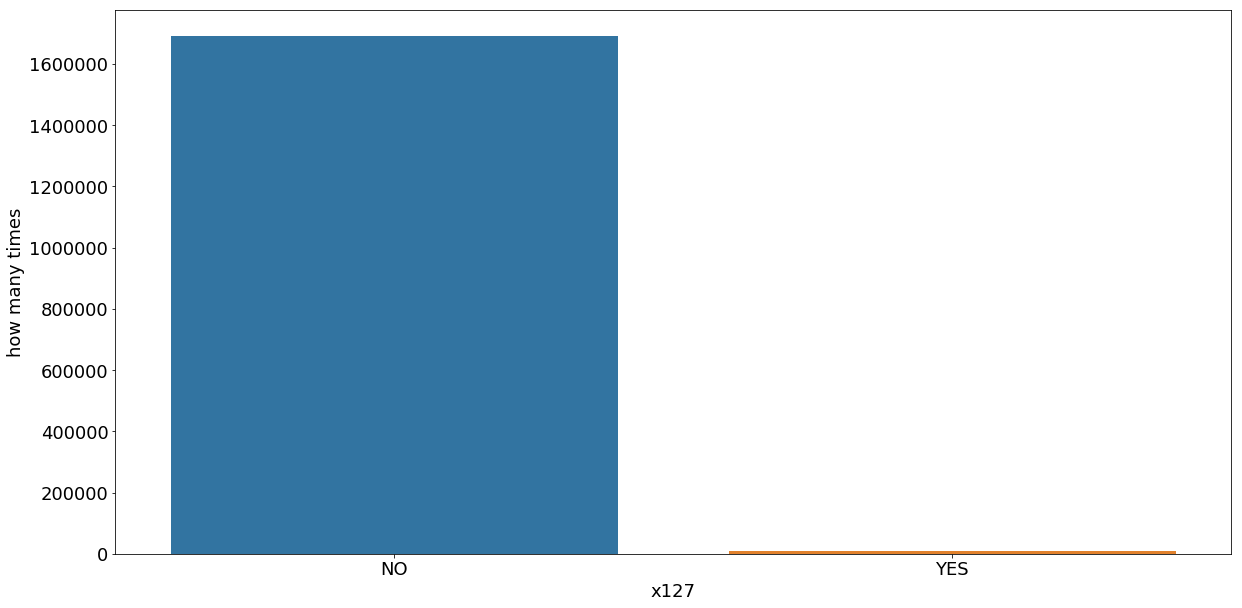

count     1699968
unique    2      
top       NO     
freq      1690819
Name: x127, dtype: object


<Figure size 432x288 with 0 Axes>

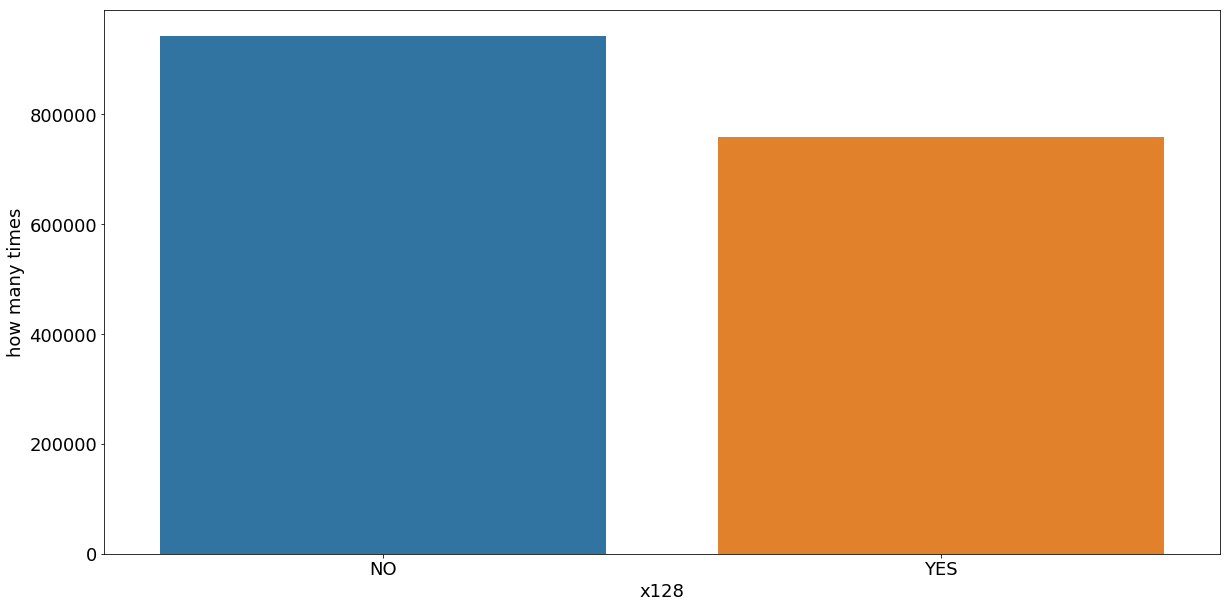

count     1699968
unique    2      
top       NO     
freq      942193 
Name: x128, dtype: object


<Figure size 432x288 with 0 Axes>

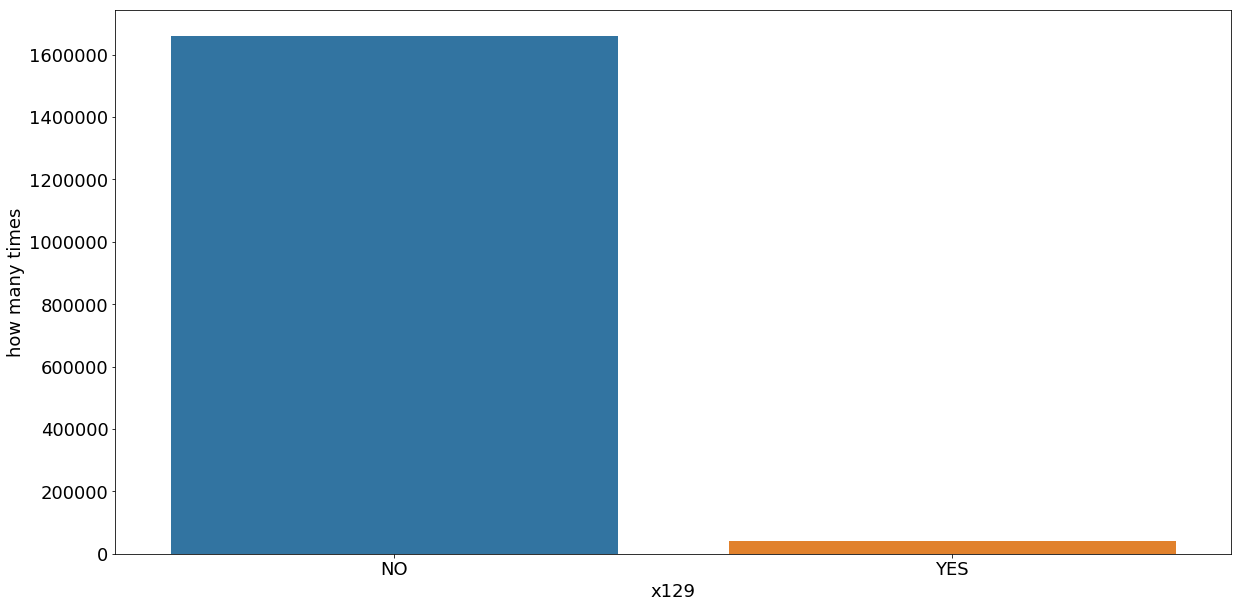

count     1699968
unique    2      
top       NO     
freq      1659101
Name: x129, dtype: object


<Figure size 432x288 with 0 Axes>

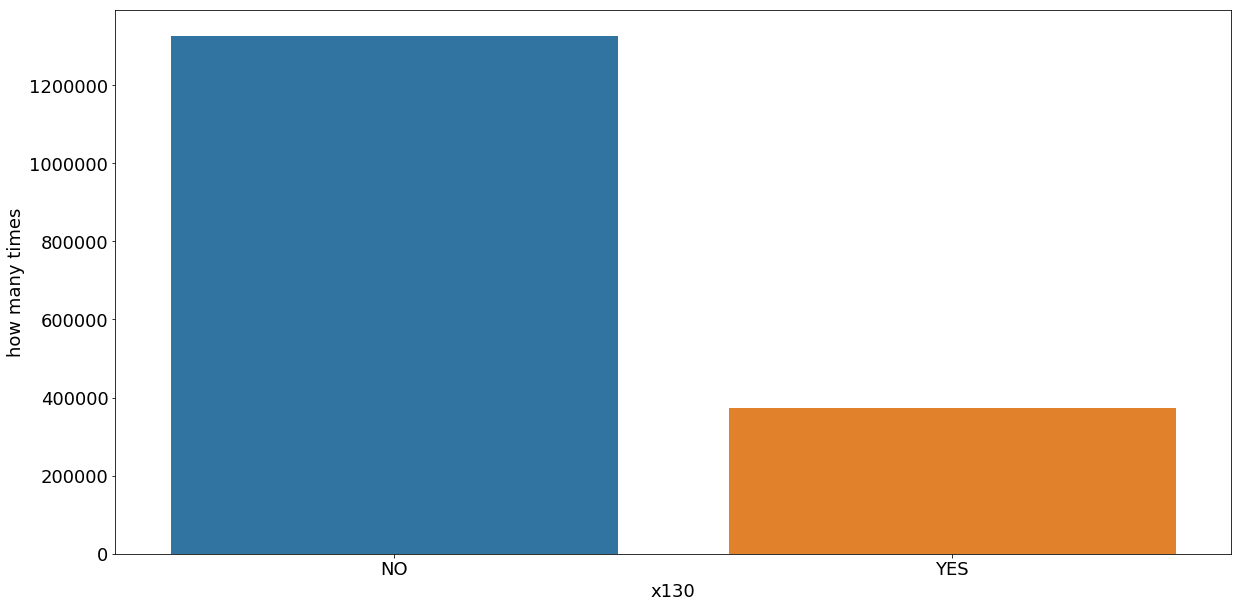

count     1699968
unique    2      
top       NO     
freq      1325460
Name: x130, dtype: object


<Figure size 432x288 with 0 Axes>

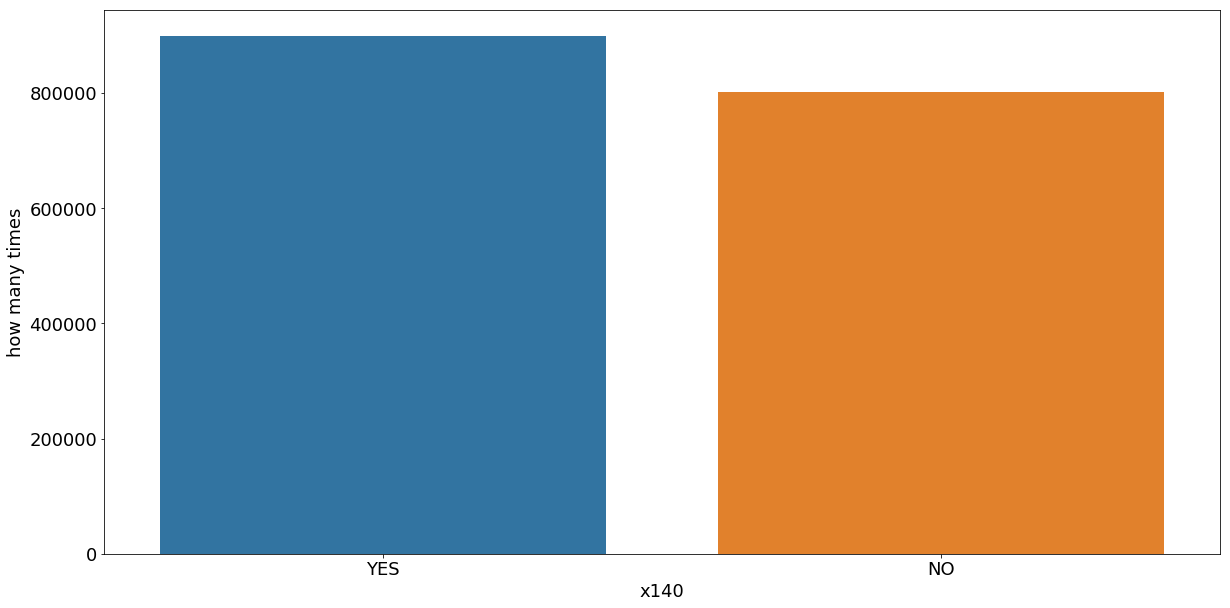

count     1699968
unique    2      
top       YES    
freq      898737 
Name: x140, dtype: object


<Figure size 432x288 with 0 Axes>

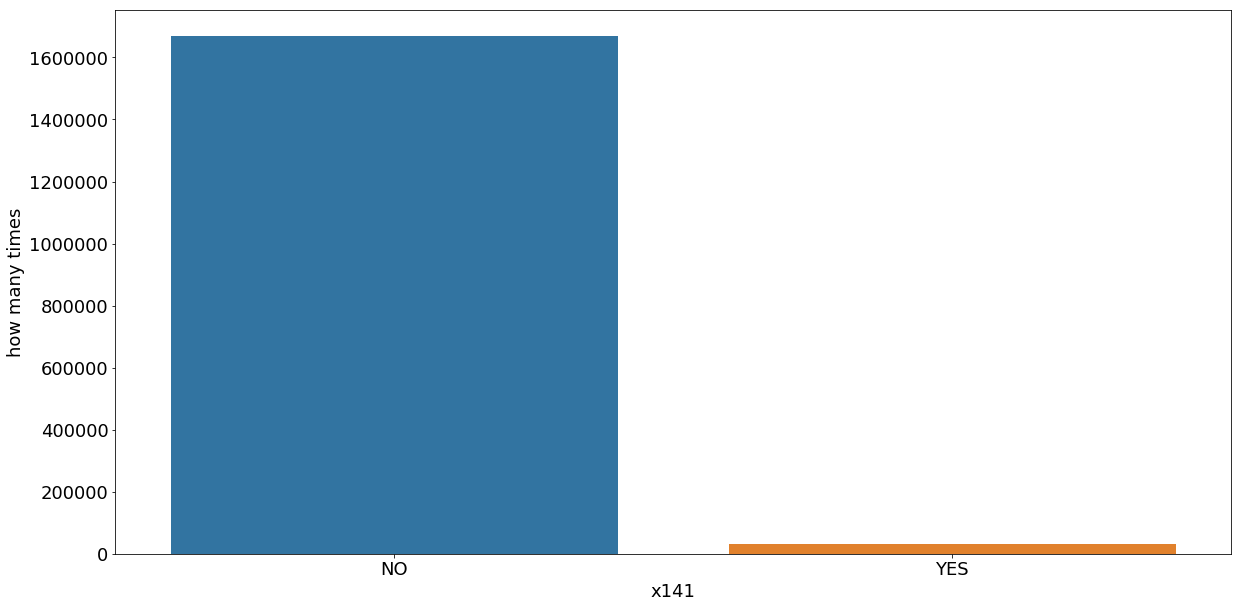

count     1699968
unique    2      
top       NO     
freq      1668833
Name: x141, dtype: object


<Figure size 432x288 with 0 Axes>

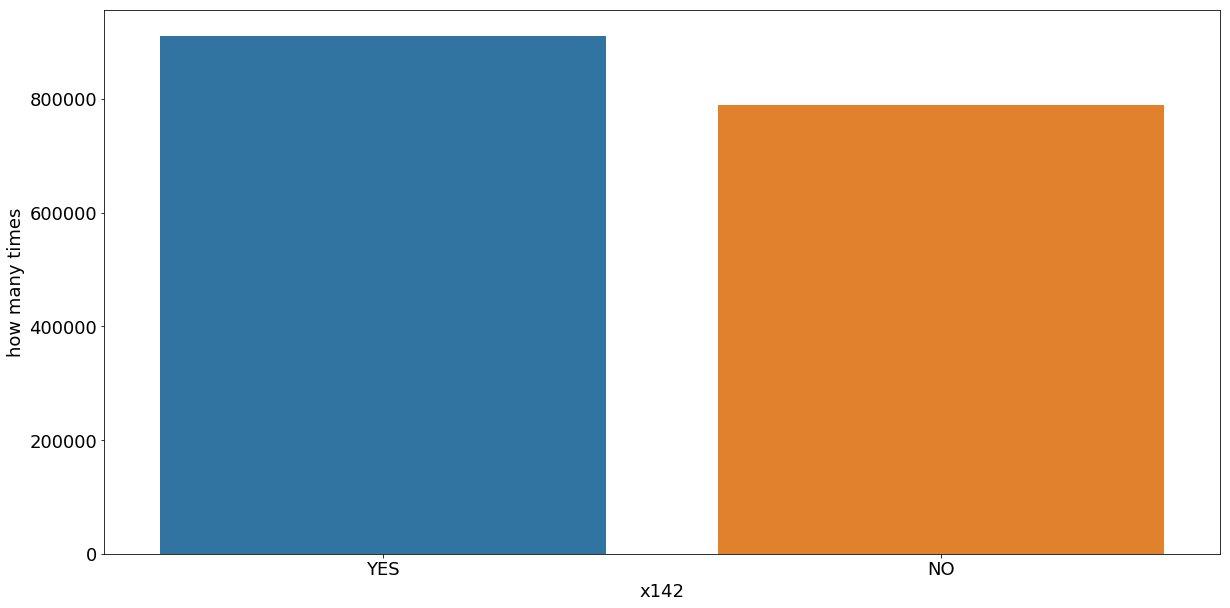

count     1699968
unique    2      
top       YES    
freq      910356 
Name: x142, dtype: object


In [13]:
for v in bool_vars:
    feature = train_features[v]
    pl.categorical(train_features, v)
    print(feature.describe())

The majority of the boolean variables have a greater quantity of NO than YES, only on x126, x140,x142 the YES values are greater than NO values. This visualization don't give us too much information as we don't know which any boolean feature means.

### Algorithms and Techniques

I intend to use three different algorithms to beat the benchmark: Random Forest Classifier, AdaBoosting, and Multilayer Perceptrons.

The first one, [Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) is a bagging method, where they create multiples independents trees on subsets of the features and then average the result of each tree. The result of the average of all tree is a better estimator than a single tree because the variance is reduced, reducing the overfitting problem.

The second one is [AdaBoosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier), a boosting method, the estimators are created sequentially and one tries to reduce the bias of the combined estimator. The boosting combine every weak learner to produce a good ensemble, this technique tries to reduce the bias causing the less underfitting problem.

The last one, [Multi Layer Perceptron](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) or Neural Networks, has the capability to learn non-linear function which can be advantageous in this project, but this kind of model has the disadvantage to be sensitive to feature scaling, requires a lot of tuning in the hyperparameters and can be stuck on a local minimum depends on the weight initializations.

### Benchmark

In this competition, the organizers give us fours different benchmarks scores:
* The all zeros benchmark, where every label answer is zero;
* The random benchmark, where every label was given a random value;
* The halves benchmark, where every label was given a value of 0.5;
* And finally the Tradeshift Baseline Benchmark.

The score of the four benchmarks is find below, in this evaluation metric lower is better:

| Benchmark   | Score     |
|-------------|-----------|
| TS Baseline | 0.0150548 |
| All Halves  | 0.6931471 |
| Random      | 1.0122952 |
| All Zeros   | 1.1706929 |



## III. Methodology

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_

- future:
 - See the outliers - https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561

#### Memory efficient dataframe

In this part I will explore some transformation on the dataset for memory efficiency, like the transformation of the YES/NO features to a boolean datatype.

In [3]:
meta_path = "../working/meta.pkl"

if not os.path.isfile(meta_path) :
    pickle.dump(meta, open(meta_path, "wb"))

meta = pickle.load(open(meta_path, "rb"))

int_features = meta[(meta.dtype == 'int64') & (meta.role != 'id')].index
float_features = meta[(meta.category == 'numerical') & (meta.dtype == 'float64')].index
bool_vars = meta[(meta.category == 'boolean')].index
content_features = meta[(meta.category == 'content')].index

In [4]:
train_bool_transform_path = "../working/1_train_bool_transform.pkl"

if not os.path.isfile(train_bool_transform_path):
    train_features = pre.tranform_boolean_features(train_features, bool_vars)
    train_features.to_pickle(train_bool_transform_path)

train_features = pd.read_pickle(train_bool_transform_path)
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700000 entries, 0 to 1699999
Columns: 146 entries, id to x142
dtypes: bool(50), float64(55), int64(31), object(10)
memory usage: 1.3+ GB


This transformation decreases the memory usage in 500 MB comparing with the original dataset.

#### Encoding the content

As the algorithms accept only floats, ints and booleans as input, I decide to tranform all the contents feature to boolean features where the column represent the combo feature plus the hash and the value is 1 if the pair exists or 0 if not, as this has a high memory comsuption I will go for a sparse matrix type of collumn when use get_dummies on pandas.

In [29]:
train_bool_transform_path = "../working/1_train_bool_transform.pkl"

train_only_content_path = "../working/2_train_only_content.pkl"
train_without_content_path = "../working/3_train_without_content.pkl"

if not os.path.isfile(train_only_content_path):
    train_features = pd.read_pickle(train_bool_transform_path)

    content_features_filter = [col for col in content_features]
    content_features_filter.append('id')
    
    only_content_df = train_features.filter(content_features_filter, axis=1)
    only_content_df.to_pickle(train_only_content_path)
    
    del only_content_df
    del train_features
    gc.collect()

    train_features = pd.read_pickle(train_bool_transform_path)
    
    not_content_df = train_features.filter(train_features.columns.difference(content_features), axis=1)
    not_content_df.to_pickle(train_without_content_path)
    
    del not_content_df
    del train_features
    gc.collect()

train_features = pd.read_pickle(train_only_content_path)

In [5]:
train_only_content_encoding = "../working/4_train_only_content_encoding.pkl"

if not os.path.isfile(train_only_content_encoding):
    train_features = pre.transform_sparse_content_features(train_features, content_features)
    train_features.to_pickle(train_only_content_encoding)

In [6]:
train_features.dtypes

id                                                  int64
x3_++/0EbZtKBSuOZXNs3tkbbh24HO9aAkxrd+H/o1dNWM=     bool 
x3_++/A3BgGcYm01YCK9ehwge2W+Y3NaDcEVLQdieIRTWM=     bool 
x3_++2I9sHdYj2XTdXk043iBFb/kC59Qa5Se0KCfver2V8=     bool 
x3_++3SSvGWqNy50hj+fHyMBJFDw4/keQFlGszMoJPWXrA=     bool 
x3_++4vEHOGTryp3/pZpHj8w6d9Yrultlbq7yKMiGztTb4=     bool 
x3_++63XOuhbBPT8nAEMJTv+o8J5qjxQV1ibKeWSQaEhcA=     bool 
x3_++6HG6QSkDvzDqxQsf7IdMc3wuWobu0L+Nh4NduMRwU=     bool 
x3_++8lL0wuGGnWofyZ+tCeltI+jnc40GSOL9Gd+xkEY5M=     bool 
x3_++9/AtL8QahHN0oMo57aSzQDlOTLZX0i9VBkhQQZTYI=     bool 
x3_++9EzUaMGC1wr+zAIUGGnTuHz2KmCslnIngEbaOsjsM=     bool 
x3_++9j0GgdKbMXX2B8KJYVNCysj+87GOOlbjw4x9AYudA=     bool 
x3_++BdfLuOL2CASDfQ4rCDy1dvQcAUyiXwZbdbN+vIh8E=     bool 
x3_++Byzenahx5hbKxLcHdSE5d0igg5PHeH1tv94otEyFg=     bool 
x3_++CAE6jzKP/MO1aXznPjuNnqUGb00ha8yMGlhN52ePc=     bool 
x3_++CsfNOG8MGnAnEzrZGkNNikRY5Jm+8mo5FGS47WkCo=     bool 
x3_++DQVDSqr++9UW+Y5YAUh9prZW20yuR/K/YlJ9Gmemo=     bool 
x3_++GPA1yyvCM

After the transformation the dataset goes from 10 content input columns to 1_595_342.

#### Scaling

In this section, will scale the dataset to get a better result on the PCA as they need similar scales of measurement.

In [7]:
train_without_content_path = "../working/3_train_without_content.pkl"
train_float_scaling_path = "../working/5_train_float_scaling.pkl"
train_float_scaler_path = "../working/6_train_float_scaler.pkl"

train_features = pd.read_pickle(train_without_content_path)

if not os.path.isfile(train_float_scaling_path):
    train_features, scaler = pre.scale_features(train_features, float_features)
    pickle.dump(scaler, open(train_float_scaler_path, "wb"))
    train_features.to_pickle(train_float_scaling_path)
    
train_features = pd.read_pickle(train_float_scaling_path)
train_features.head()

In [13]:
train_int_scaling_path = "../working/7_train_int_scaling.pkl"
train_int_scaler_path = "../working/8_train_int_scaler.pkl"

if not os.path.isfile(train_int_scaling_path):
    train_features, scaler = pre.scale_features(train_features, int_features)
    pickle.dump(scaler, open(train_int_scaler_path, "wb"))
    train_features.to_pickle(train_int_scaling_path)

train_features = pd.read_pickle(train_int_scaling_path)
train_features[int_features].head()

,x15,x17,x18,x22,x23,x27,x46,x48,x49,x53,x54,x58,x76,x78,x79,x83,x84,x88,x106,x108,x109,x113,x114,x118,x131,x133,x134,x138,x139,x143
0,4.001737,-0.321641,-0.294268,0.575551,1.845357,-0.638146,0.081944,-0.534052,0.245861,0.428849,1.813275,-0.429108,3.195823,-0.132986,0.233876,0.439460,1.811807,-0.684782,2.909260,-0.190606,-0.351357,0.494418,1.820047,-0.335695,4.147536,-0.556853,-0.426516,0.387950,1.803993,-0.173187
1,-0.687066,-0.970511,-1.136507,-1.318876,-1.235031,-0.638146,0.081944,-0.211881,-0.355013,1.269290,0.849615,0.093999,-0.592852,0.044076,-0.205084,1.271887,0.855878,-0.429780,0.314287,-0.413652,-0.351357,1.305617,0.888690,0.175225,0.467351,-0.686299,-0.426516,1.249863,0.820353,0.039035
2,-0.463790,-0.321641,-0.434641,1.361744,0.942848,-0.184611,-0.593699,-0.211881,-0.204794,1.269290,0.849615,-0.167555,-0.687569,-0.132986,-0.351404,1.271887,0.855878,-0.684782,-0.583973,0.255487,-0.496567,1.305617,0.888690,-0.591155,0.021268,-0.815746,-0.576546,1.249863,0.820353,-0.279298
3,3.443546,0.759808,0.969092,0.575551,1.846675,-0.411379,2.784517,0.110289,0.996954,0.428849,1.814682,-0.429108,1.301485,0.044076,0.965477,0.439460,1.813203,-0.174778,1.412160,0.701580,0.955532,0.494418,1.821406,-0.080235,-0.536336,0.996502,0.923755,0.387950,1.805429,-0.067076
4,-0.575428,-0.105351,0.407599,-0.595143,-0.647412,-0.184611,-0.207617,-0.426662,-0.805669,-0.822624,-0.848395,-0.429108,0.070166,0.221138,0.819157,-0.800079,-0.828512,-0.429780,-0.683779,0.701580,0.374693,-0.713513,-0.752401,-0.591155,0.467351,0.219824,0.323635,-0.895495,-0.912863,-0.279298


#### PCA

As the previous PCA run show us that we have the width/height features with a lot of linear correlation so will apply in this columns.

In [4]:
# wh -> widht/height
wh_features = meta[(meta.category == 'height') | (meta.category == 'width')].index

train_wh_pca_path = "../working/9_train_wh_pca.pkl"
wh_pca_path = "../working/10_wh_pca.pkl"

if not os.path.isfile(train_wh_pca_path):
    train_features, pca = pre.pca_features(train_features, wh_features, 5, 'WH_PCA_')
    train_features.to_pickle(train_wh_pca_path)
    pickle.dump(pca, open(wh_pca_path, "wb"))

train_features = pd.read_pickle(train_wh_pca_path)
train_features.head()

,id,x1,x10,x100,x101,x102,x103,x104,x105,x106,x107,x108,x109,x11,x110,x111,x112,x115,x116,x117,x118,x119,x12,x120,x121,x122,x123,x124,x125,x126,x127,x128,x129,x13,x130,x131,x132,x133,x134,x135,x136,x137,x14,x140,x141,x142,x143,x144,x145,x15,x16,x17,x18,x19,x2,x20,x21,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x5,x50,x51,x52,x55,x56,x57,x58,x59,x6,x60,x62,x63,x66,x67,x68,x69,x7,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x8,x80,x81,x82,x85,x86,x87,x88,x89,x9,x90,x92,x93,x96,x97,x98,x99,WH_PCA_0,WH_PCA_1,WH_PCA_2,WH_PCA_3,WH_PCA_4
0,1,False,True,-0.017536,True,False,False,False,False,2.909260,-0.134344,-0.190606,-0.351357,False,0.404565,0.129048,0.156811,True,False,True,-0.335695,-0.220397,False,-0.015377,-1.437616,0.067777,-2.751415,-0.236291,-0.168044,True,False,False,False,False,False,4.147536,-0.275652,-0.556853,-0.426516,0.749959,-0.0499,-0.930554,False,True,False,True,-0.173187,-0.548544,-0.157713,4.001737,-0.080165,-0.321641,-0.294268,0.503759,False,0.128566,0.098709,True,False,True,-0.638146,-0.156573,0.088912,False,False,False,False,-1.198919,0.087360,-1.854444,-0.205387,-0.099267,True,False,True,False,False,0.081944,-0.236220,-0.534052,0.245861,-0.717208,0.430351,0.135181,0.241490,True,False,True,-0.429108,-0.405013,0.135160,-0.089874,False,False,-1.185563,0.088417,-1.662777,-0.236923,-0.871272,-0.090826,True,False,False,False,False,3.195823,-0.224103,-0.132986,0.233876,-0.172610,0.416734,0.136360,-0.759826,True,False,True,-0.684782,-0.388533,0.086489,-0.085006,False,False,-0.946678,0.134166,-1.234844,-0.200963,3.625056,-0.814067,-1.936681,0.295786,-0.003993
1,2,False,False,0.435085,False,False,False,False,False,0.314287,0.796744,-0.413652,-0.351357,False,0.326294,0.129048,0.085498,False,False,False,0.175225,0.785174,False,0.437616,-0.166312,0.444870,0.059778,1.358397,0.333664,True,False,False,False,False,False,0.467351,0.971298,-0.686299,-0.426516,0.480817,-0.0499,-3.398390,False,True,False,True,0.039035,0.805884,0.341872,-0.687066,-1.424816,-0.970511,-1.136507,-2.391712,False,0.128566,-2.272625,False,False,False,-0.638146,-1.498159,-1.454641,False,False,False,False,-0.057953,0.472191,0.165928,1.463314,0.320354,True,False,False,False,False,0.081944,0.976193,-0.211881,-0.355013,-1.809461,0.300938,0.135181,-0.400507,True,False,True,0.093999,0.891875,-0.419417,0.323879,False,False,-0.055925,0.474284,0.199765,1.320904,-2.227539,0.424892,True,False,False,False,False,-0.592852,0.885428,0.044076,-0.205084,-0.520374,0.189955,0.136360,-0.178109,True,False,True,-0.429780,0.888632,-1.474457,0.426600,False,False,0.065272,0.547353,0.290308,1.423774,1.981819,2.868322,-0.173292,0.677775,-0.146198
2,3,False,False,0.082676,False,False,False,False,False,-0.583973,1.082076,0.255487,-0.496567,False,0.216053,0.129048,-0.199753,False,False,False,-0.591155,1.180099,True,0.084862,0.581519,-0.087645,0.078626,-0.452641,-0.056964,False,False,True,False,False,False,0.021268,1.088761,-0.815746,-0.576546,0.451376,-0.0499,-0.601509,False,False,False,False,-0.279298,0.934560,-0.047165,-0.463790,1.421831,-0.321641,-0.434641,0.431021,False,0.128566,-0.132641,False,False,False,-0.184611,1.391227,0.183761,False,False,True,True,0.613208,-0.071253,0.179474,-0.431779,-0.140790,True,False,False,False,True,-0.593699,1.126467,-0.211881,-0.204794,0.732487,0.230606,0.135181,-0.351123,True,False,True,-0.167555,1.089009,-0.029514,-0.138718,False,False,0.608572,-0.070623,0.212253,-0.448273,0.408314,0.038308,True,False,False,False,False,-0.687569,1.071148,-0.132986,-0.351404,-0.395814,0.269194,0.136360,-0.357099,True,False,True,-0.684782,1.011975,0.183078,0.039451,False,False,0.660541,-0.036134,0.300534,-0.421391,3.404351,0.021263,0.663675,-0.331797,0.061487
3,4,True,True,0.278907,True,False,False,False,False,1.412160,-1.133476,0.701580,0.955532,False,0.302031,0.129048,0.299437,True,False,True,-0.080235,-1.111825,False,0.276678,-1.233522,-0.158859,0.111122,-0.308681,0.160549,True,False,False,False,False,False,-0.5363

Now, I will join the datasets together to feed the machine learning algorithms

In [2]:
train_wh_pca_path = "../working/9_train_wh_pca.pkl"
numerical_train_features = pd.read_pickle(train_wh_pca_path)

In [3]:
train_only_content_encoding = "../working/4_train_only_content_encoding.pkl"
content_train_features = pd.read_pickle(train_only_content_encoding)
content_train_features.rename(columns={'id': 'id_content'}, inplace=True)

In [5]:
content_train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700000 entries, 0 to 1699999
Columns: 1595342 entries, id_content to x95_zzpPAp9fOm5xn0gCe5D+vAHaKYAd9dD/KvNGjMe3HUs=
dtypes: bool(1595341), int64(1)
memory usage: 28.2 MB


In [ ]:
train_features = numerical_train_features.merge(content_train_features, left_index=True, right_index=True )

In [ ]:
train_features.info()

In [ ]:
%who_ls

In [ ]:
del content_train_features
del numerical_train_features
gc.collect()

In [ ]:
train_features.to_pickle('../working/11_train_pre_processed.pkl')

In [14]:
train_features.iloc[0:5, 0:5]

,id,x1,x10,x100,x101
0,1,False,True,-0.017536,True
1,2,False,False,0.435085,False
2,3,False,False,0.082676,False
3,4,True,True,0.278907,True
4,5,False,False,-0.359789,False


In [15]:
train_features.iloc[0:5, 140:150]

,x3_++9/AtL8QahHN0oMo57aSzQDlOTLZX0i9VBkhQQZTYI=,x3_++9EzUaMGC1wr+zAIUGGnTuHz2KmCslnIngEbaOsjsM=,x3_++9j0GgdKbMXX2B8KJYVNCysj+87GOOlbjw4x9AYudA=,x3_++BdfLuOL2CASDfQ4rCDy1dvQcAUyiXwZbdbN+vIh8E=,x3_++Byzenahx5hbKxLcHdSE5d0igg5PHeH1tv94otEyFg=,x3_++CAE6jzKP/MO1aXznPjuNnqUGb00ha8yMGlhN52ePc=,x3_++CsfNOG8MGnAnEzrZGkNNikRY5Jm+8mo5FGS47WkCo=,x3_++DQVDSqr++9UW+Y5YAUh9prZW20yuR/K/YlJ9Gmemo=,x3_++GPA1yyvCMXJEh1WXBwoF+R8T0NtN+sn/JFCebeleQ=,x3_++K+0lZ3w/3cX8KB9r0NrIcTrGKtQMbuSoBObie7/o4=
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_

The first technique to be applied is the Random Forest Classifier.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection i

train_labels = d.read_train_labels()

X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)